In [4]:
#!/usr/bin/env python3

from pywarpx import picmi

# Physical constants
c = picmi.constants.c
q_e = picmi.constants.q_e

# Number of time steps
max_steps = 150

# Number of cells
nx = 32
ny = 32
nz = 256

# Physical domain
xmin = -30e-06
xmax =  30e-06
ymin = -30e-06
ymax =  30e-06
zmin = -56e-06
zmax =  12e-06

# Domain decomposition
max_grid_size = 64
blocking_factor = 32

# Create grid
grid = picmi.Cartesian3DGrid(
    number_of_cells = [nx, ny, nz],
    lower_bound = [xmin, ymin, zmin],
    upper_bound = [xmax, ymax, zmax],
    lower_boundary_conditions = ['periodic', 'periodic', 'dirichlet'],
    upper_boundary_conditions = ['periodic', 'periodic', 'dirichlet'],
    lower_boundary_conditions_particles = ['periodic', 'periodic', 'absorbing'],
    upper_boundary_conditions_particles = ['periodic', 'periodic', 'absorbing'],
    moving_window_velocity = [0., 0., c],
    warpx_max_grid_size = max_grid_size,
    warpx_blocking_factor = blocking_factor)

# Particles: plasma electrons
plasma_density = 2e23
plasma_xmin = -20e-06
plasma_ymin = -20e-06
plasma_zmin = 0
plasma_xmax = 20e-06
plasma_ymax = 20e-06
plasma_zmax = None
uniform_distribution = picmi.UniformDistribution(
    density = plasma_density,
    lower_bound = [plasma_xmin, plasma_ymin, plasma_zmin],
    upper_bound = [plasma_xmax, plasma_ymax, plasma_zmax],
    fill_in = True)
electrons = picmi.Species(
    particle_type = 'electron',
    name = 'electrons',
    initial_distribution = uniform_distribution,
    warpx_add_int_attributes = {'regionofinterest': "(z>12.0e-6) * (z<13.0e-6)"},
    warpx_add_real_attributes = {'initialenergy': "ux*ux + uy*uy + uz*uz"})

# Particles: beam electrons
q_tot = 1e-12
x_m = 0.
y_m = 0.
z_m = -28e-06
x_rms = 0.5e-06
y_rms = 0.5e-06
z_rms = 0.5e-06
ux_m = 0.
uy_m = 0.
uz_m = 500.
ux_th = 2.
uy_th = 2.
uz_th = 50.
gaussian_bunch_distribution = picmi.GaussianBunchDistribution(
    n_physical_particles = q_tot / q_e,
    rms_bunch_size = [x_rms, y_rms, z_rms],
    rms_velocity = [c*ux_th, c*uy_th, c*uz_th],
    centroid_position = [x_m, y_m, z_m],
    centroid_velocity = [c*ux_m, c*uy_m, c*uz_m])
beam = picmi.Species(
    particle_type = 'electron',
    name = 'beam',
    initial_distribution = gaussian_bunch_distribution)

# Laser
e_max = 16e12
position_z = 9e-06
profile_t_peak = 30.e-15
profile_focal_distance = 100e-06
laser = picmi.GaussianLaser(
    wavelength = 0.8e-06,
    waist = 5e-06,
    duration = 15e-15,
    focal_position = [0, 0, profile_focal_distance + position_z],
    centroid_position = [0, 0, position_z - c*profile_t_peak],
    propagation_direction = [0, 0, 1],
    polarization_direction = [0, 1, 0],
    E0 = e_max,
    fill_in = False)
laser_antenna = picmi.LaserAntenna(
    position = [0., 0., position_z],
    normal_vector = [0, 0, 1])

# Electromagnetic solver
solver = picmi.ElectromagneticSolver(
    grid = grid,
    method = 'Yee',
    cfl = 1.,
    divE_cleaning = 0)

# Diagnostics
diag_field_list = ['B', 'E', 'J', 'rho']
particle_diag = picmi.ParticleDiagnostic(
    name = 'diag1',
    period = 1,
    write_dir = '.',
    warpx_file_prefix = 'Python_LaserAcceleration_plt')
field_diag = picmi.FieldDiagnostic(
    name = 'diag1',
    grid = grid,
    period = 1,
    data_list = diag_field_list,
    write_dir = '.',
    warpx_file_prefix = 'Python_LaserAcceleration_plt')

# Set up simulation
sim = picmi.Simulation(
    solver = solver,
    max_steps = max_steps,
    verbose = 1,
    particle_shape = 'cubic',
    warpx_use_filter = 1,
    warpx_serialize_initial_conditions = 1,
    warpx_do_dynamic_scheduling = 0)

# Add plasma electrons
sim.add_species(
    electrons,
    layout = picmi.GriddedLayout(grid = grid, n_macroparticle_per_cell = [1, 1, 1]))

# Add beam electrons
sim.add_species(
    beam,
    layout = picmi.PseudoRandomLayout(grid = grid, n_macroparticles = 100))

# Add laser
sim.add_laser(
    laser,
    injection_method = laser_antenna)

# Add diagnostics
sim.add_diagnostic(particle_diag)
sim.add_diagnostic(field_diag)

# Write input file that can be used to run with the compiled version
sim.write_input_file(file_name = 'inputs_3d_picmi')

# Initialize inputs and WarpX instance
sim.initialize_inputs()
sim.initialize_warpx()

# Advance simulation until last time step
sim.step(max_steps)

Initializing AMReX (24.06)...
OMP initialized with 2 OMP threads
AMReX (24.06) initialized
PICSAR (23.09)
WarpX (Unknown)

    __        __             __  __
    \ \      / /_ _ _ __ _ __\ \/ /
     \ \ /\ / / _` | '__| '_ \\  /
      \ V  V / (_| | |  | |_) /  \
       \_/\_/ \__,_|_|  | .__/_/\_\
                        |_|

Level 0: dt = 8.687655226e-16 ; dx = 1.875e-06 ; dy = 1.875e-06 ; dz = 2.65625e-07

Grids Summary:
  Level 0   4 grids  262144 cells  100 % of domain
            smallest grid: 32 x 32 x 64  biggest grid: 32 x 32 x 64

-------------------------------------------------------------------------------
--------------------------- MAIN EM PIC PARAMETERS ----------------------------
-------------------------------------------------------------------------------
Precision:            | DOUBLE
Particle precision:   | DOUBLE
Geometry:             | 3D (XYZ)
Operation mode:       | Electromagnetic
                      | - vacuum
-------------------------------------------

FILE #0
FILE #1
FILE #2
FILE #3
FILE #4
FILE #5
FILE #6
FILE #7
FILE #8
FILE #9
FILE #10
FILE #11
FILE #12
FILE #13
FILE #14
FILE #15
FILE #16
FILE #17
FILE #18


/global/homes/g/ginella/.conda/envs/warpx/lib/python3.12/site-packages/yt/visualization/plot_window.py:1350: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


FILE #19
FILE #20
FILE #21
FILE #22
FILE #23
FILE #24
FILE #25
FILE #26
FILE #27
FILE #28
FILE #29
FILE #30
FILE #31
FILE #32
FILE #33
FILE #34
FILE #35
FILE #36
FILE #37
FILE #38
FILE #39
FILE #40
FILE #41
FILE #42
FILE #43
FILE #44
FILE #45
FILE #46
FILE #47
FILE #48
FILE #49
FILE #50
FILE #51
FILE #52
FILE #53
FILE #54
FILE #55
FILE #56
FILE #57
FILE #58
FILE #59
FILE #60
FILE #61
FILE #62
FILE #63
FILE #64
FILE #65
FILE #66
FILE #67
FILE #68
FILE #69
FILE #70
FILE #71
FILE #72
FILE #73
FILE #74
FILE #75
FILE #76
FILE #77
FILE #78
FILE #79
FILE #80
FILE #81
FILE #82
FILE #83
FILE #84
FILE #85
FILE #86
FILE #87
FILE #88
FILE #89
FILE #90
FILE #91
FILE #92
FILE #93
FILE #94
FILE #95
FILE #96
FILE #97
FILE #98
FILE #99
FILE #100
Frame gathering complete!


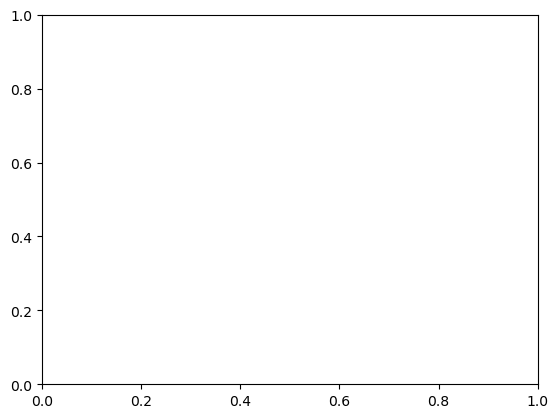

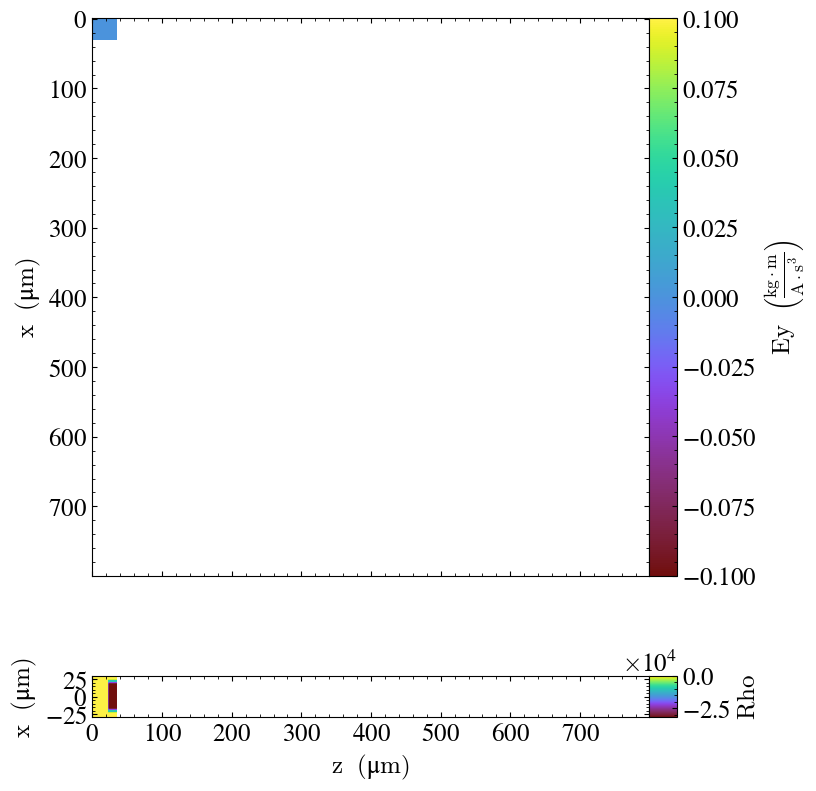

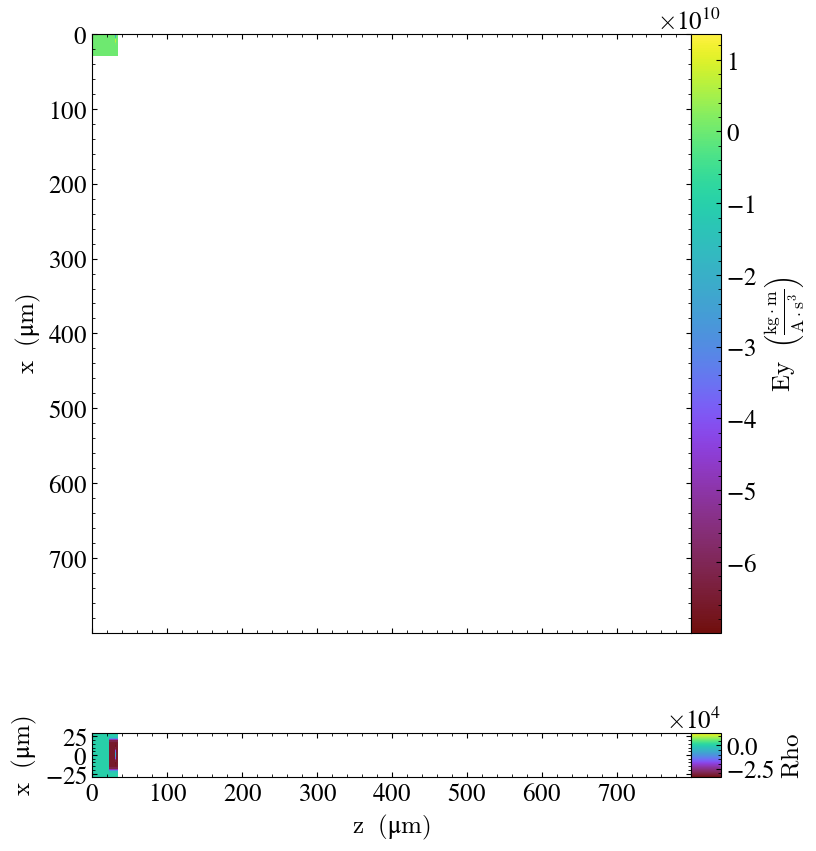

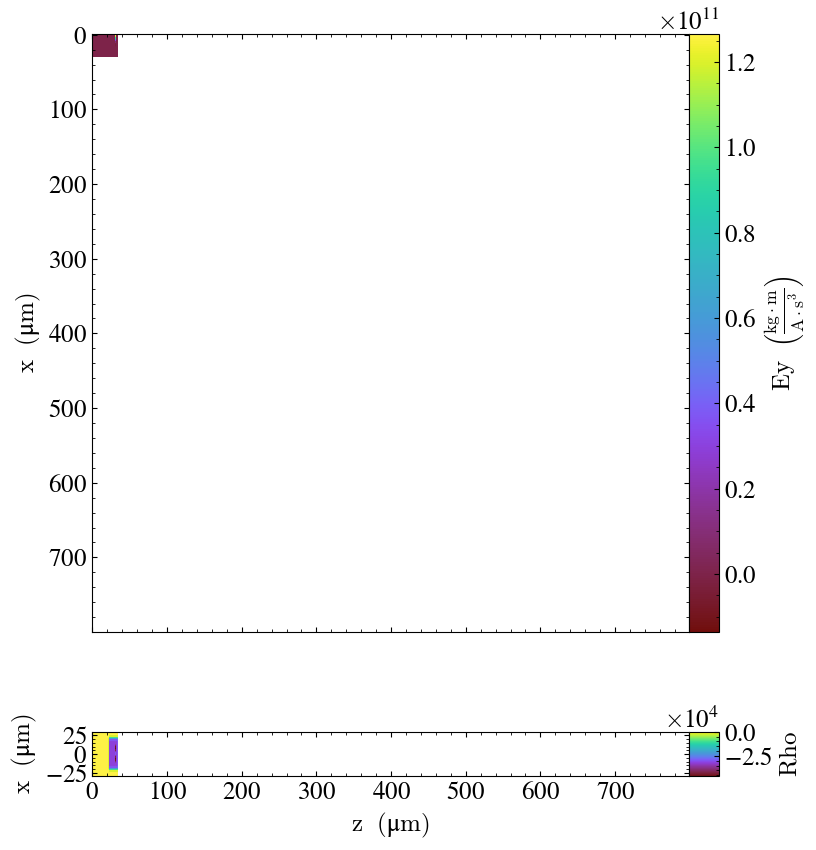

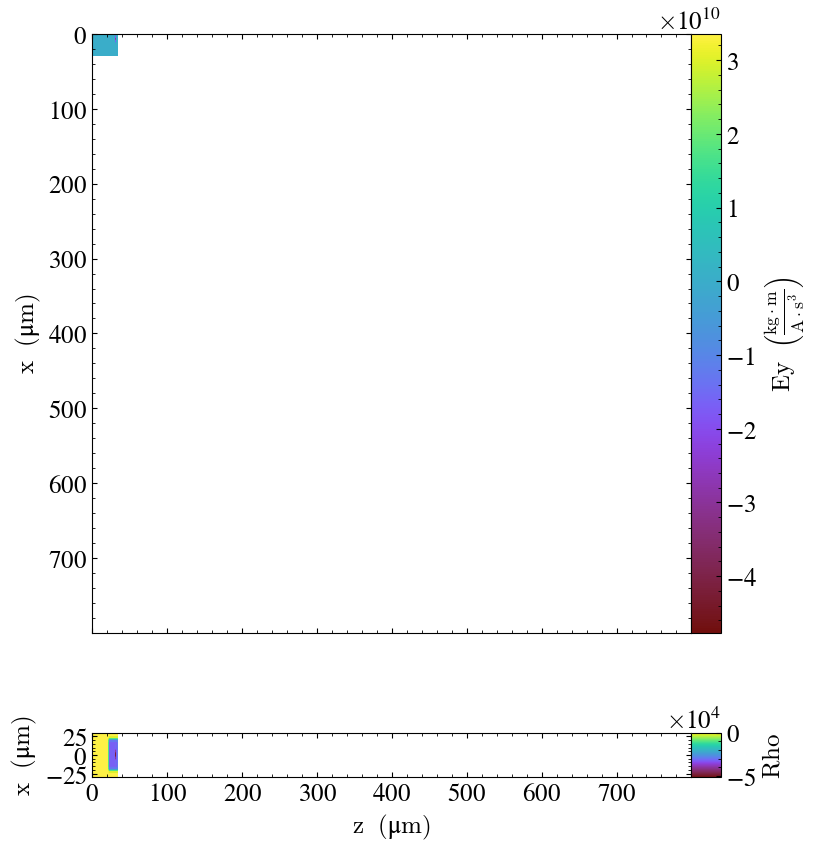

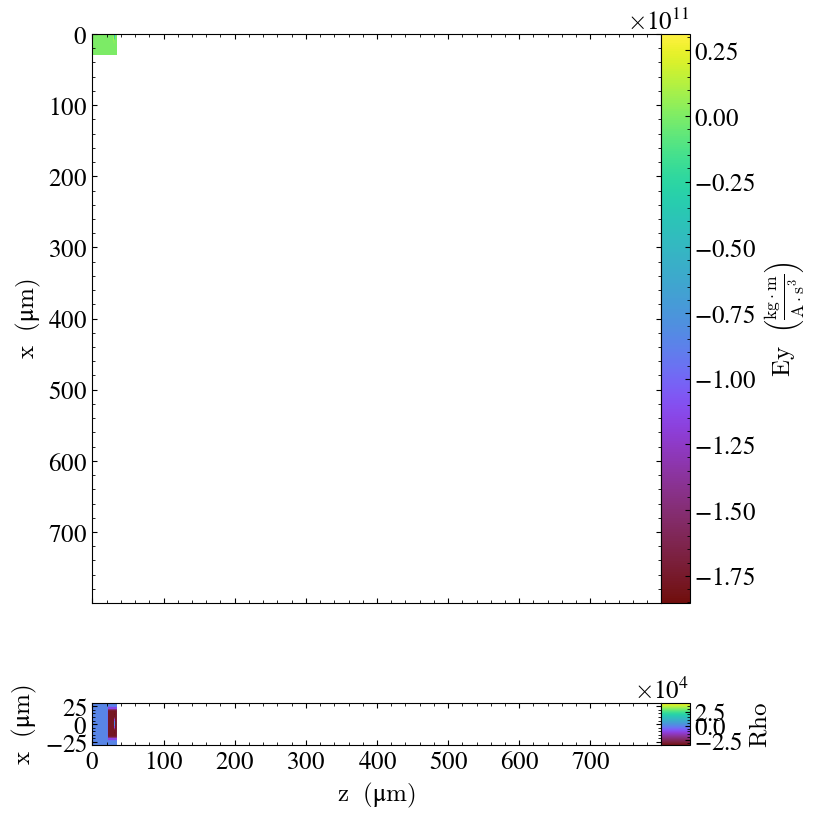

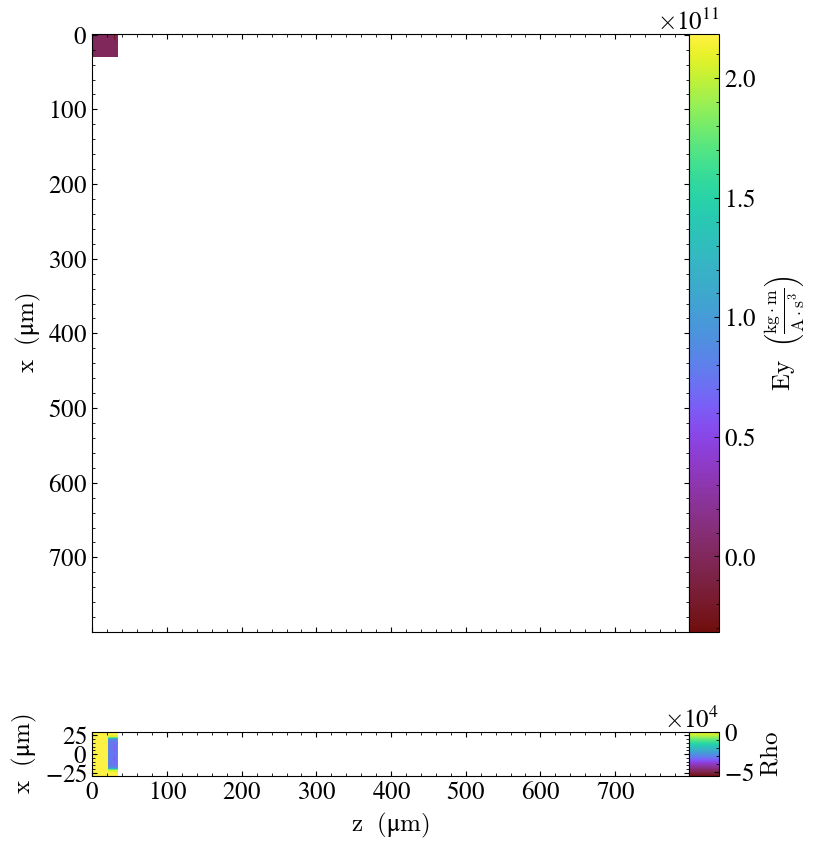

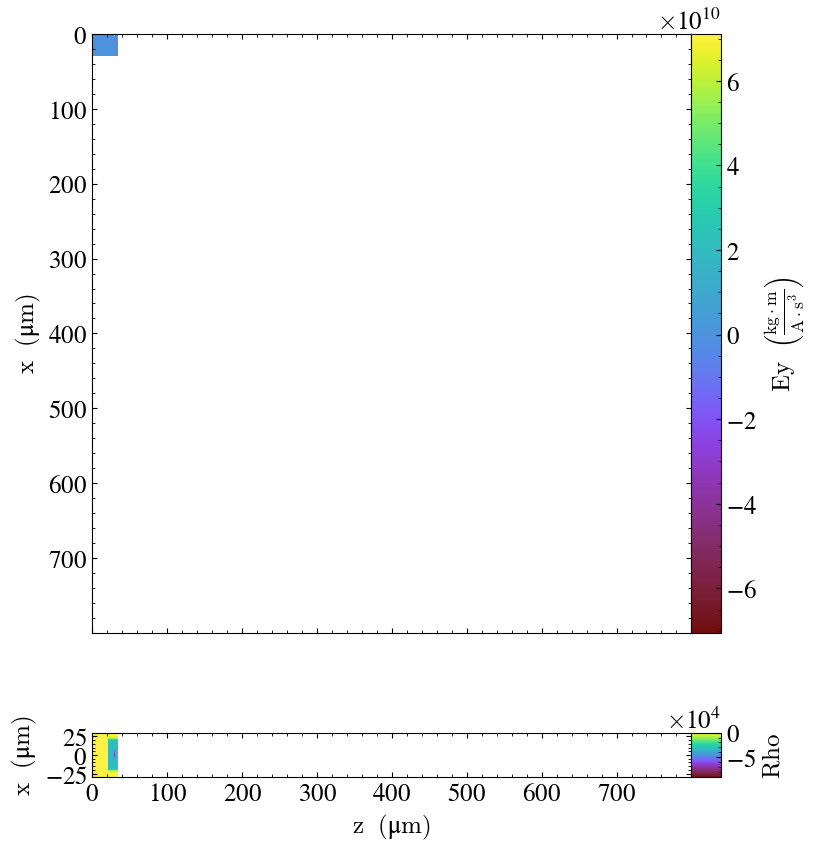

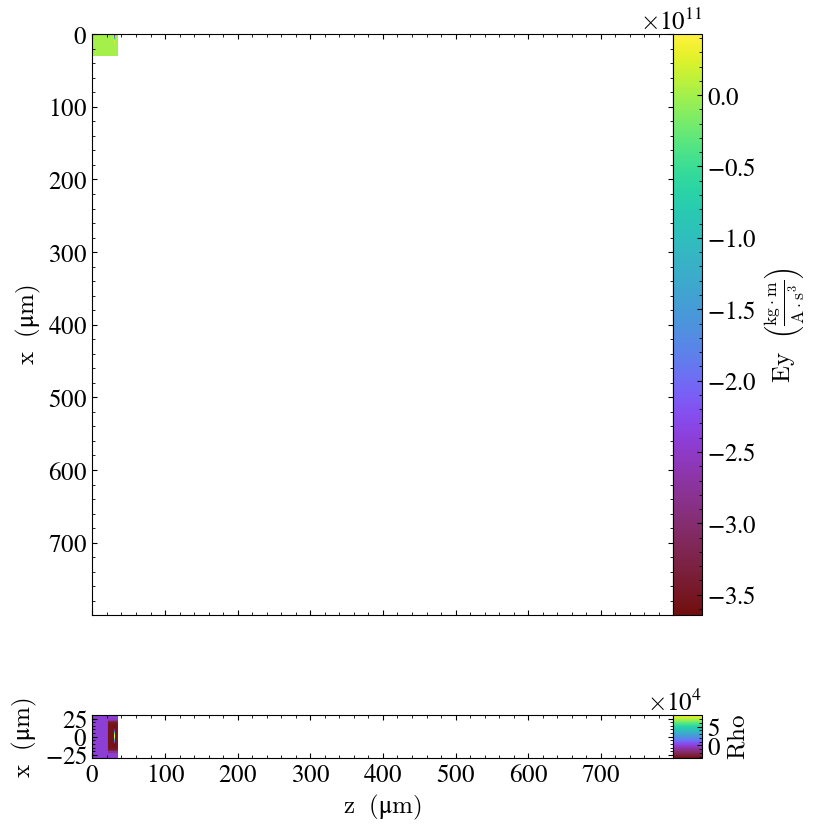

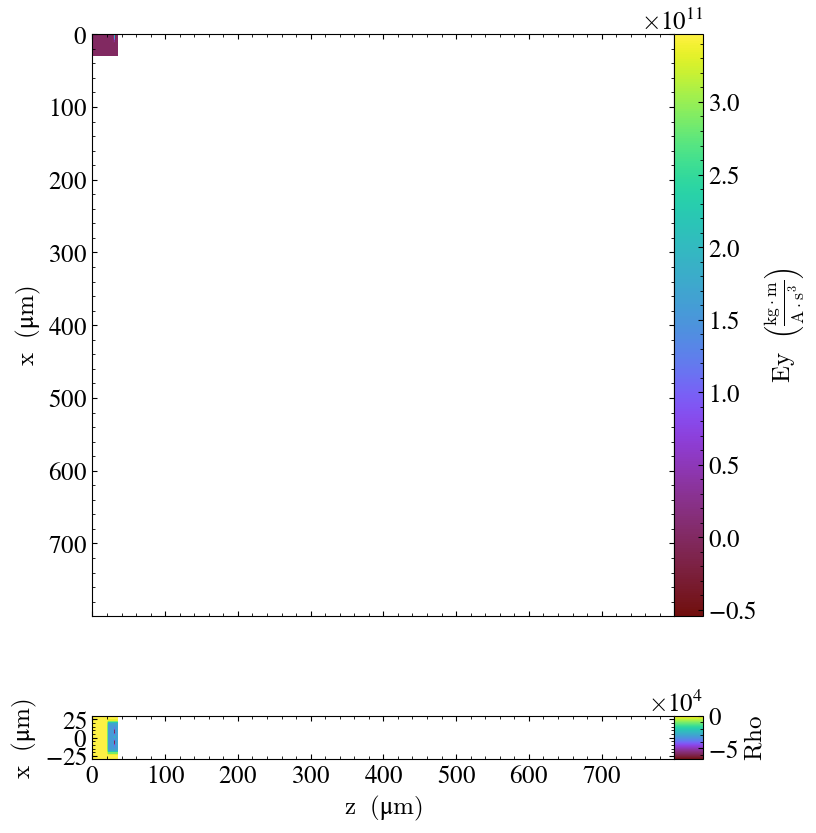

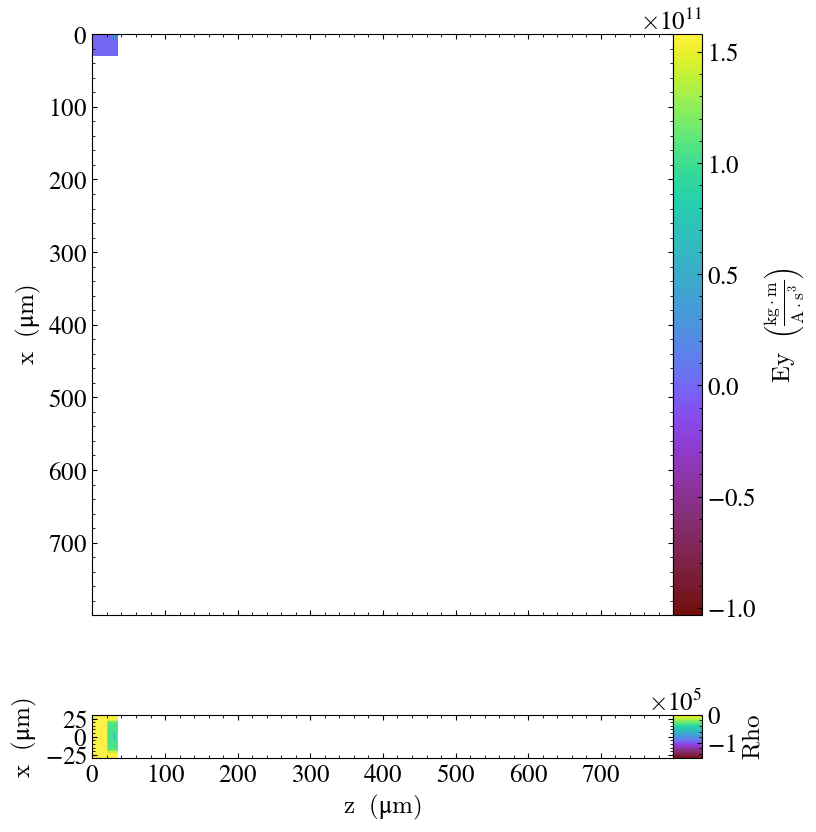

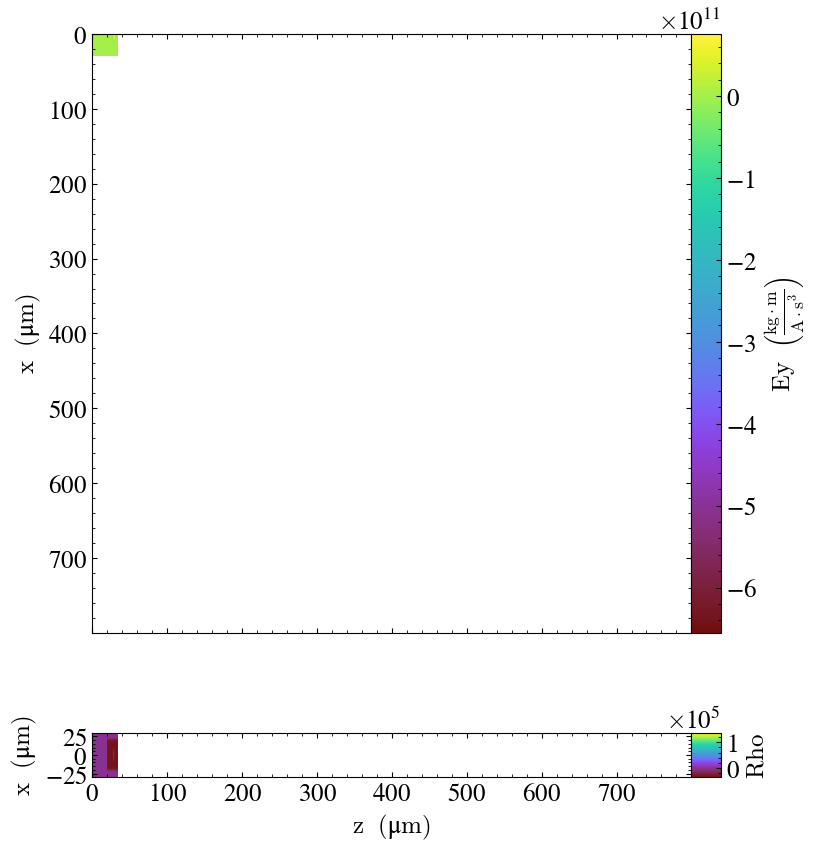

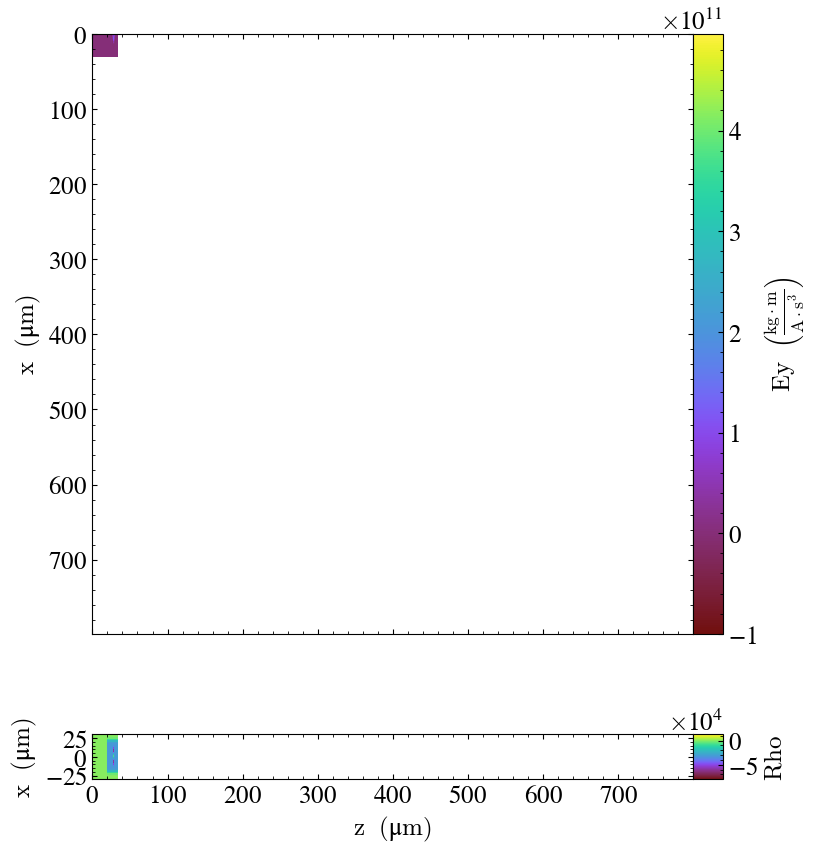

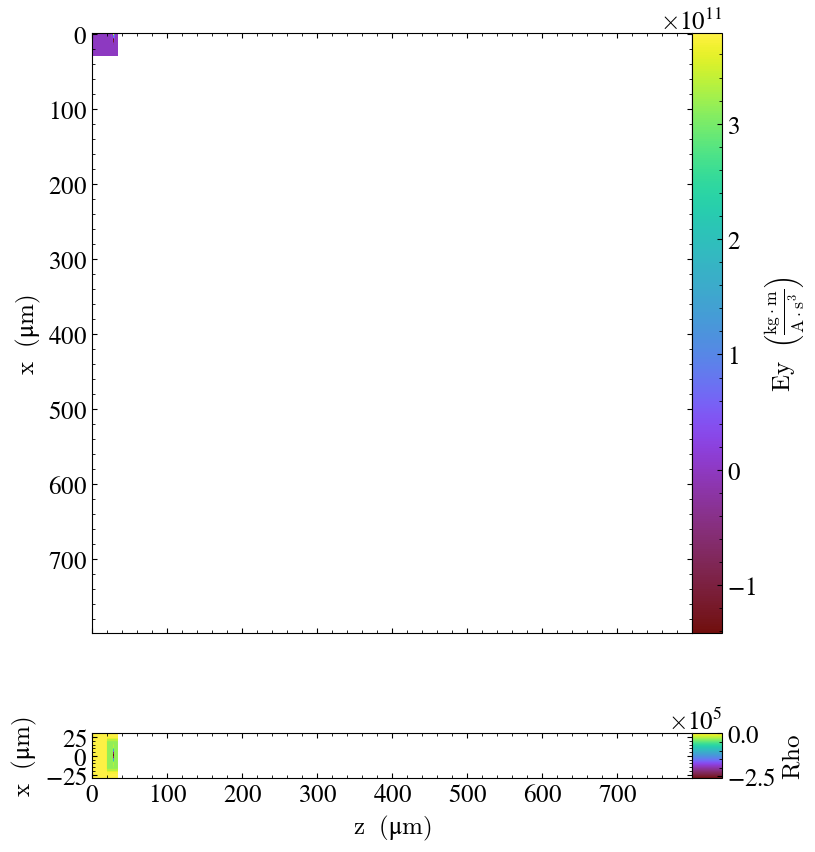

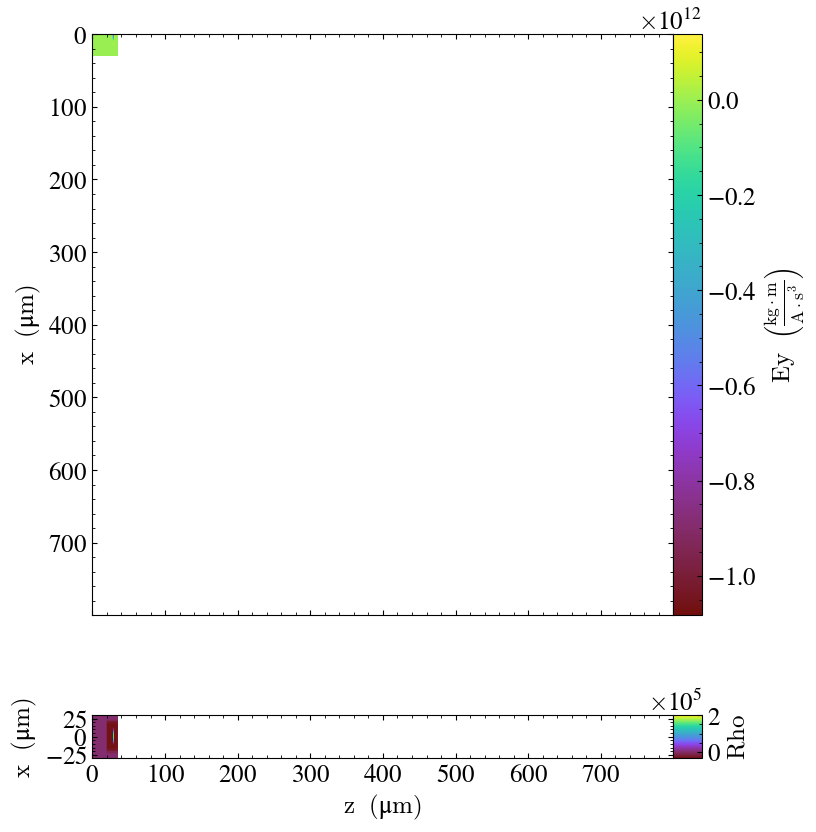

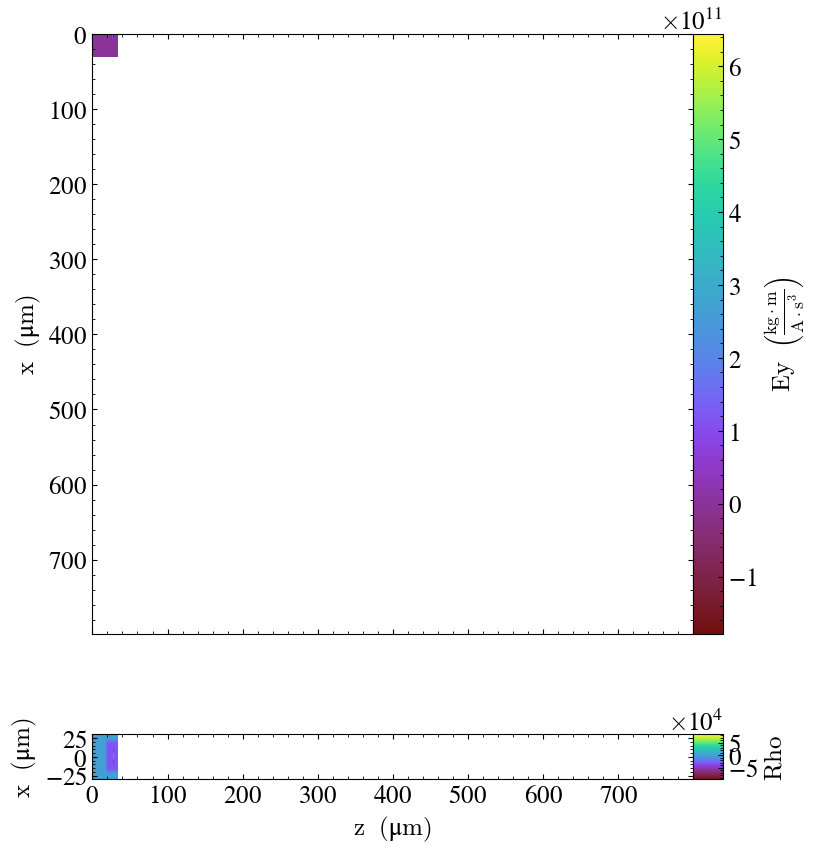

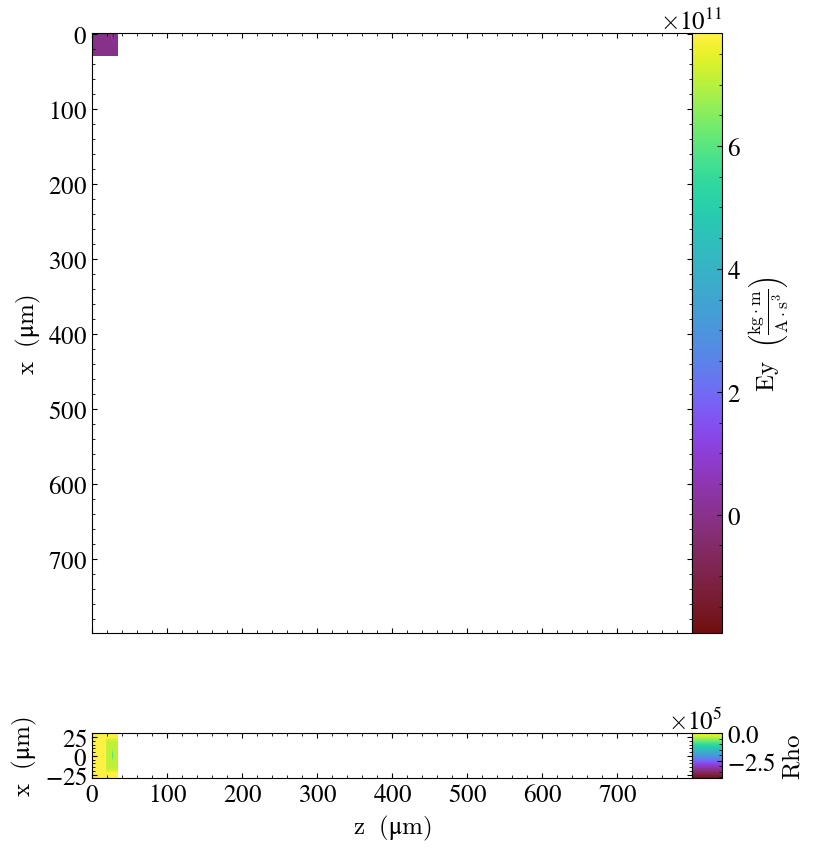

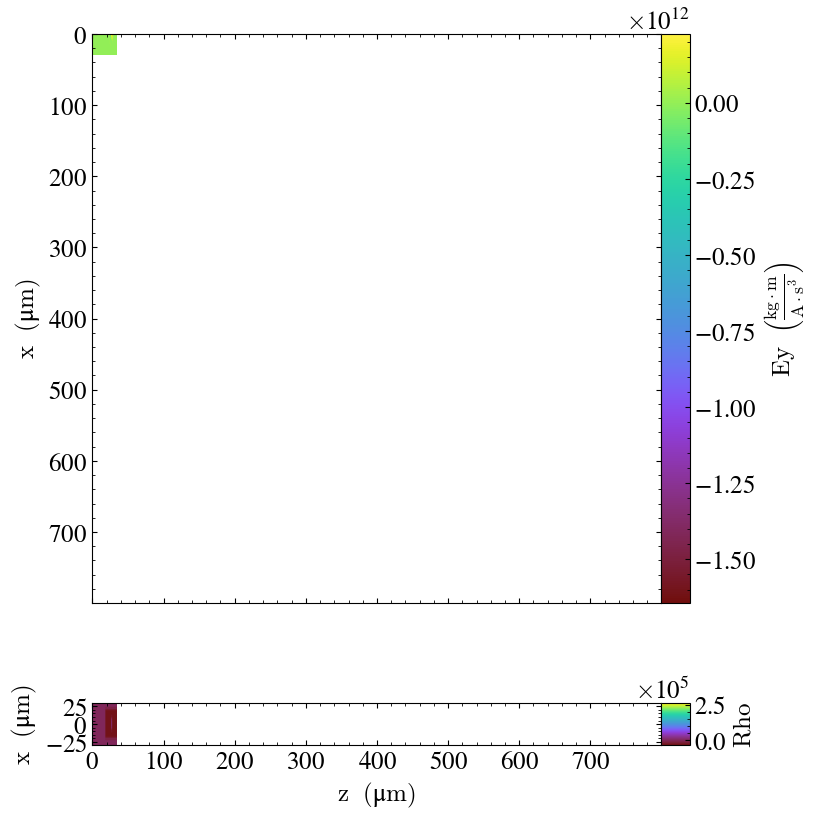

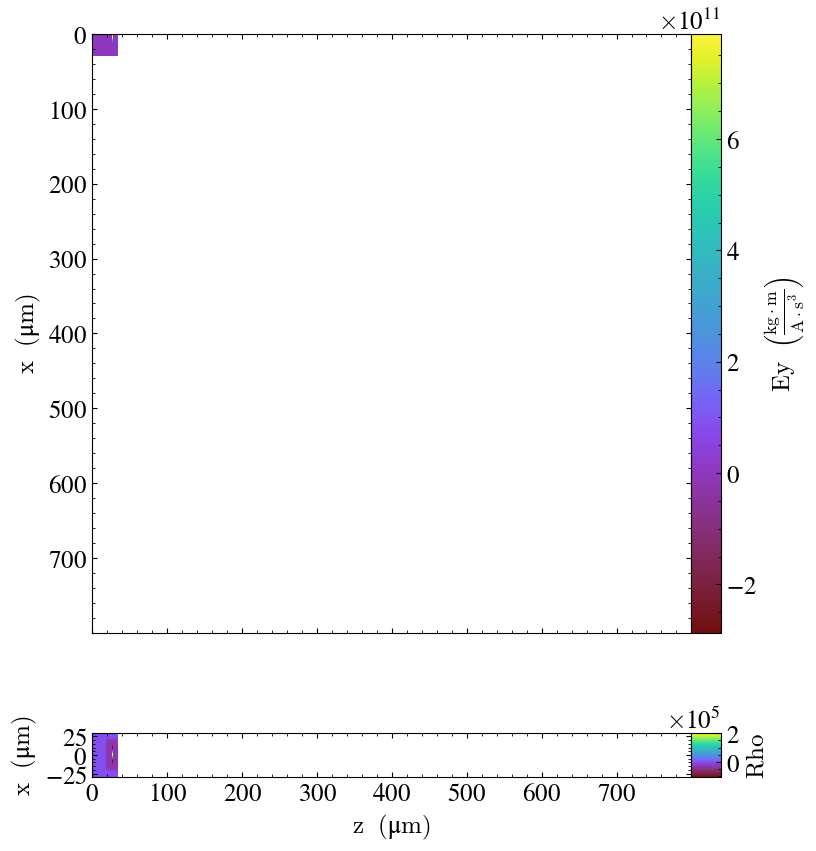

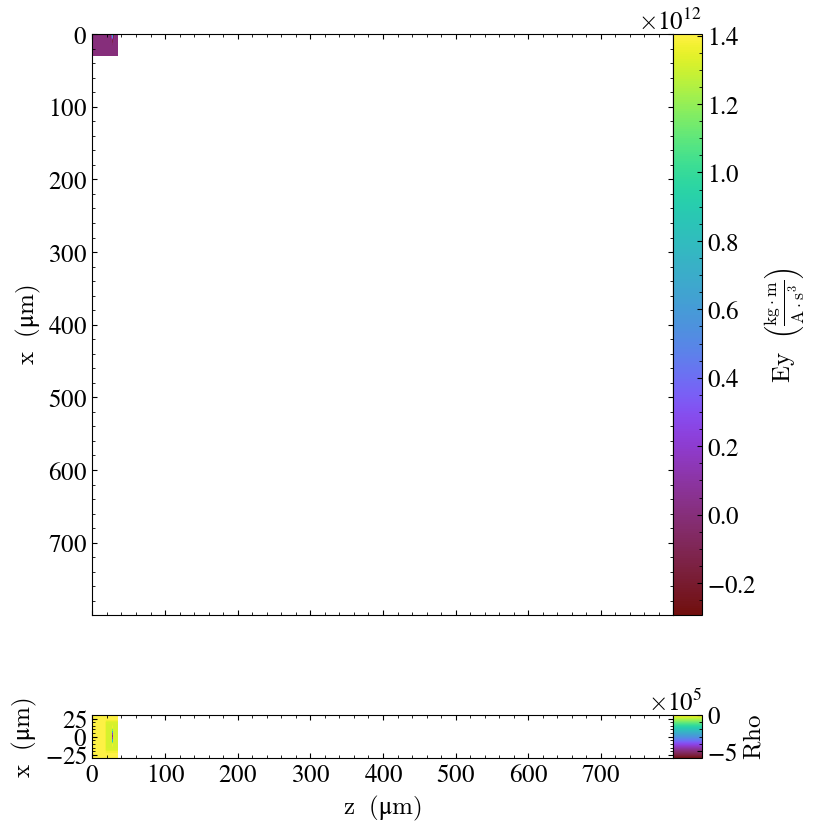

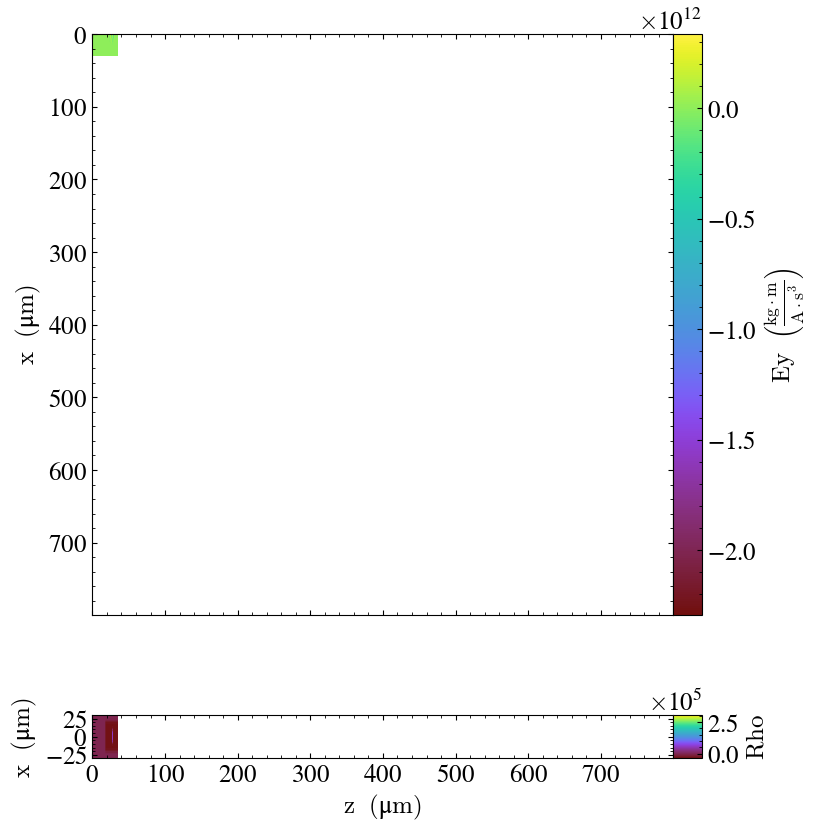

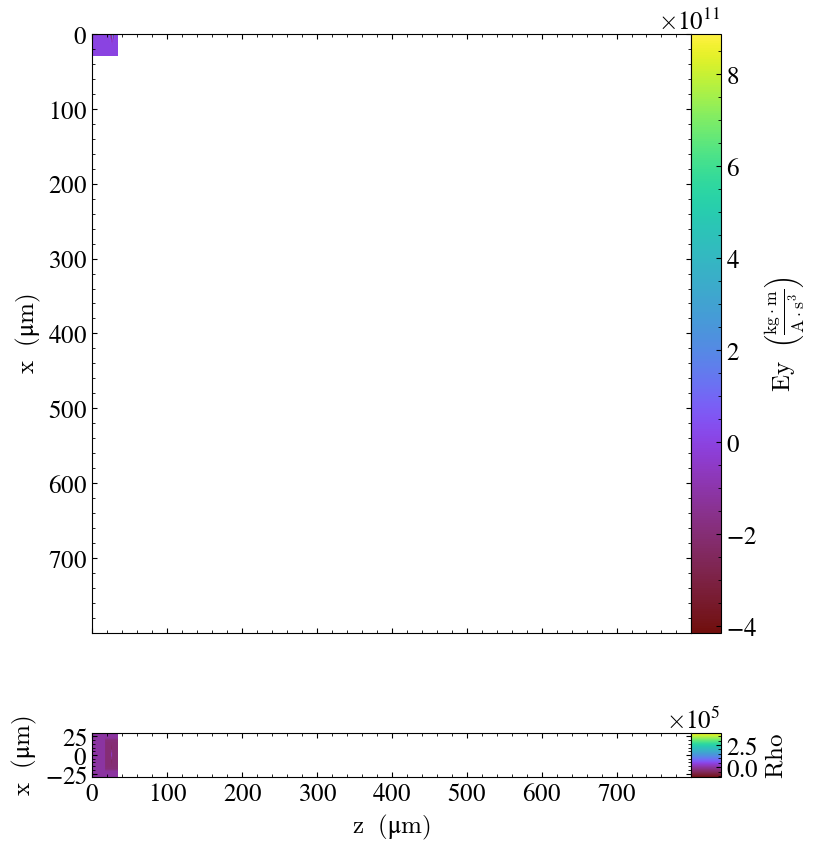

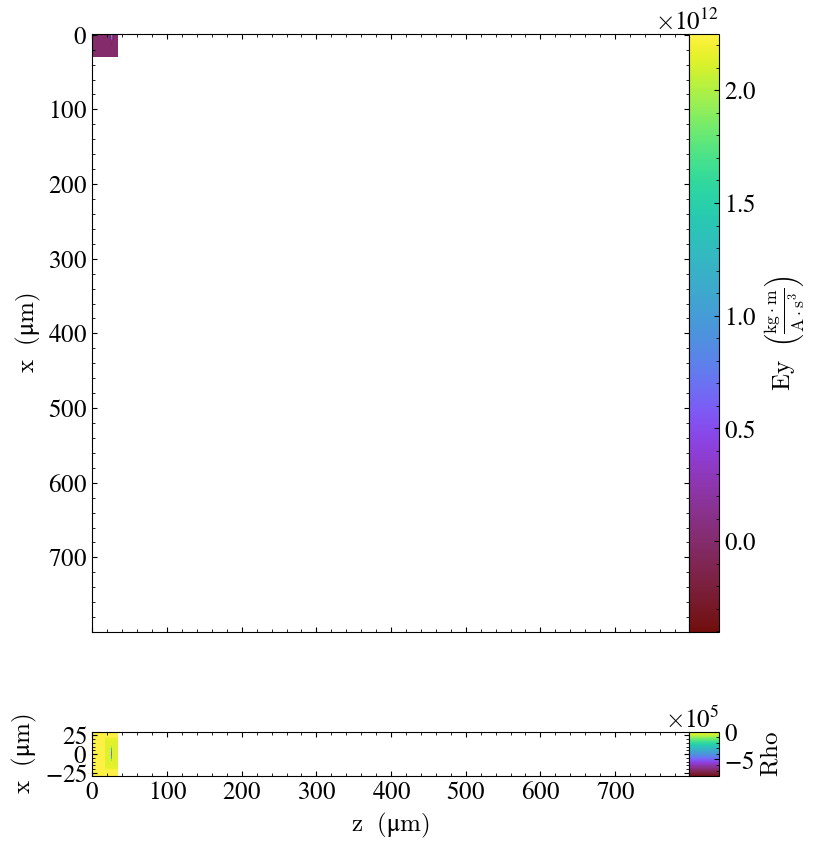

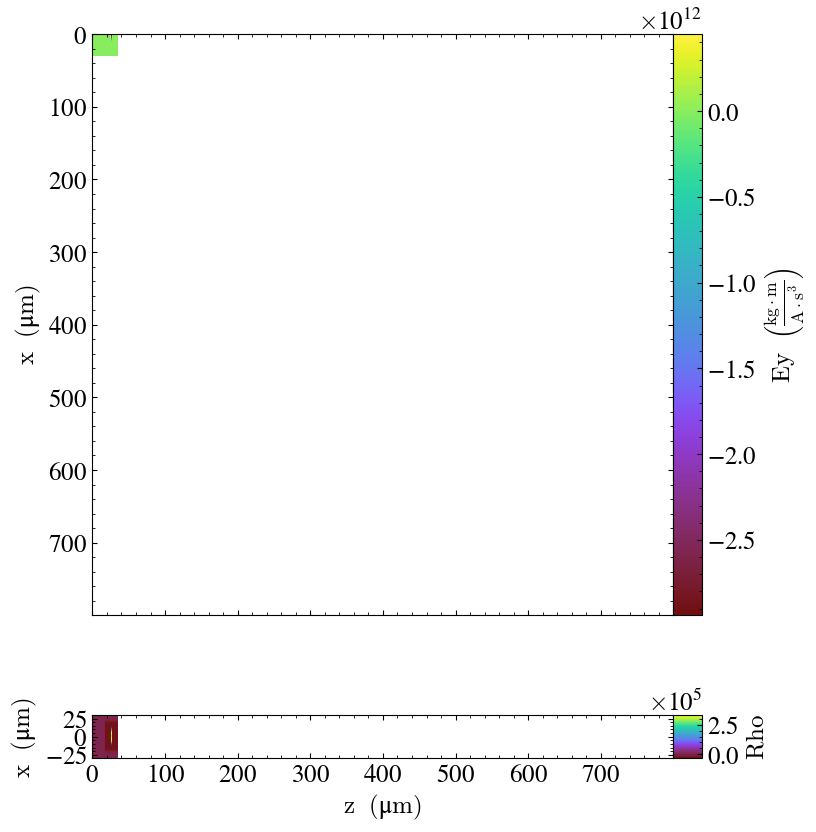

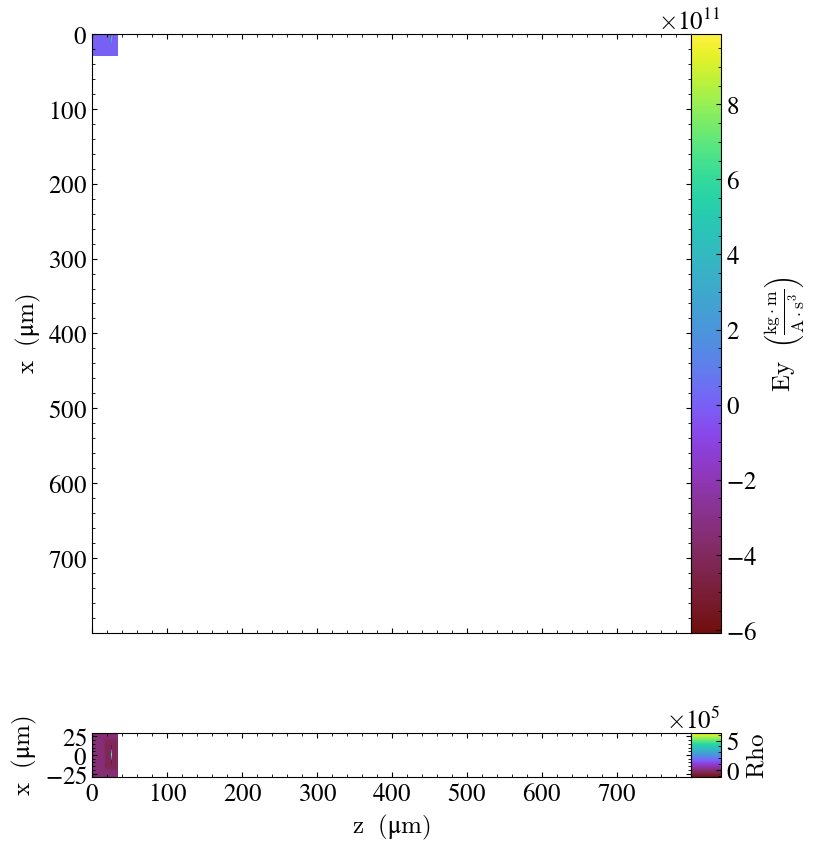

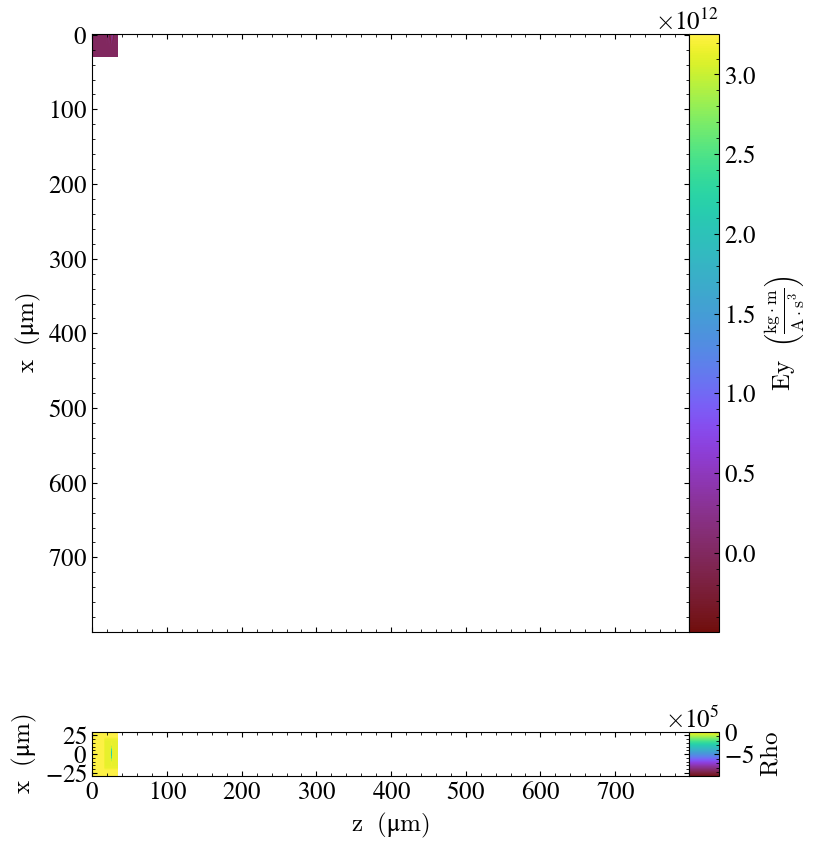

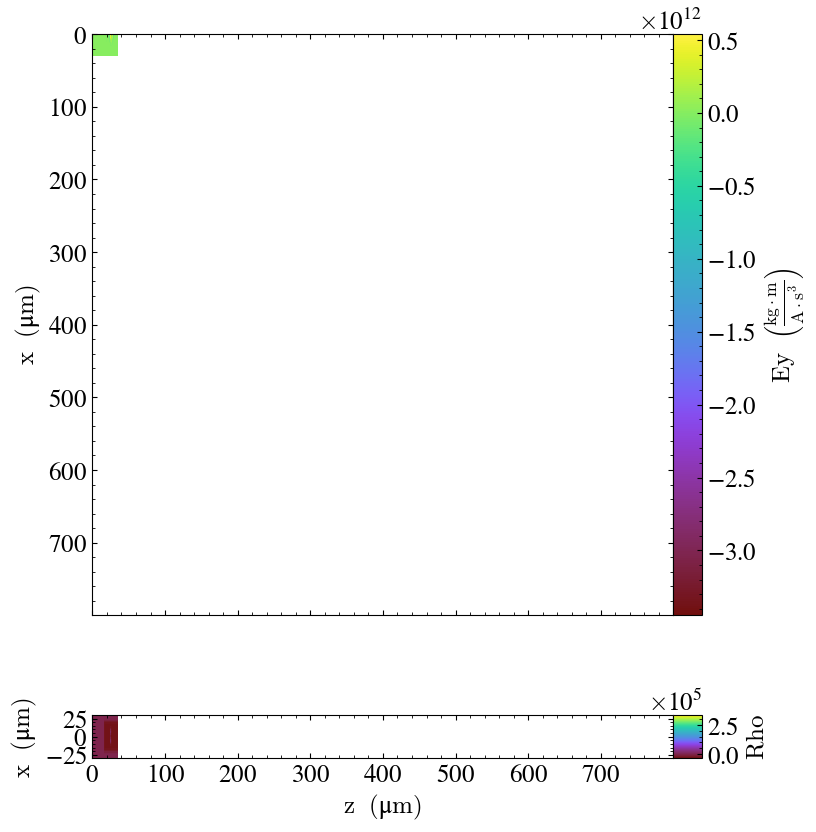

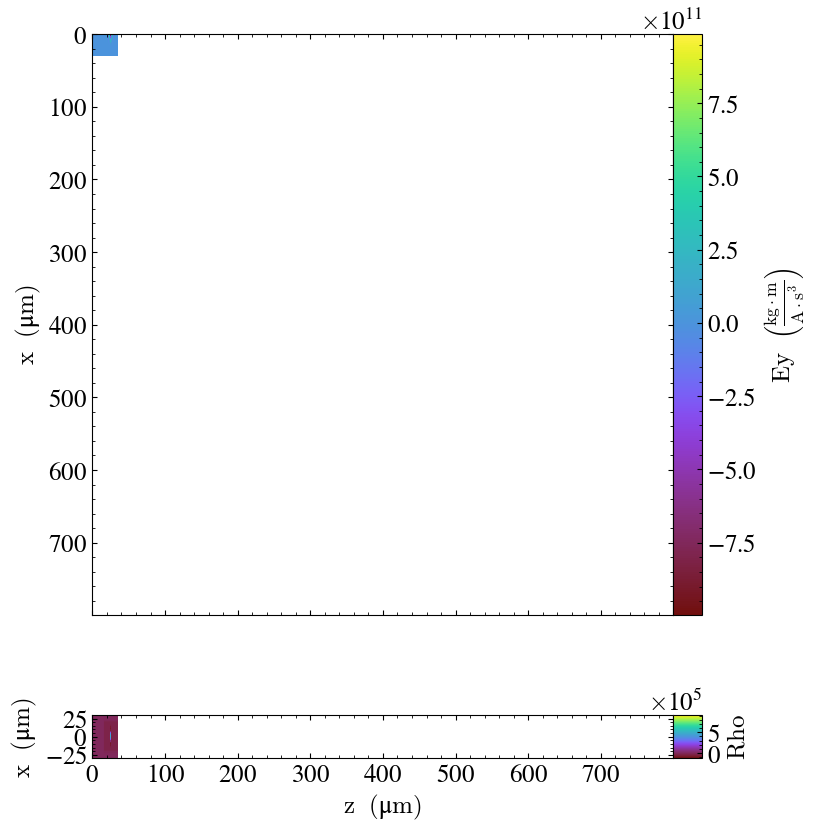

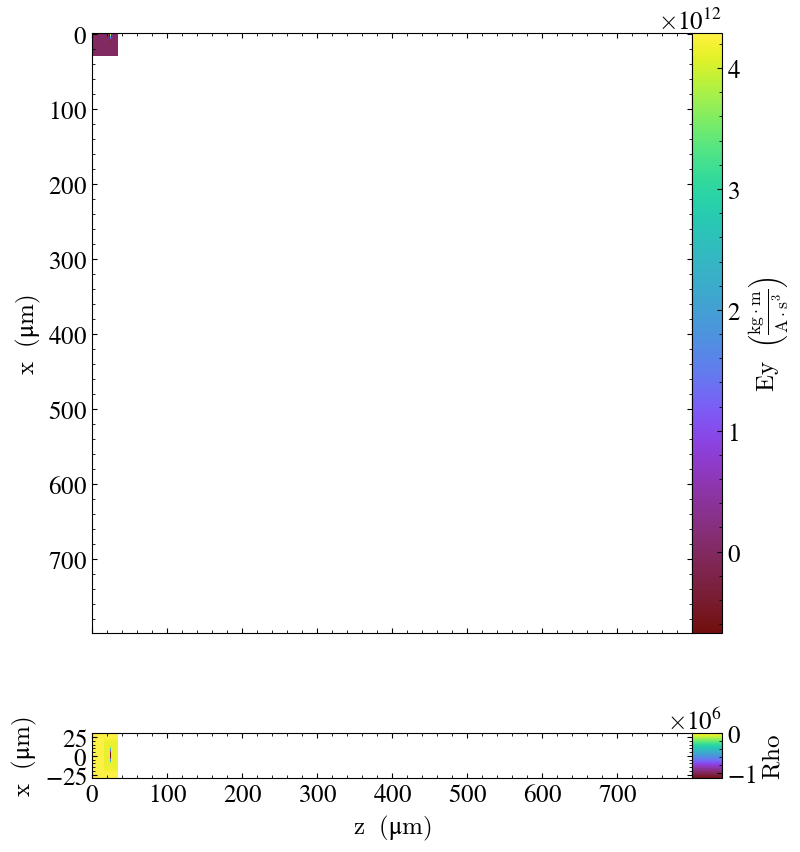

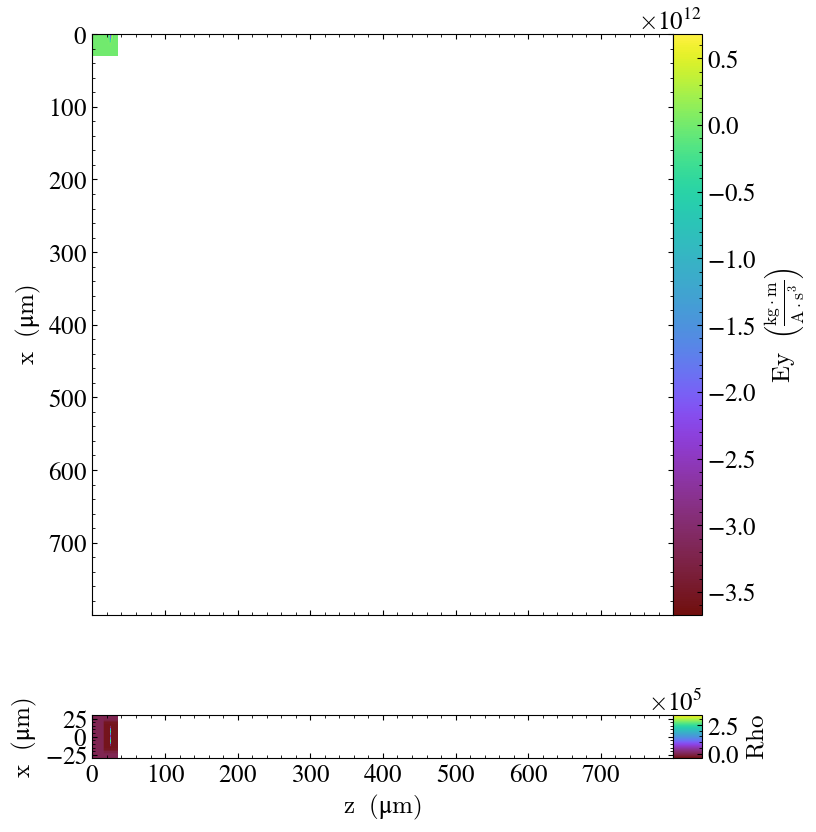

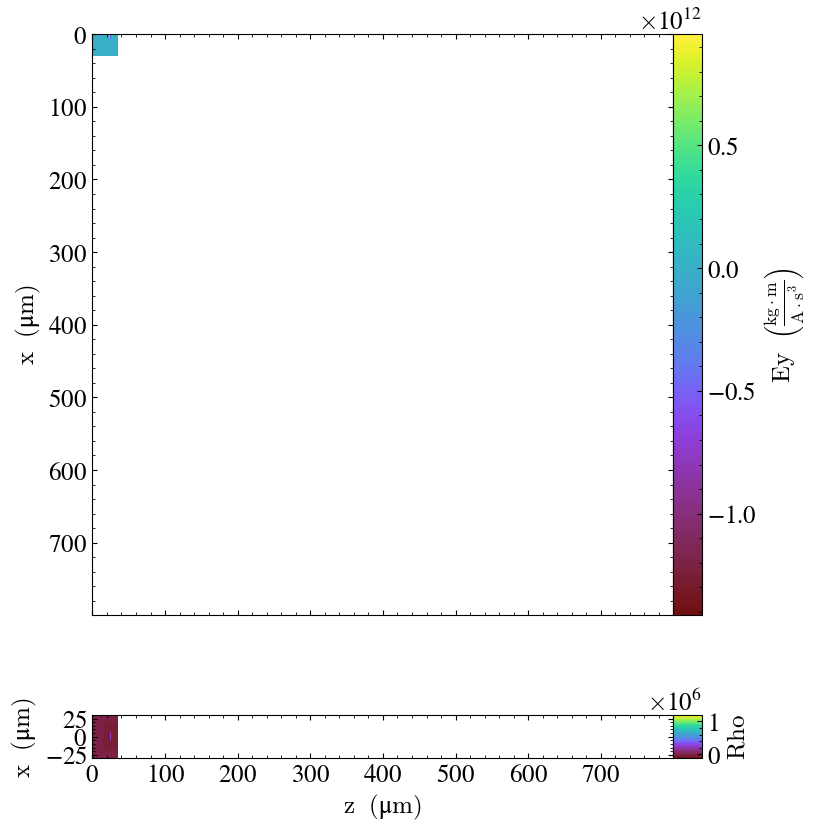

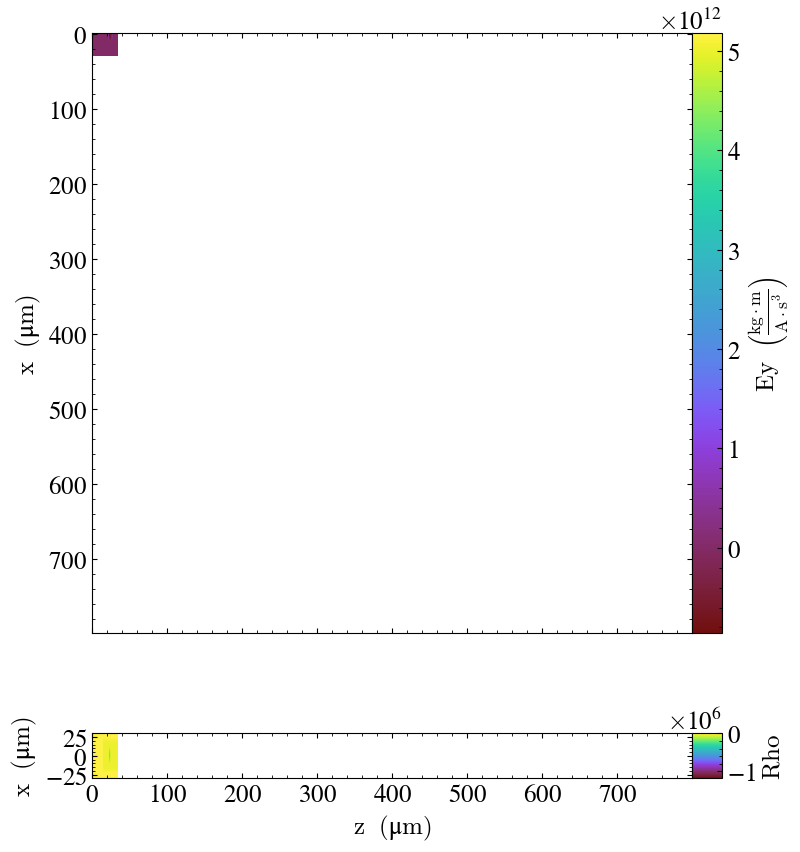

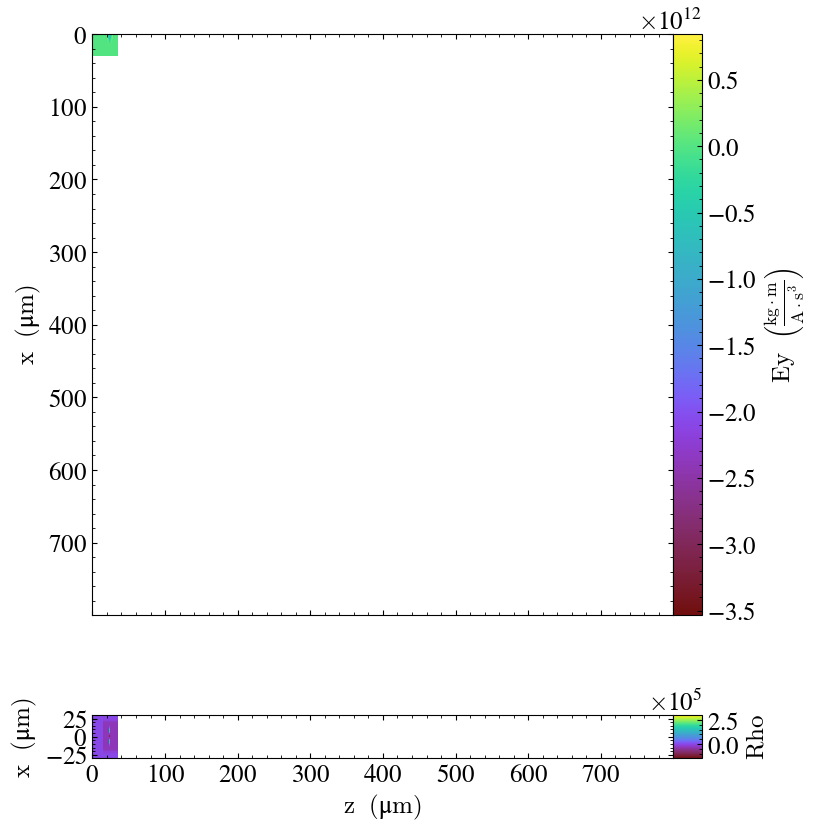

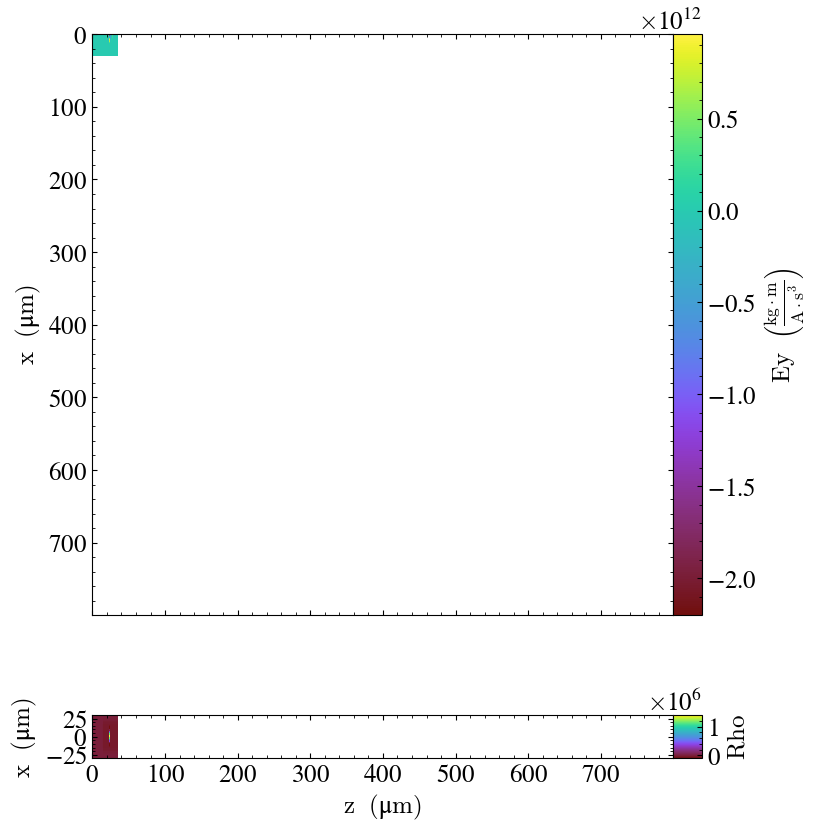

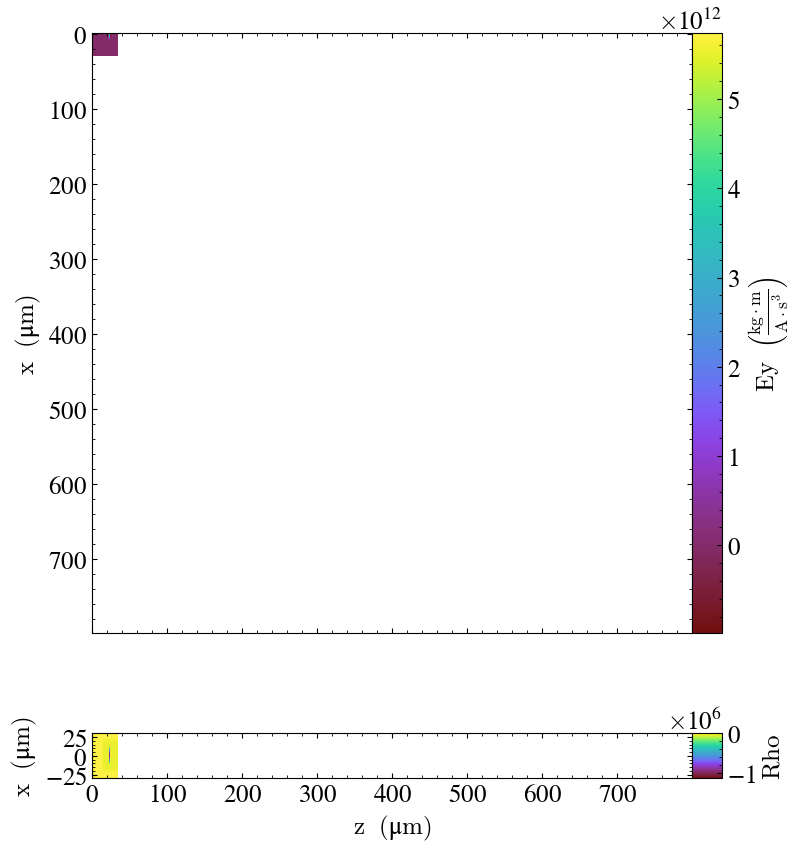

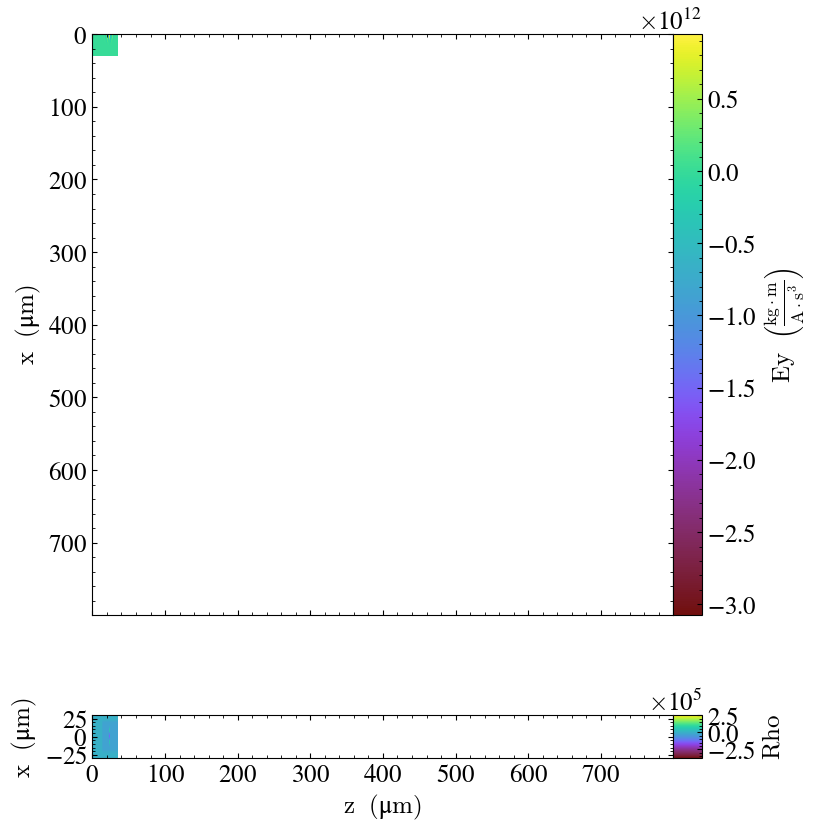

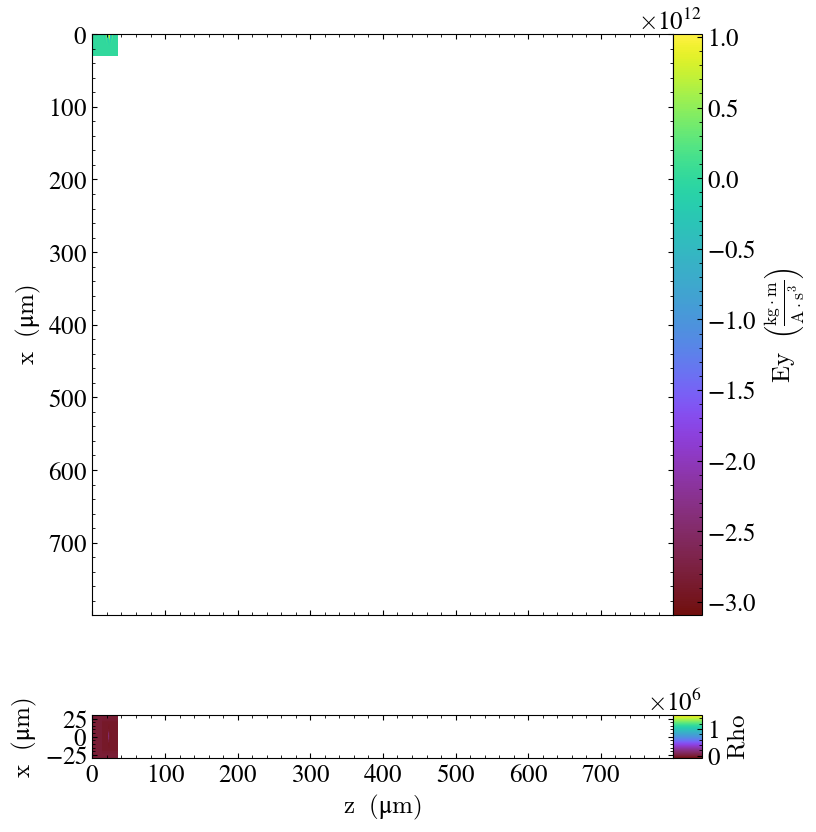

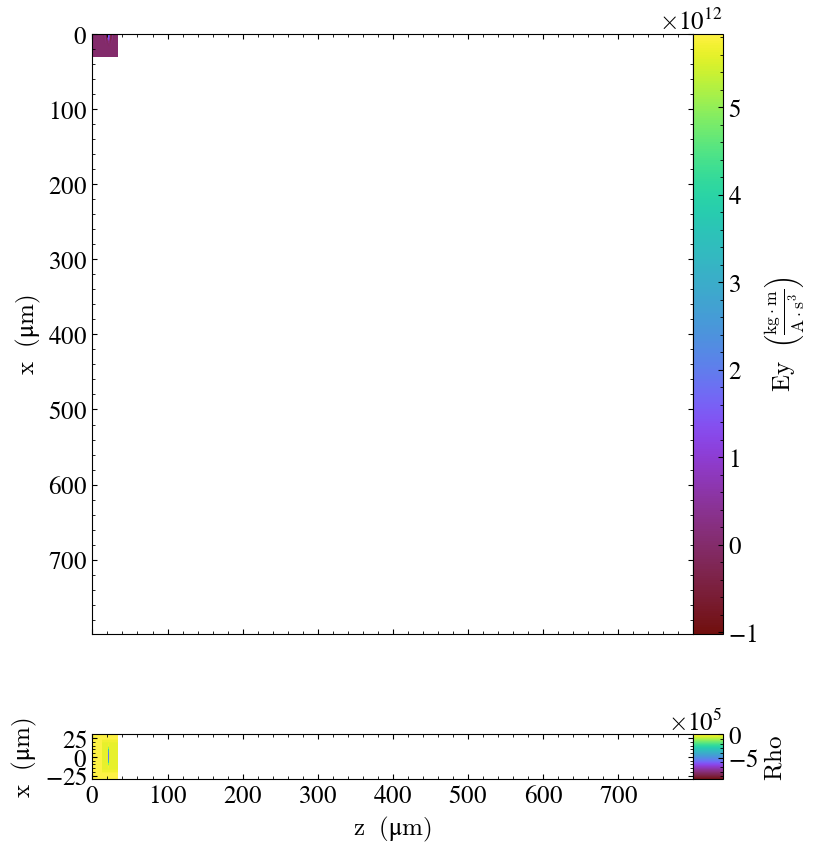

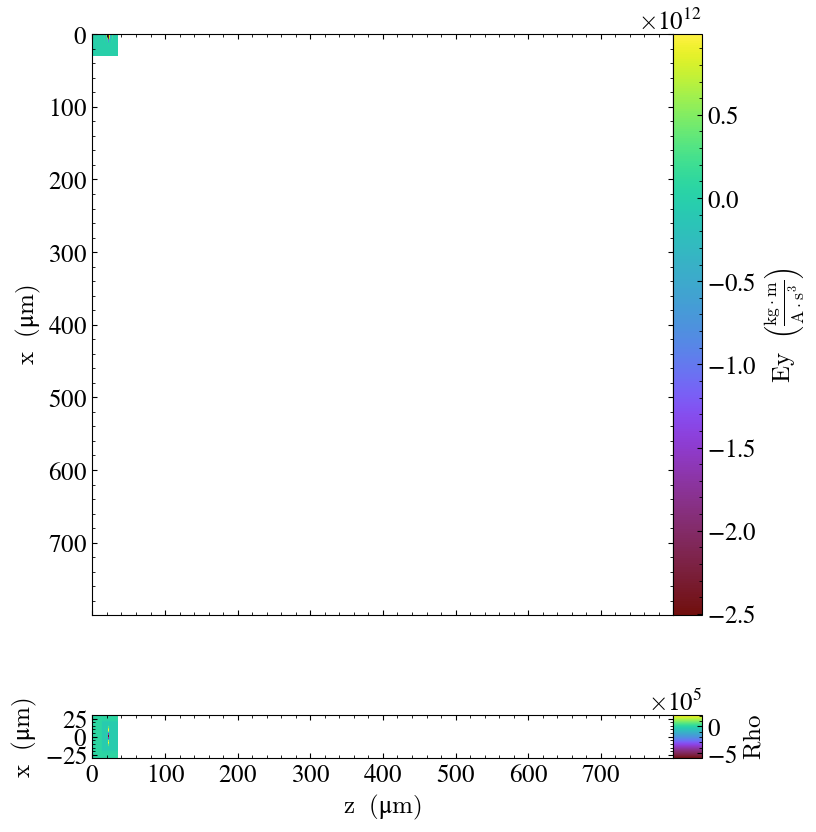

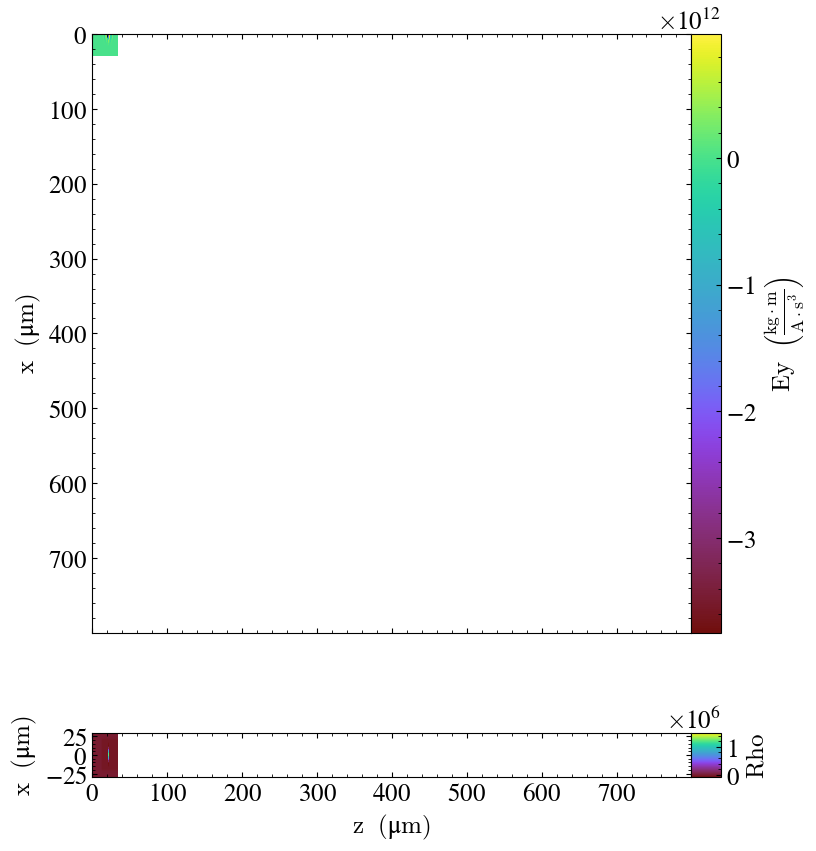

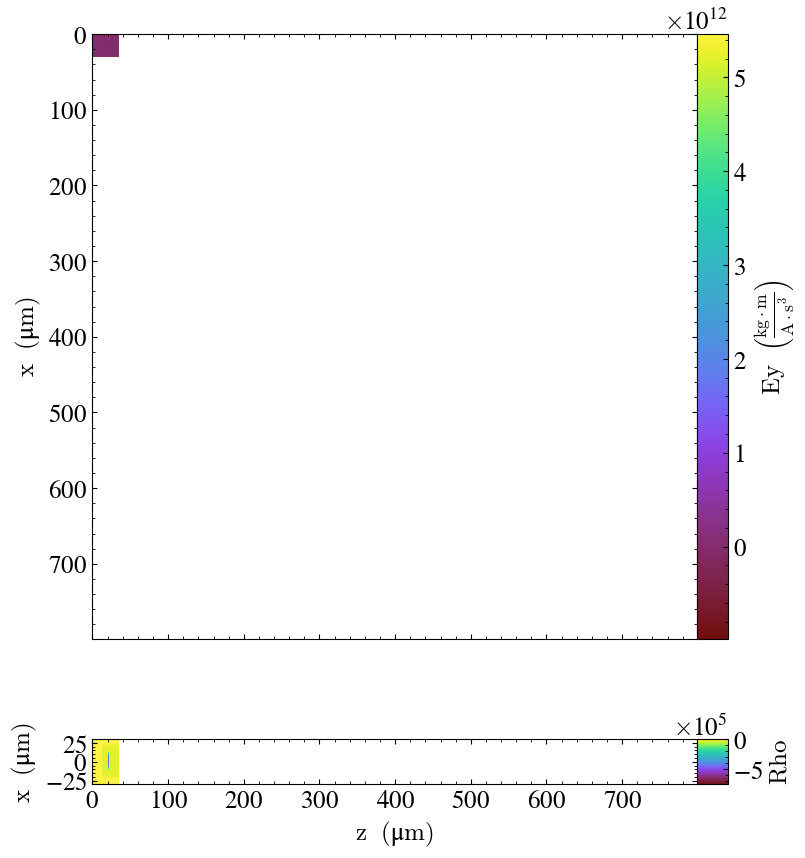

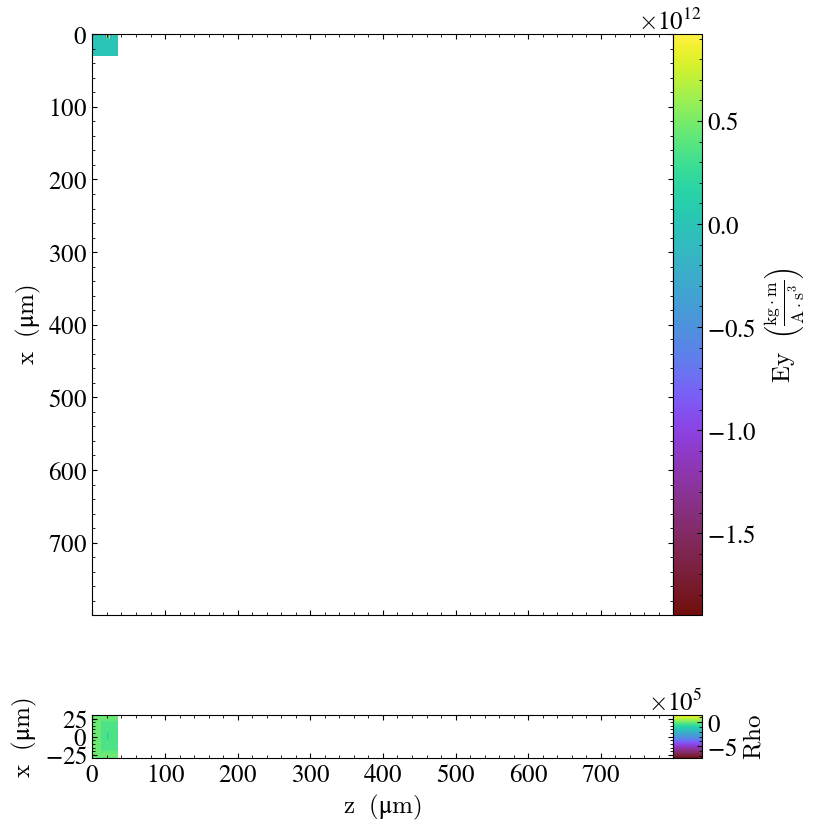

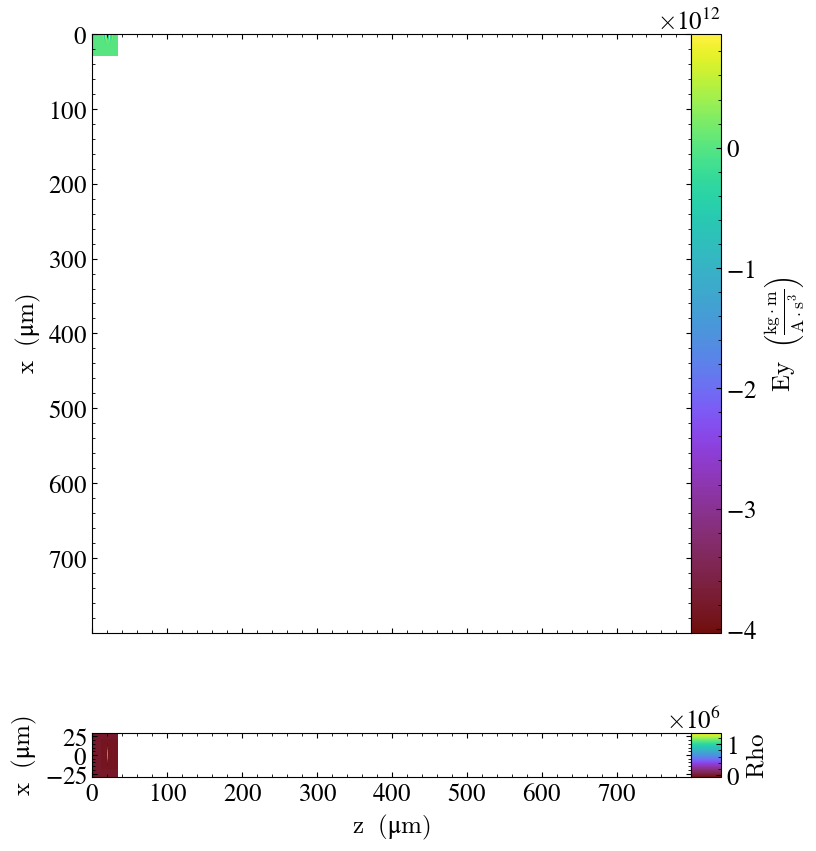

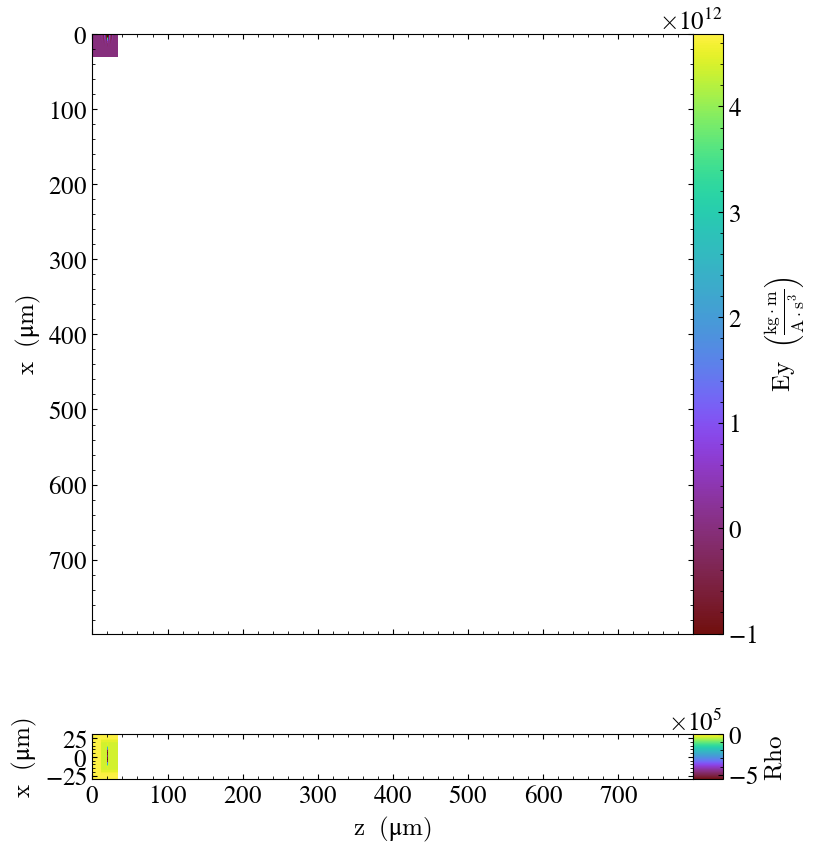

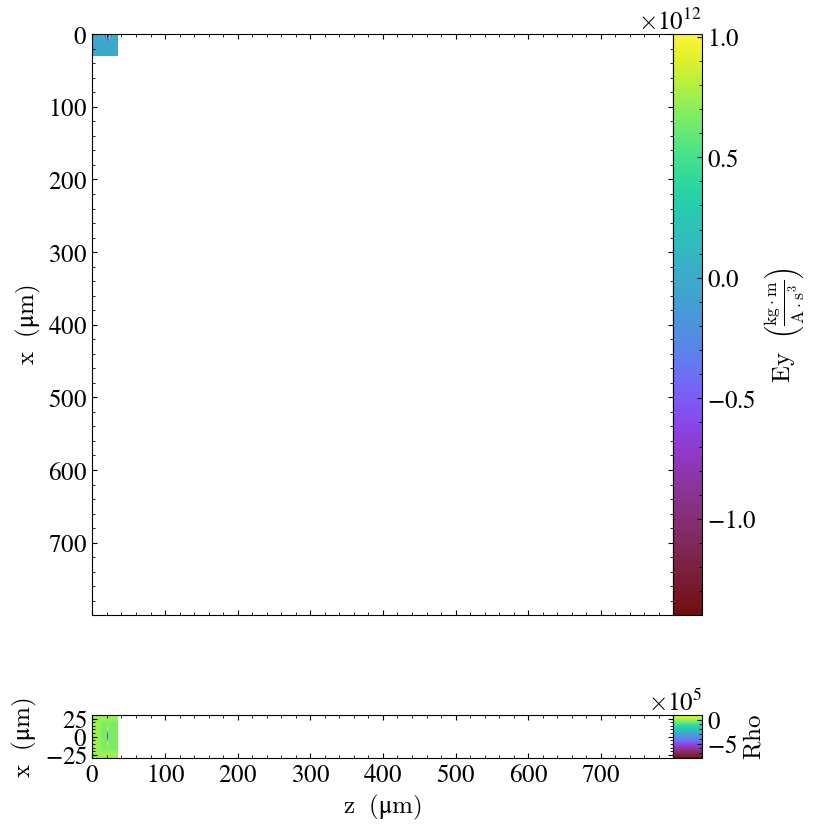

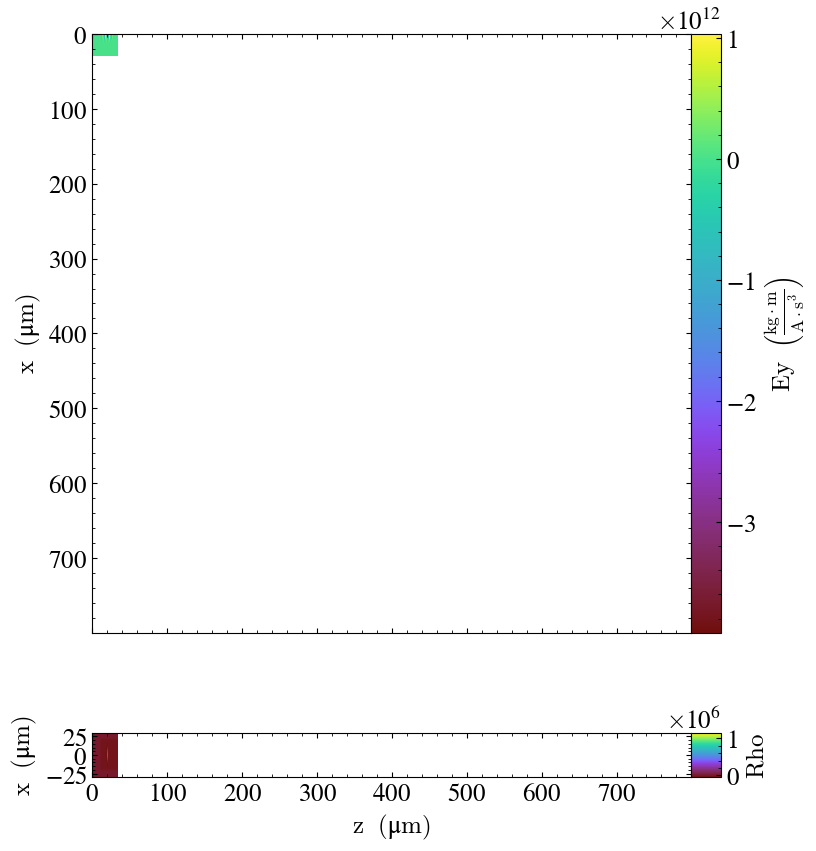

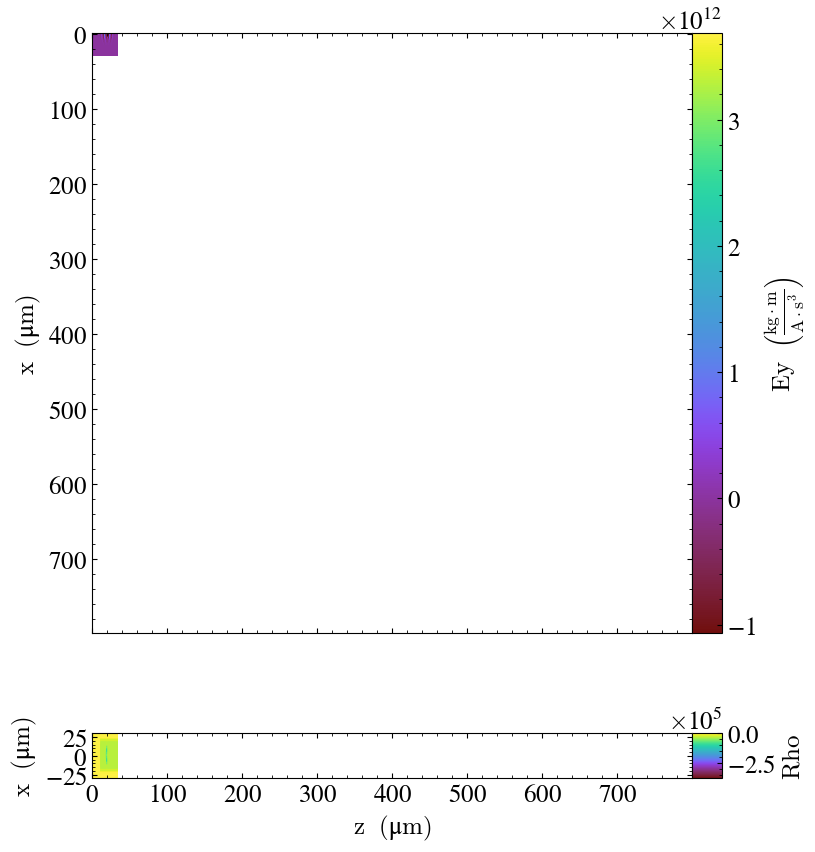

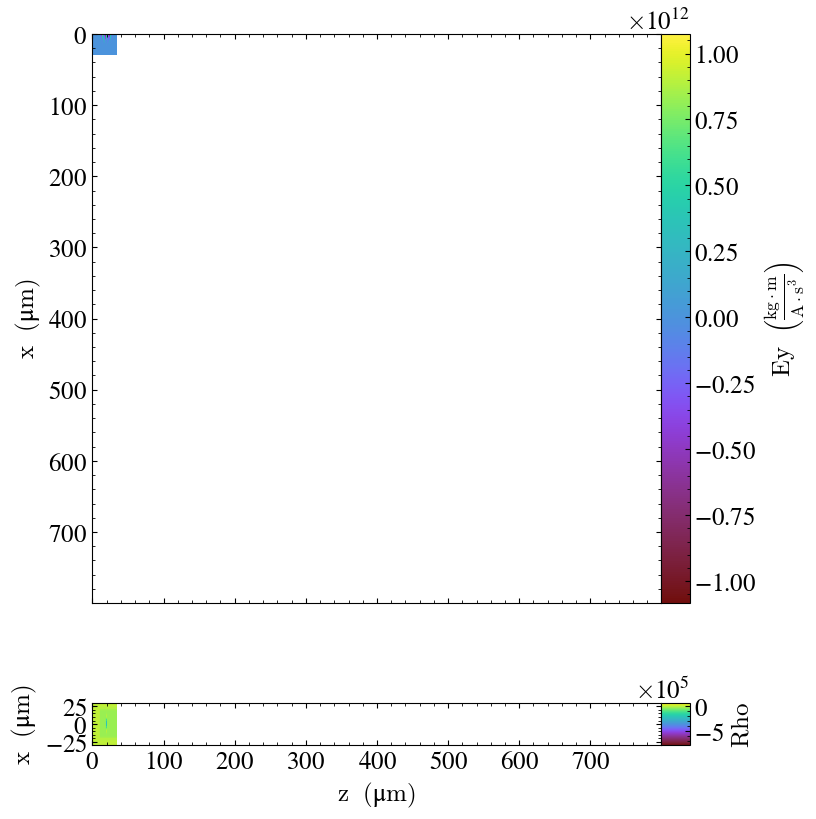

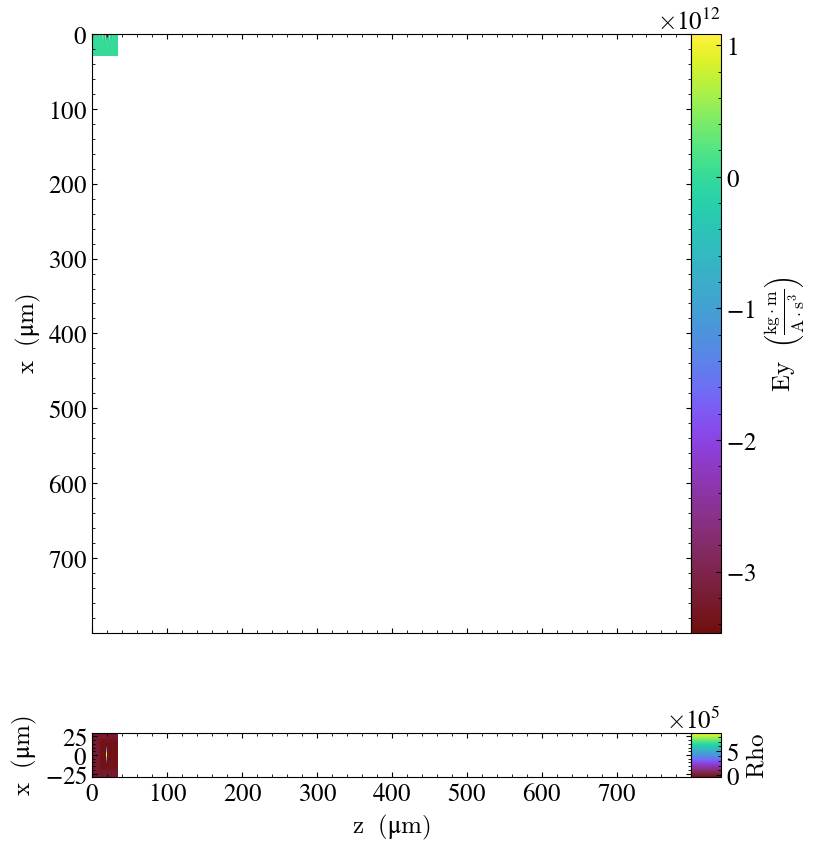

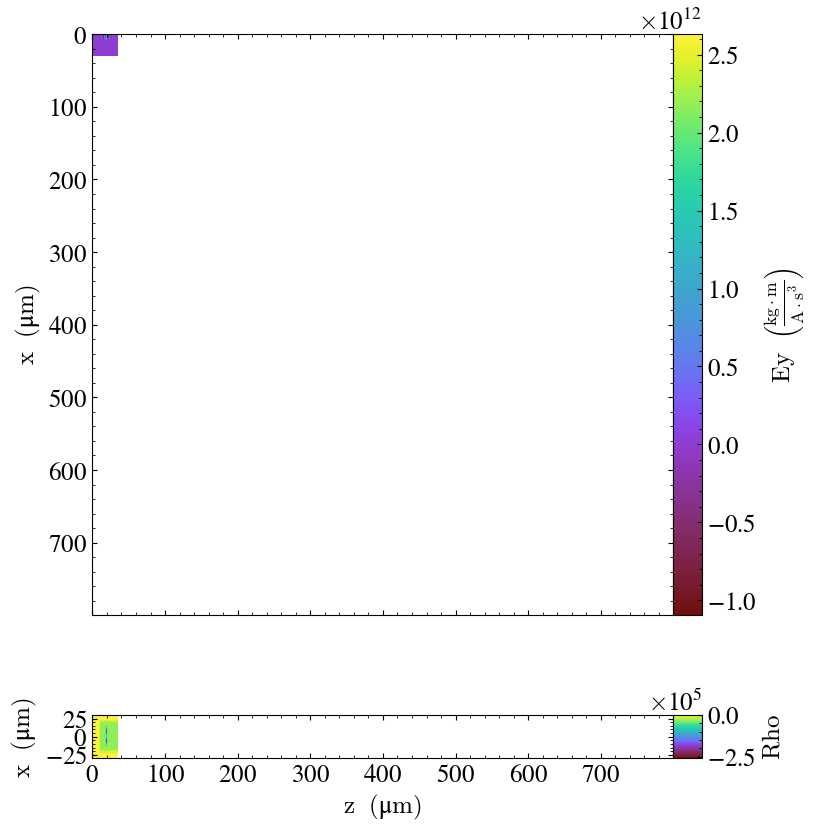

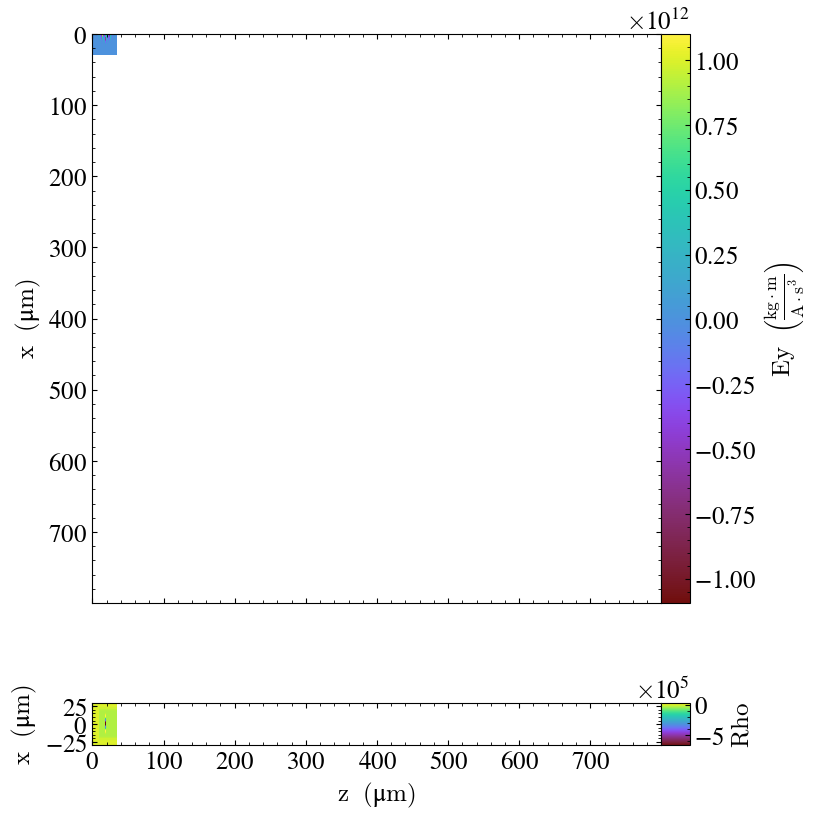

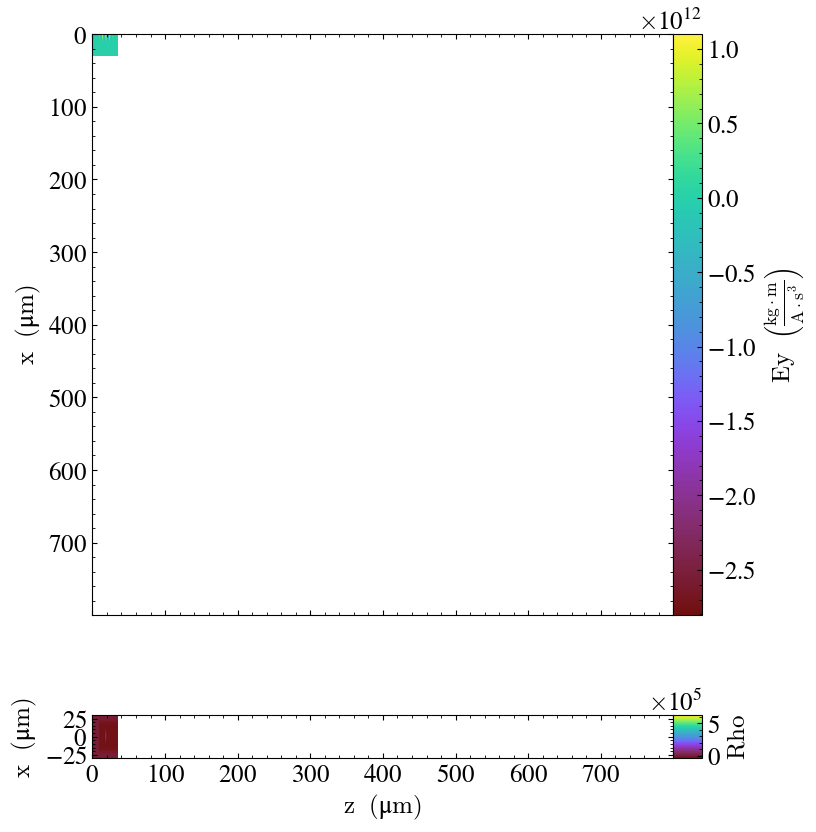

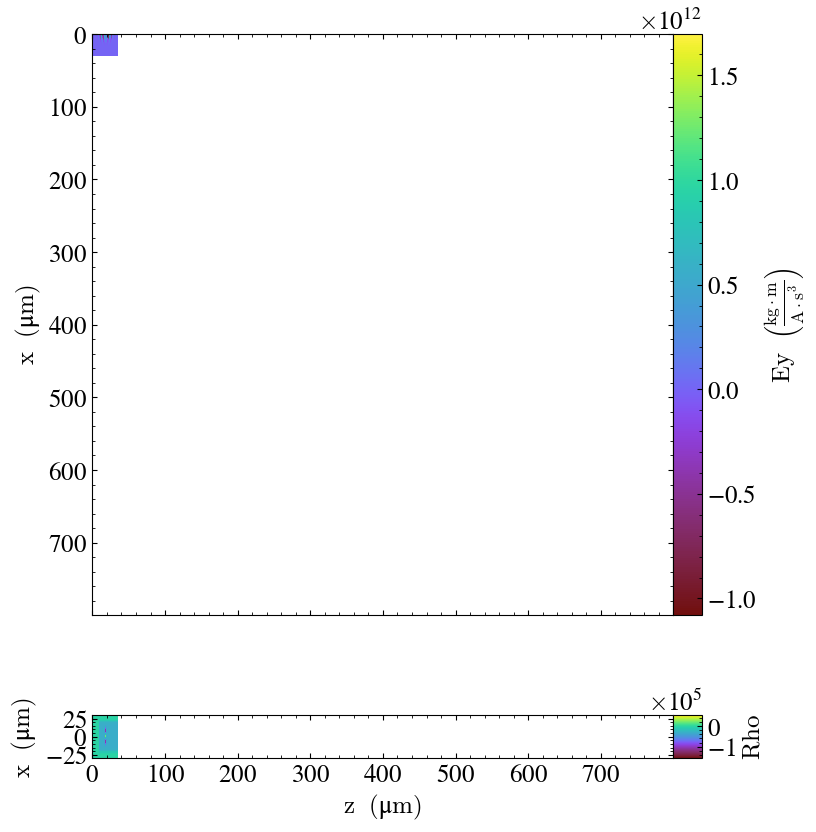

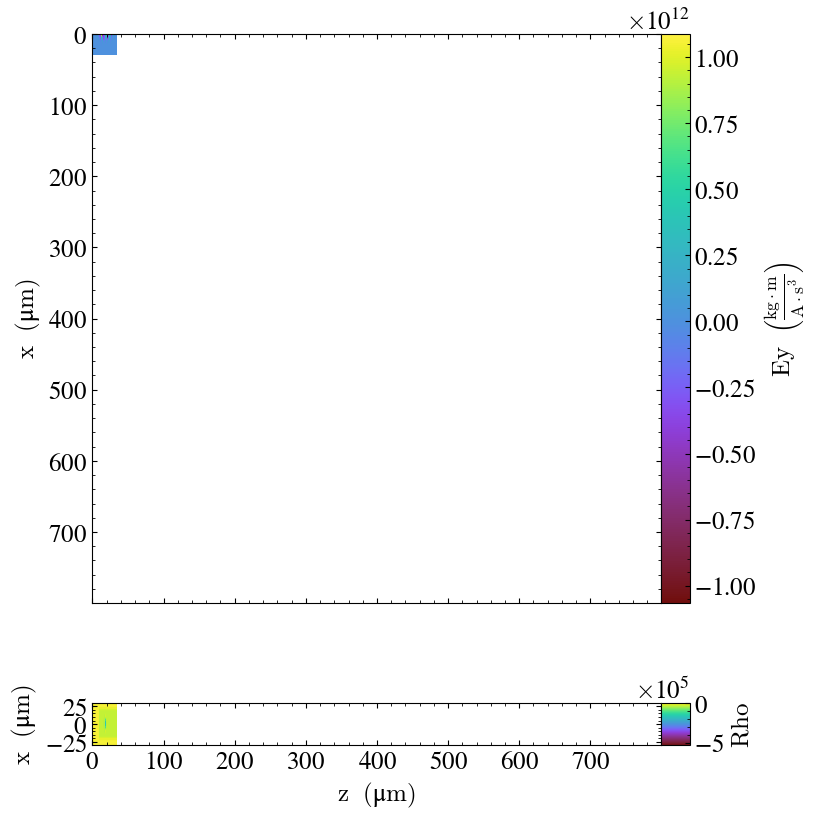

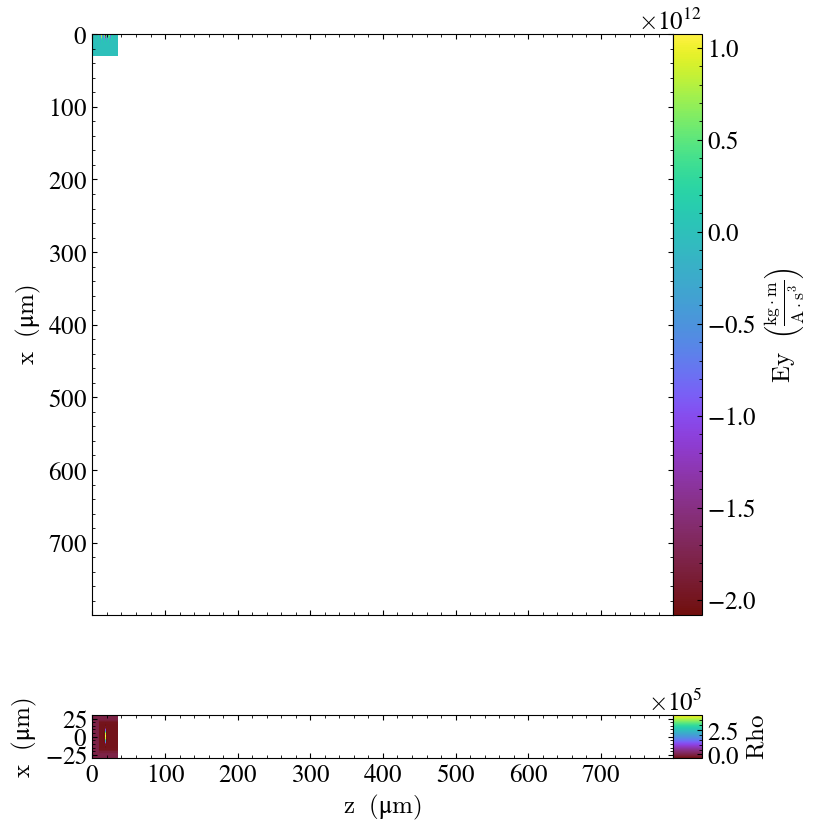

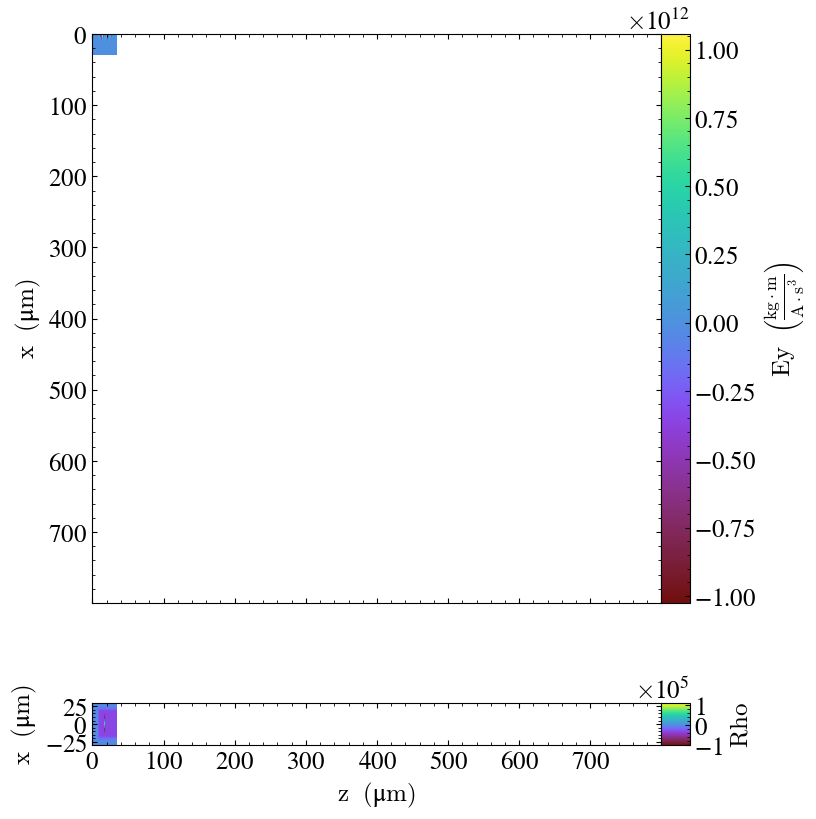

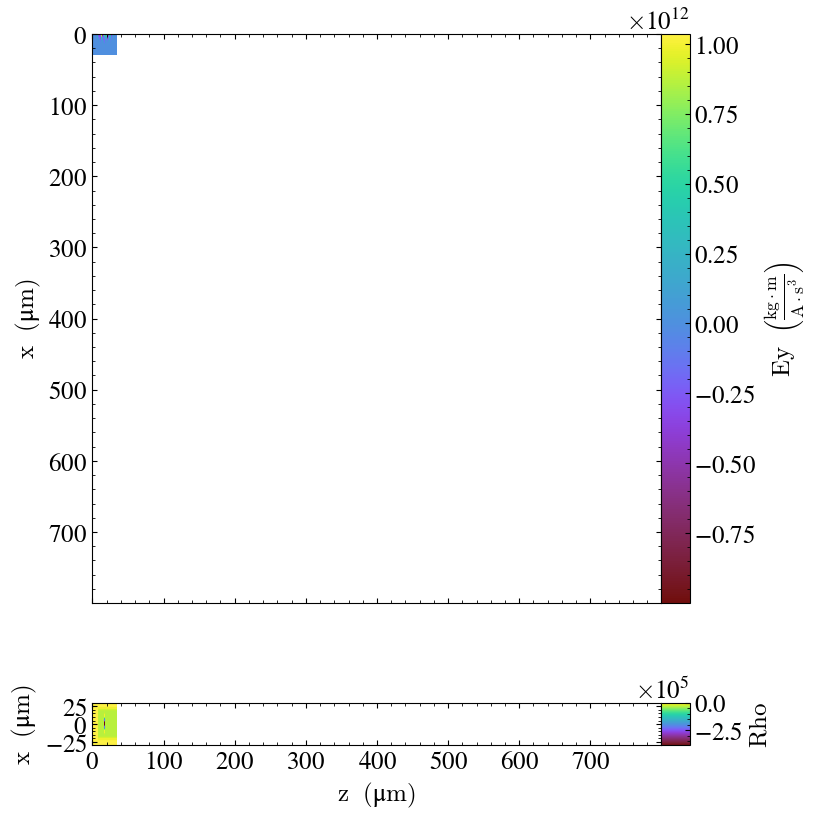

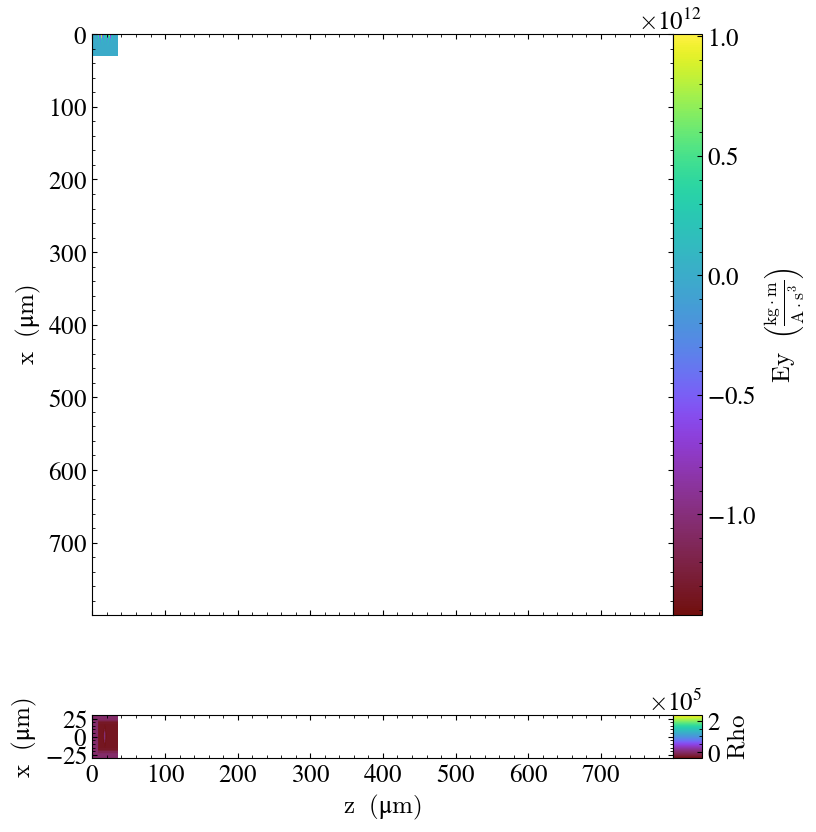

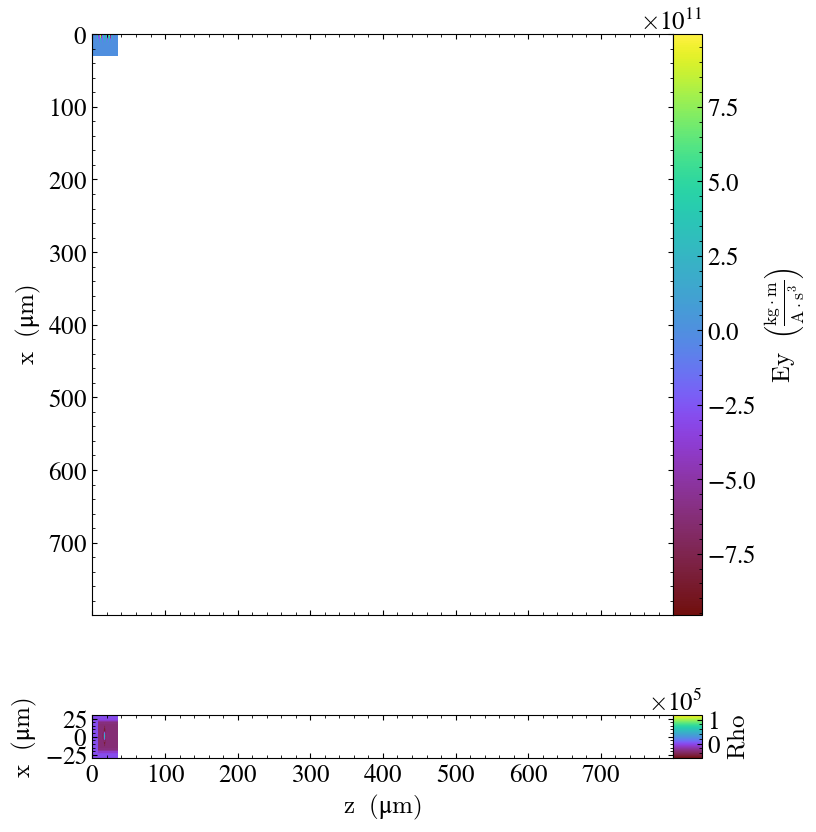

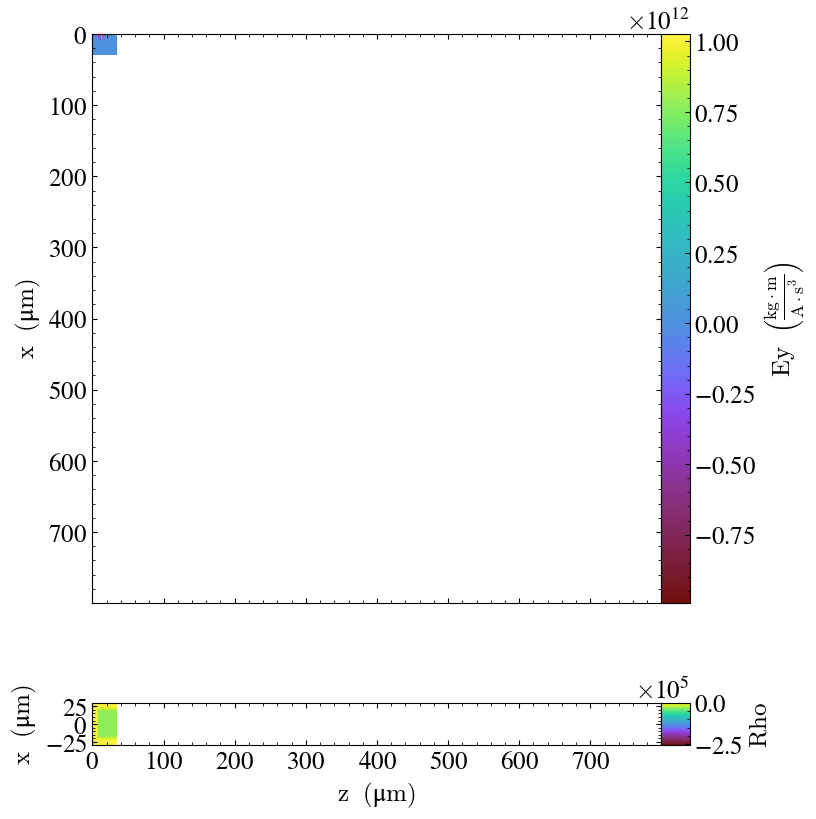

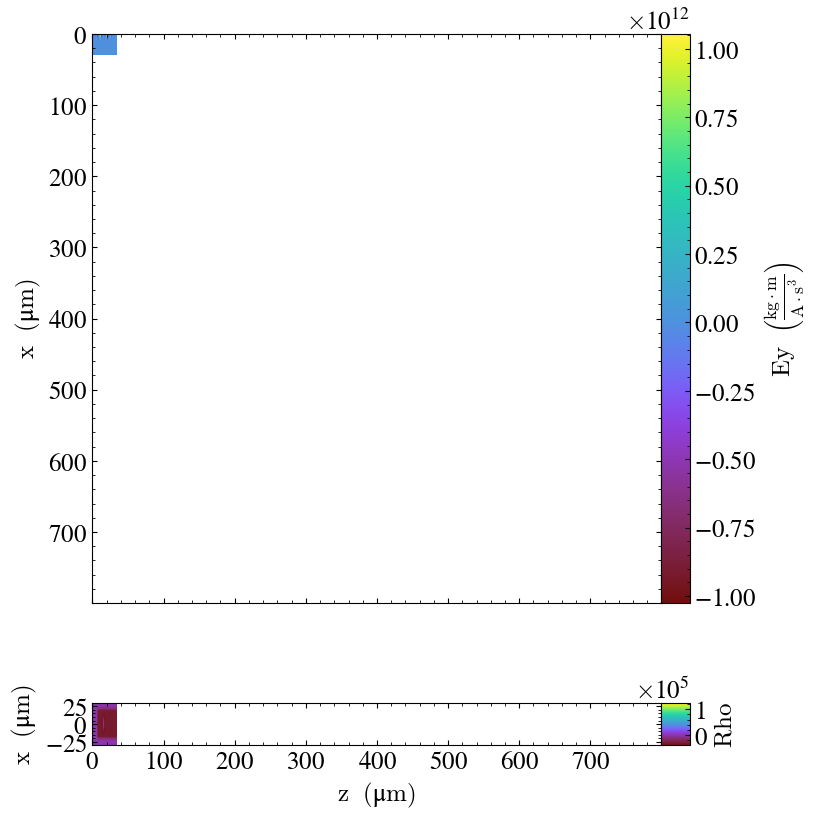

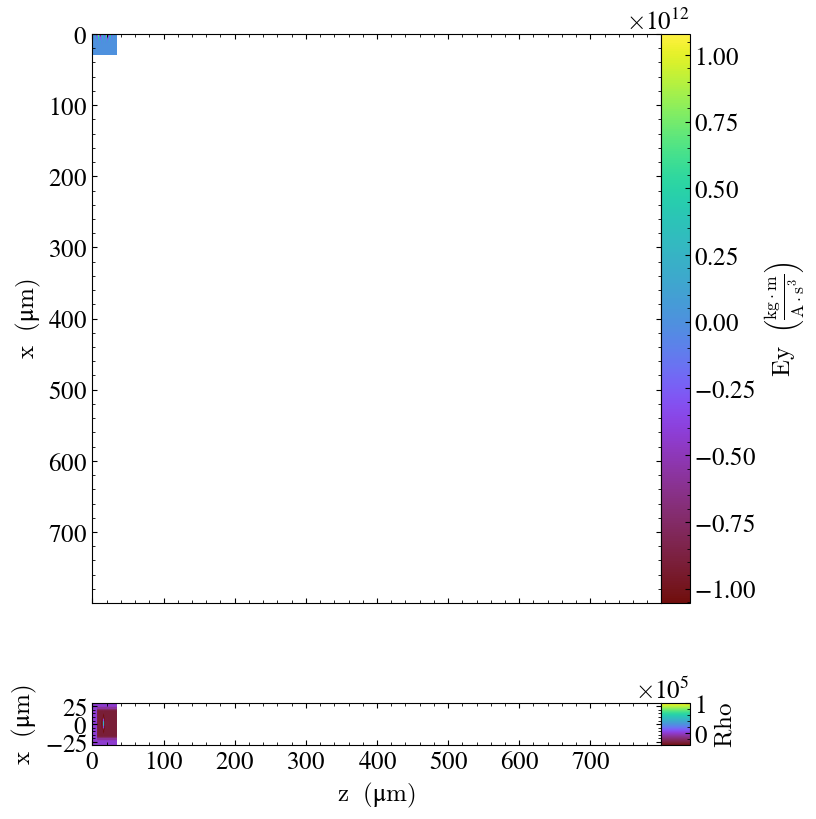

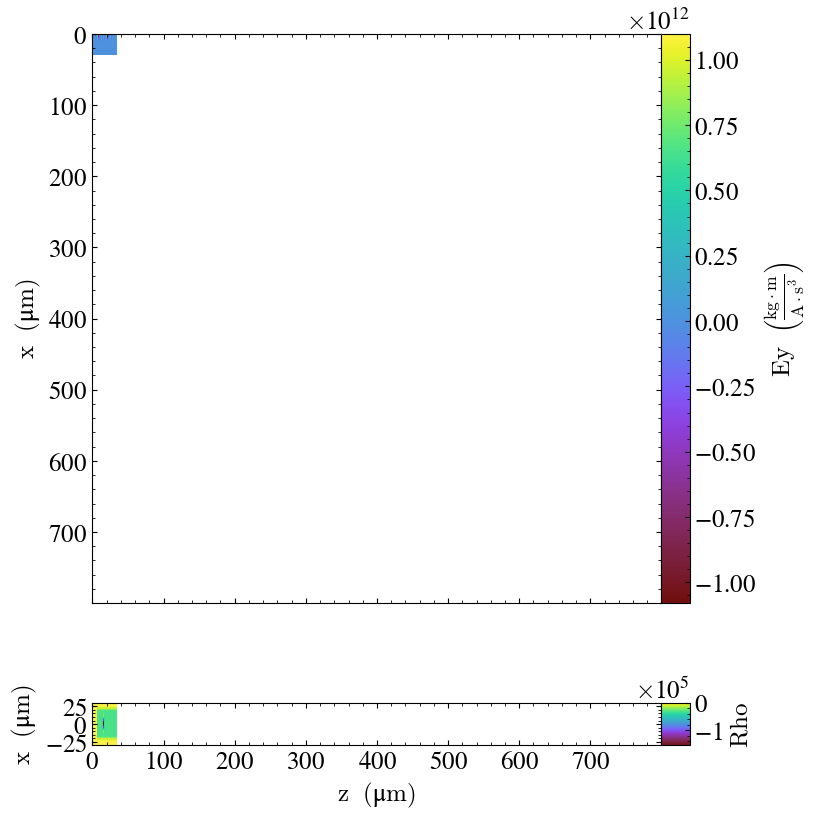

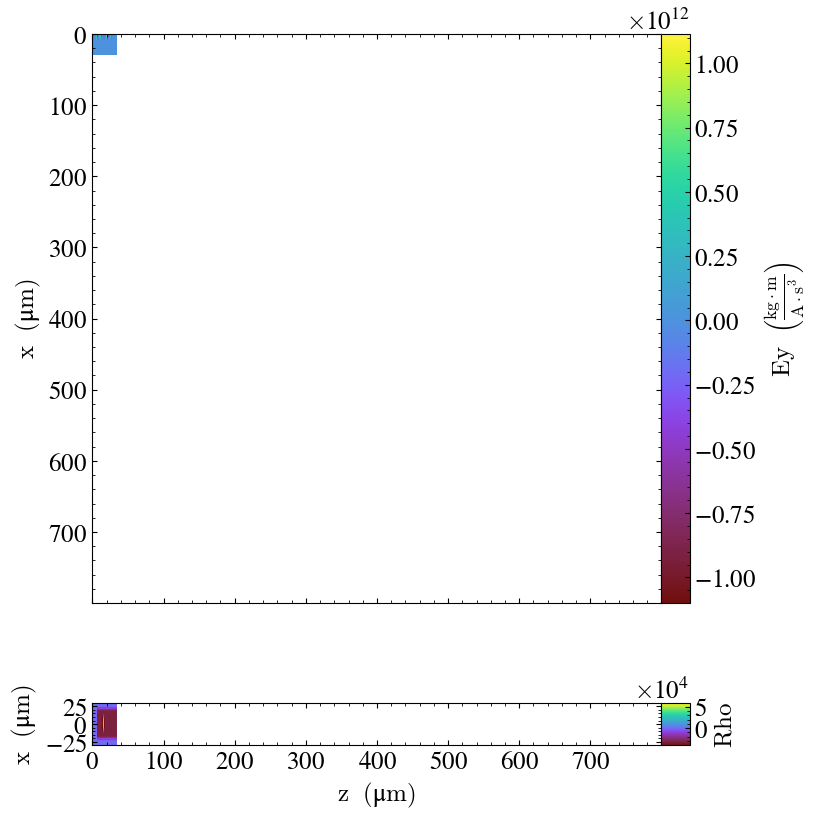

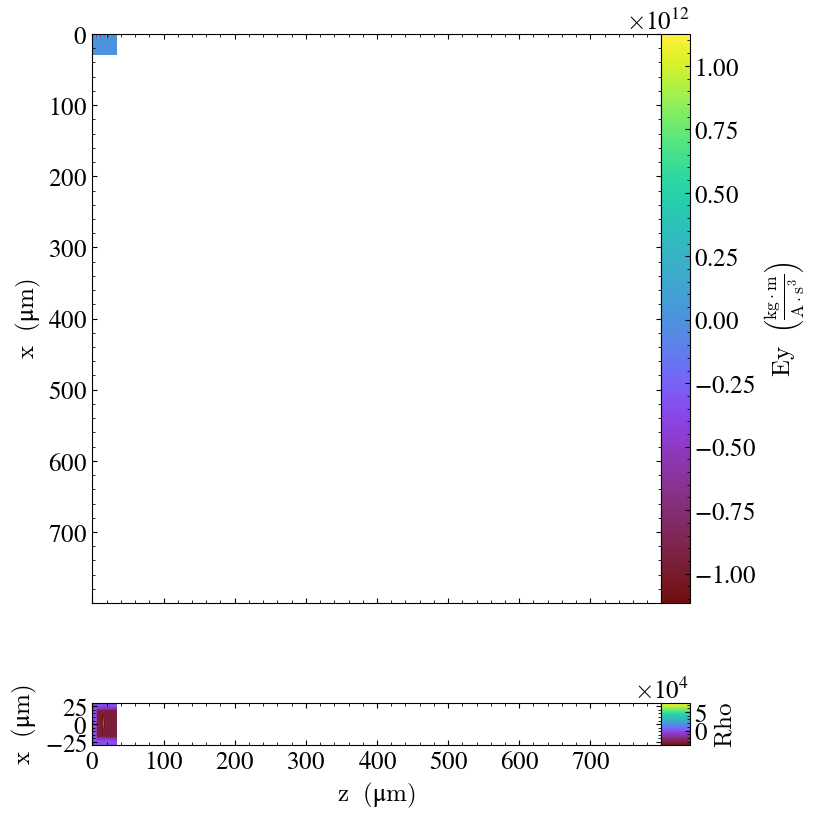

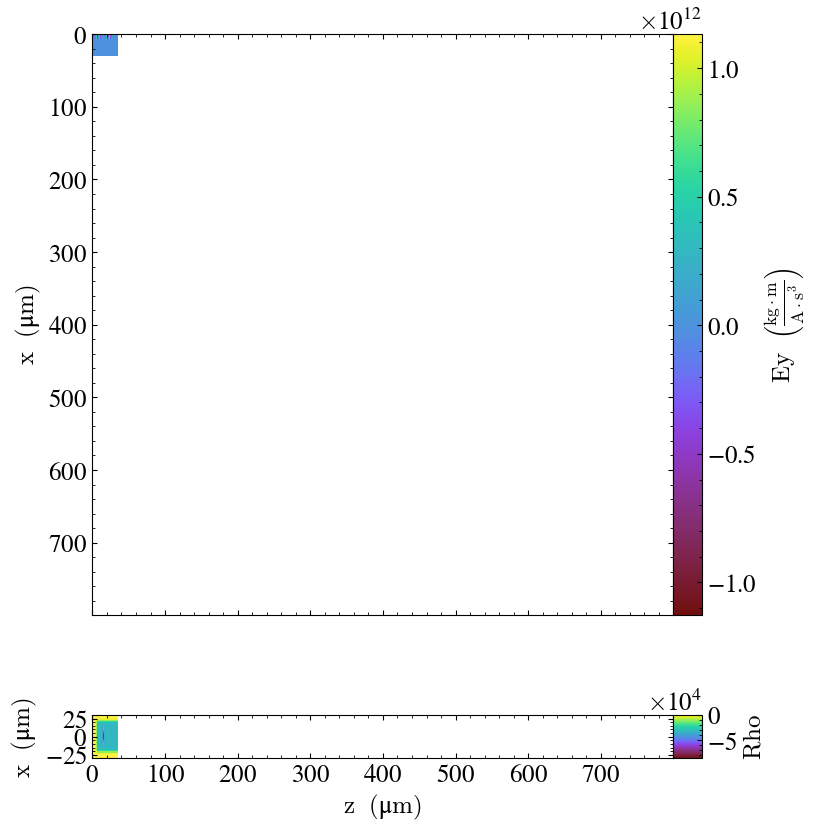

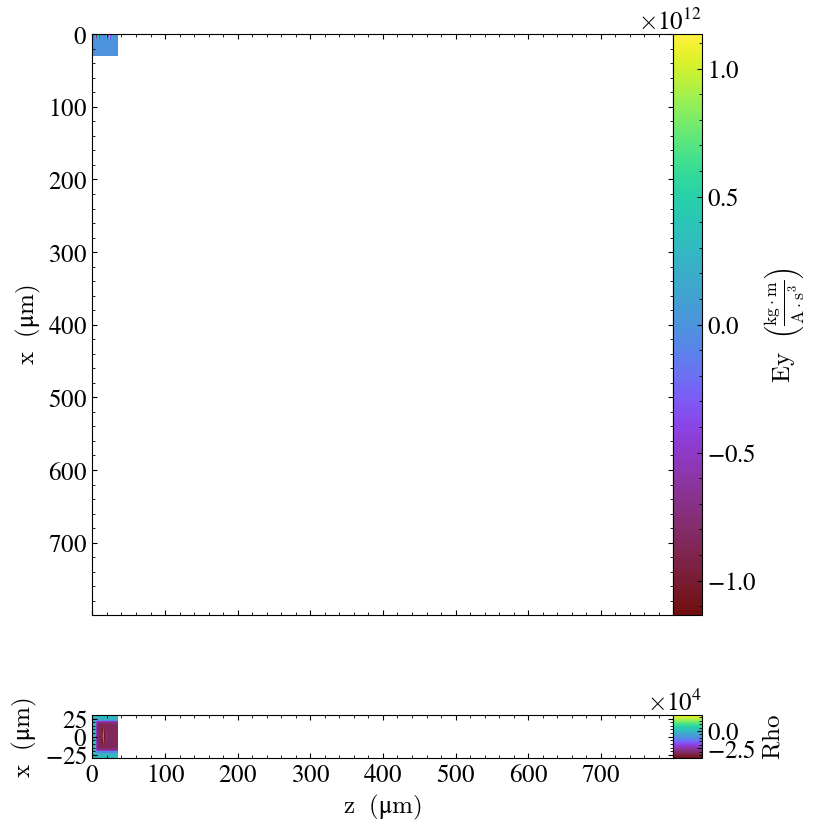

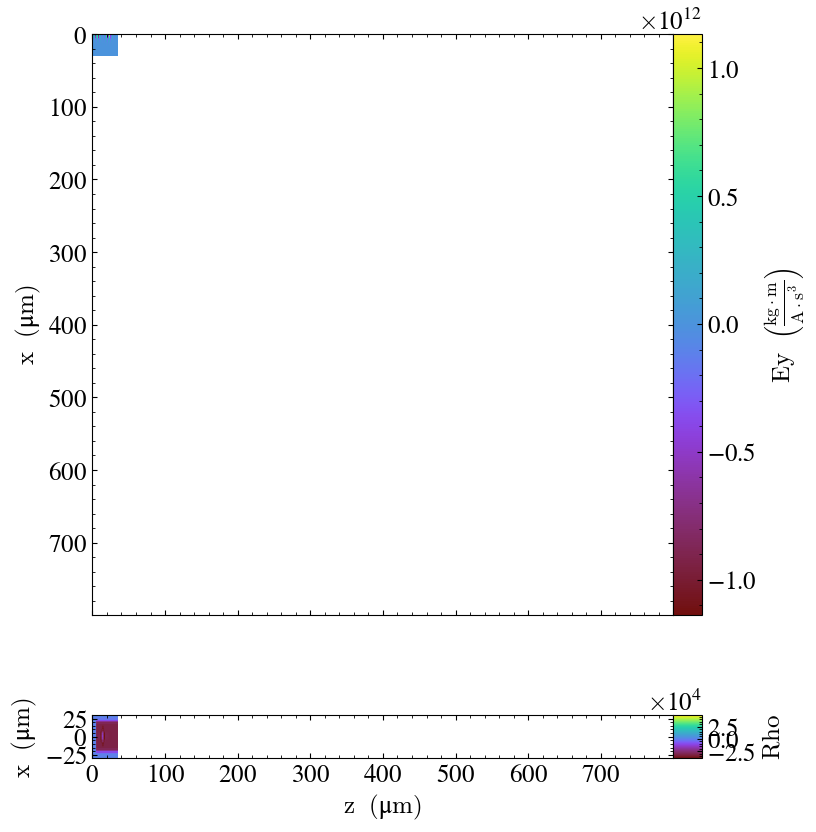

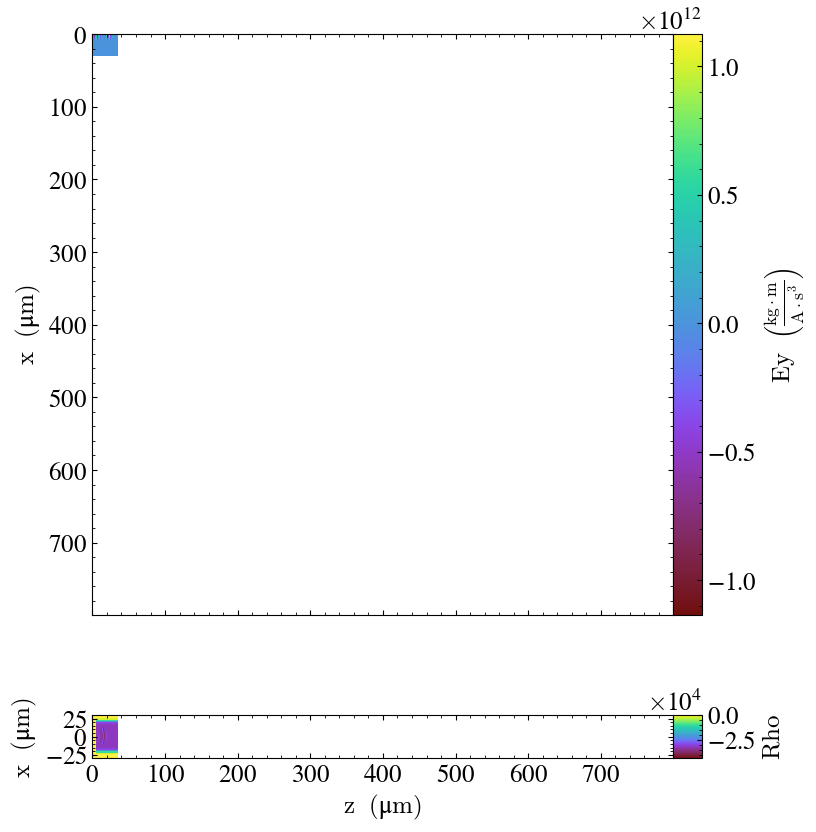

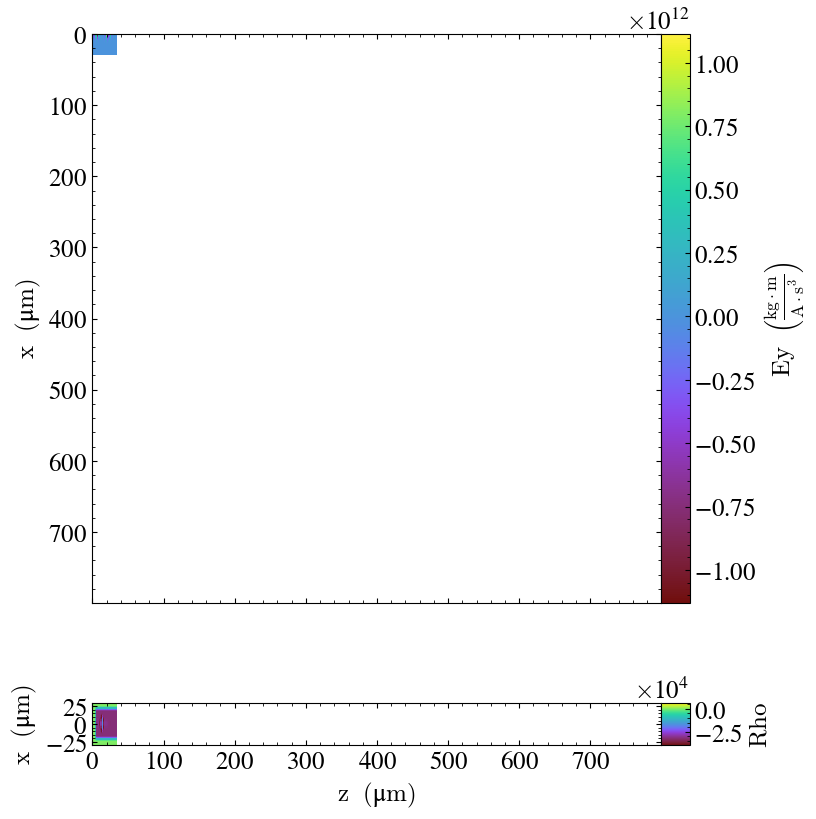

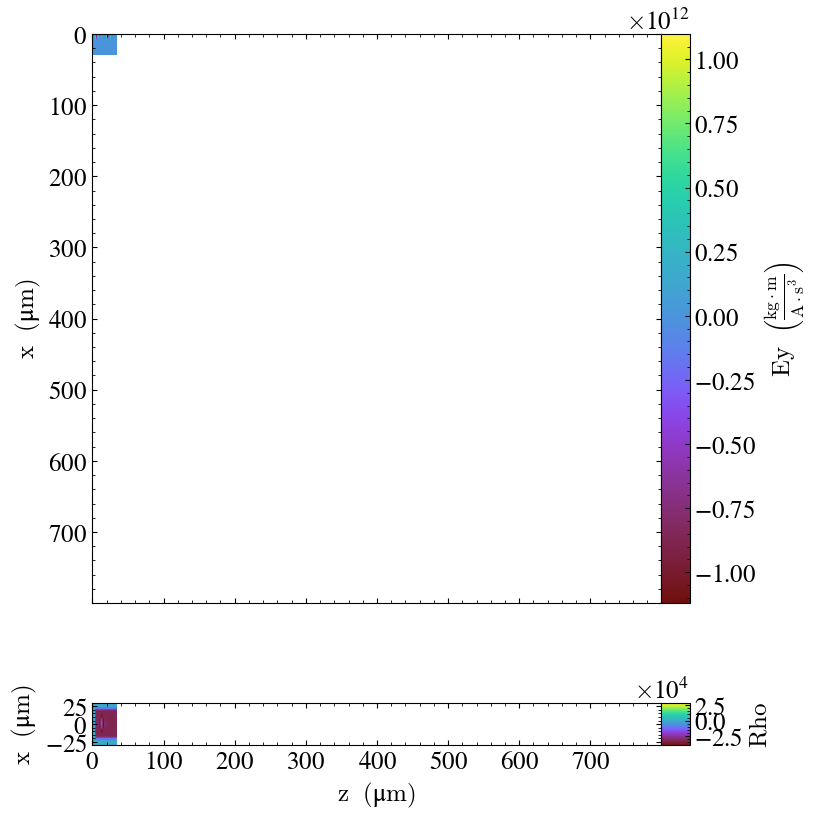

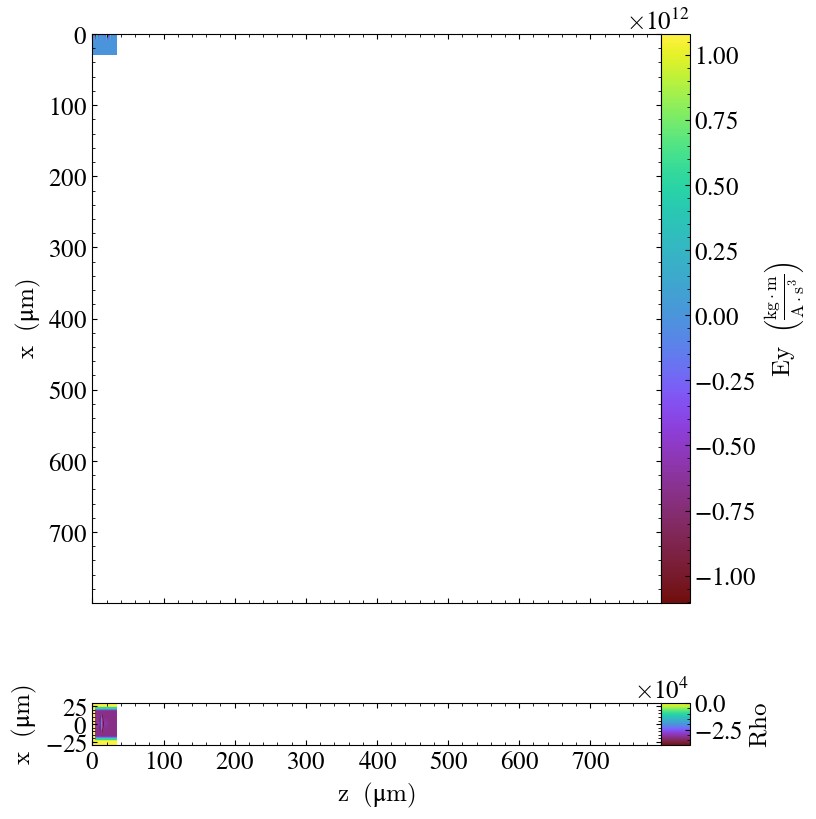

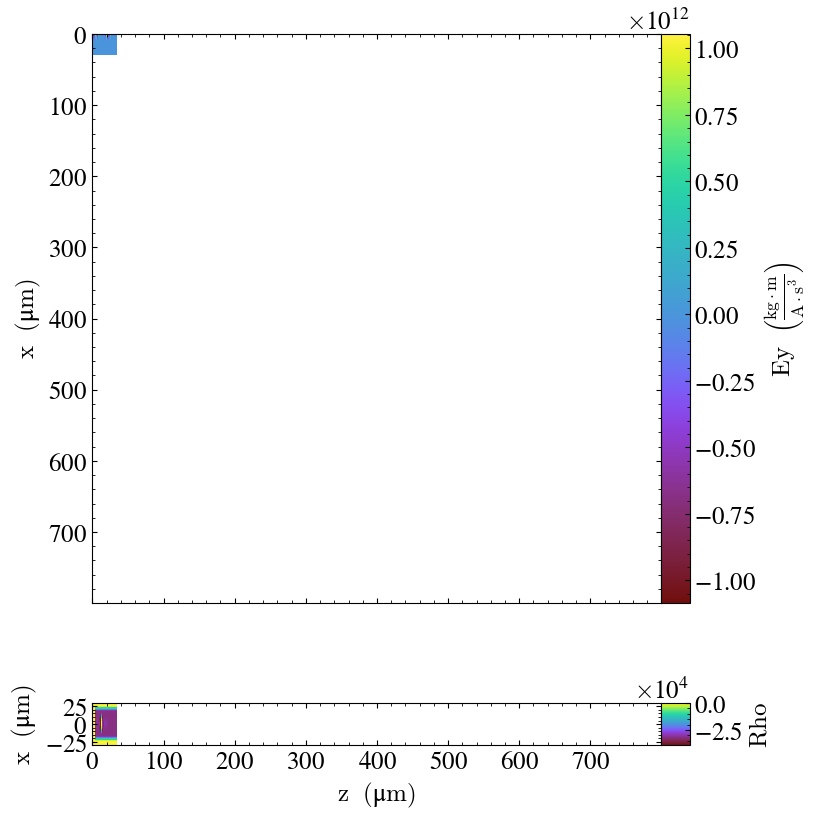

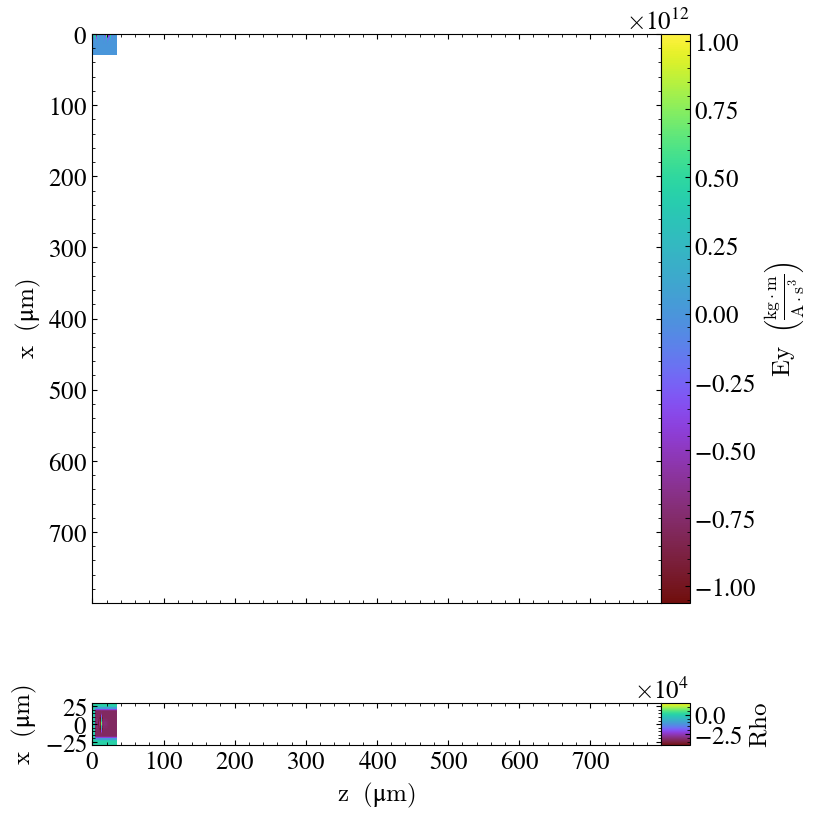

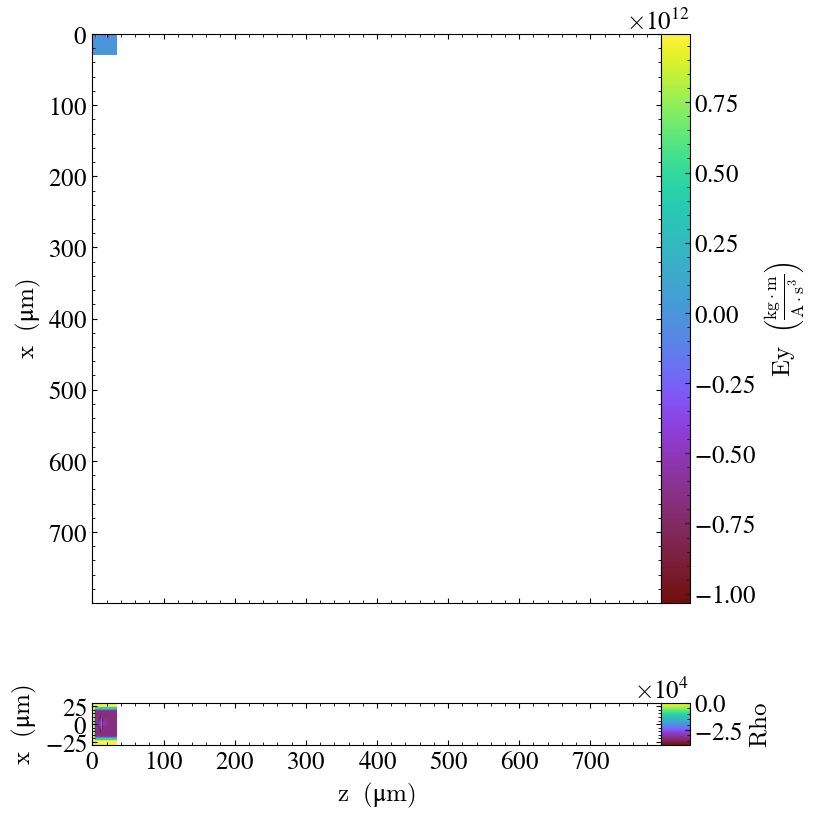

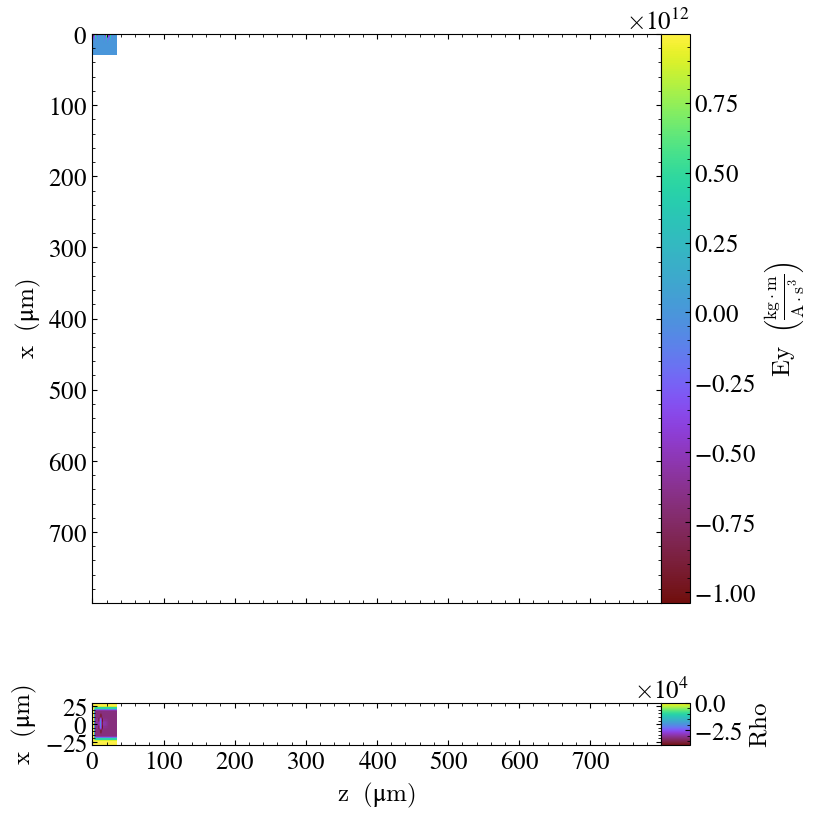

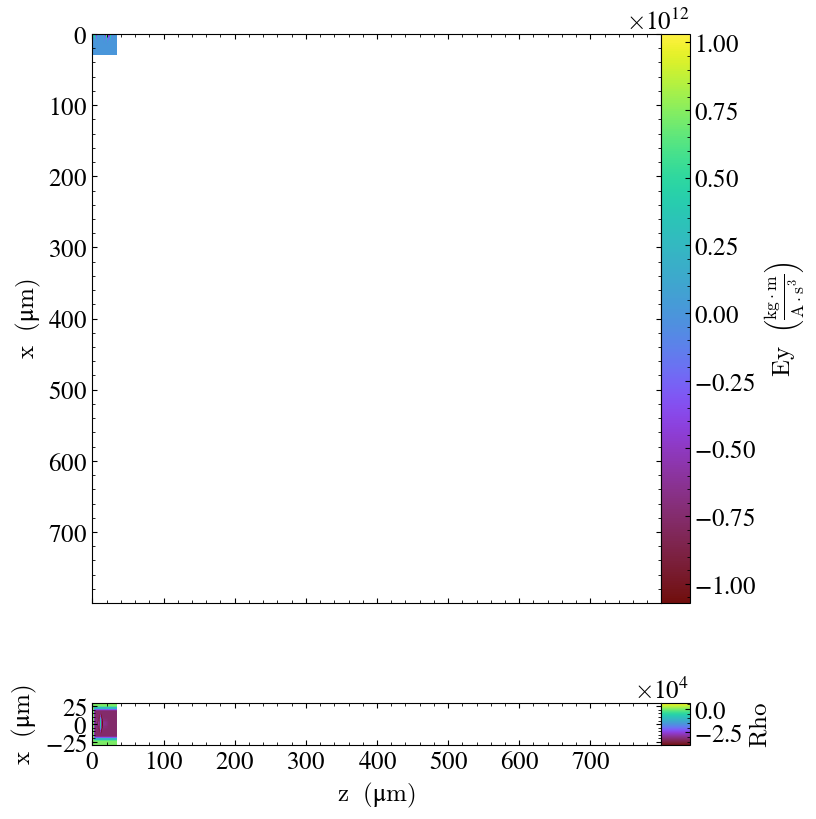

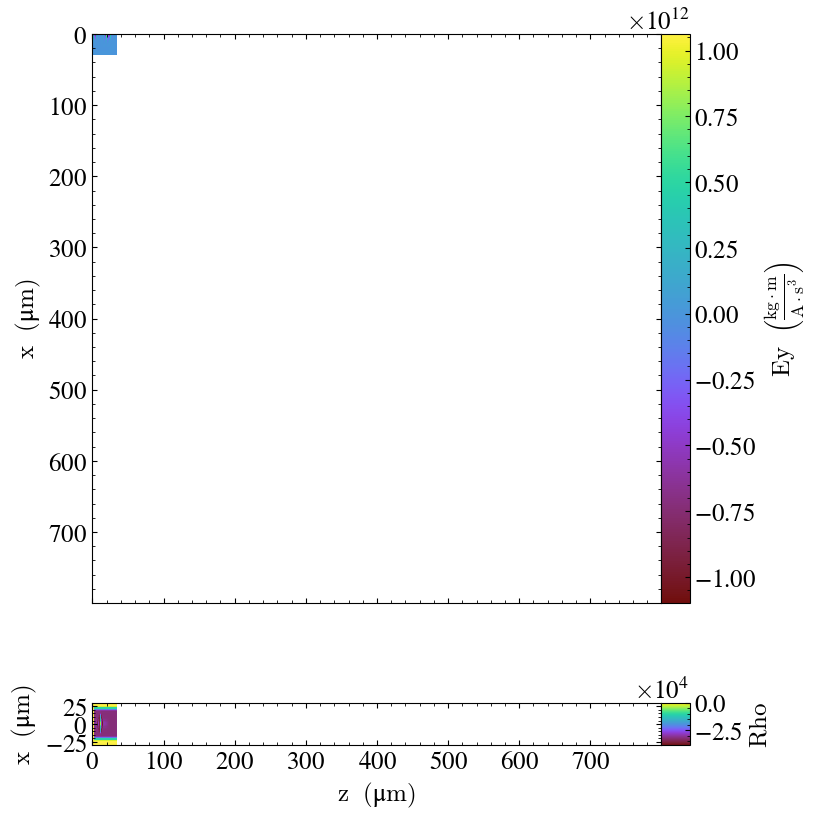

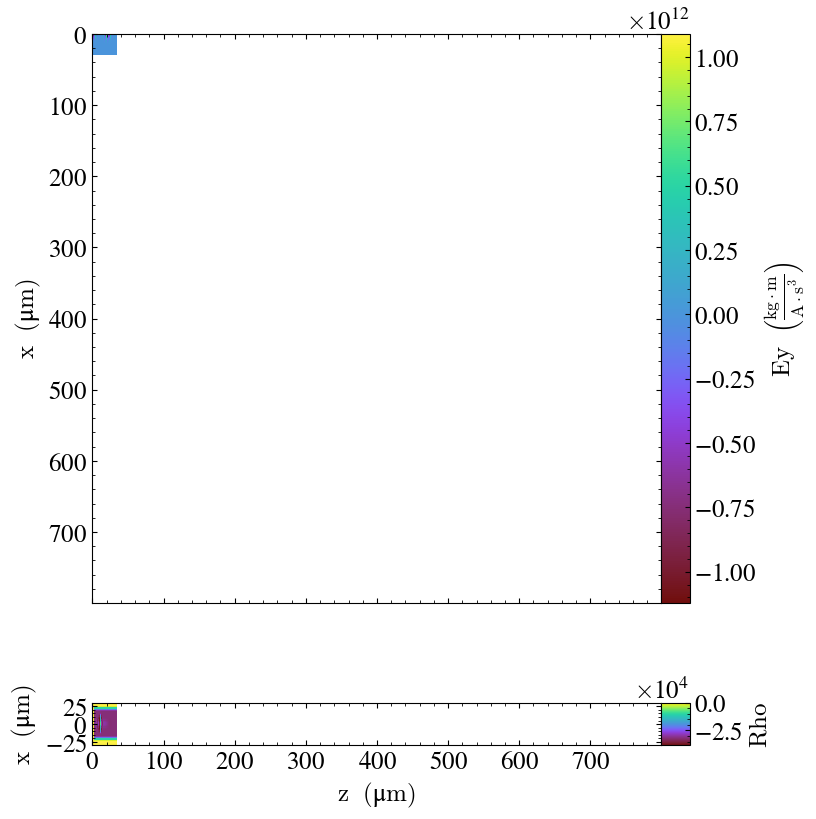

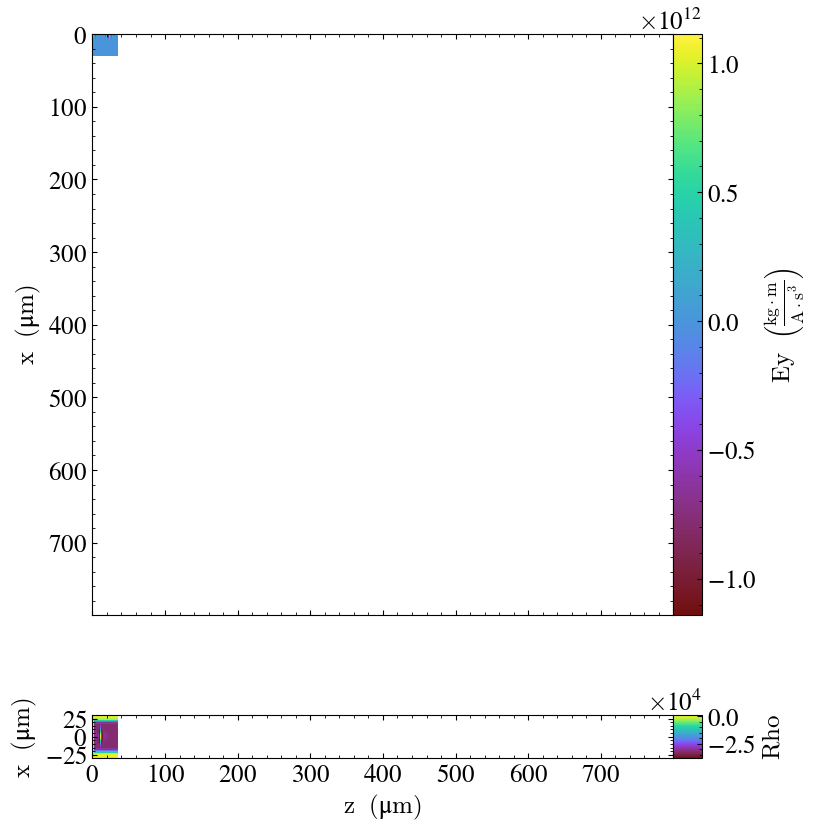

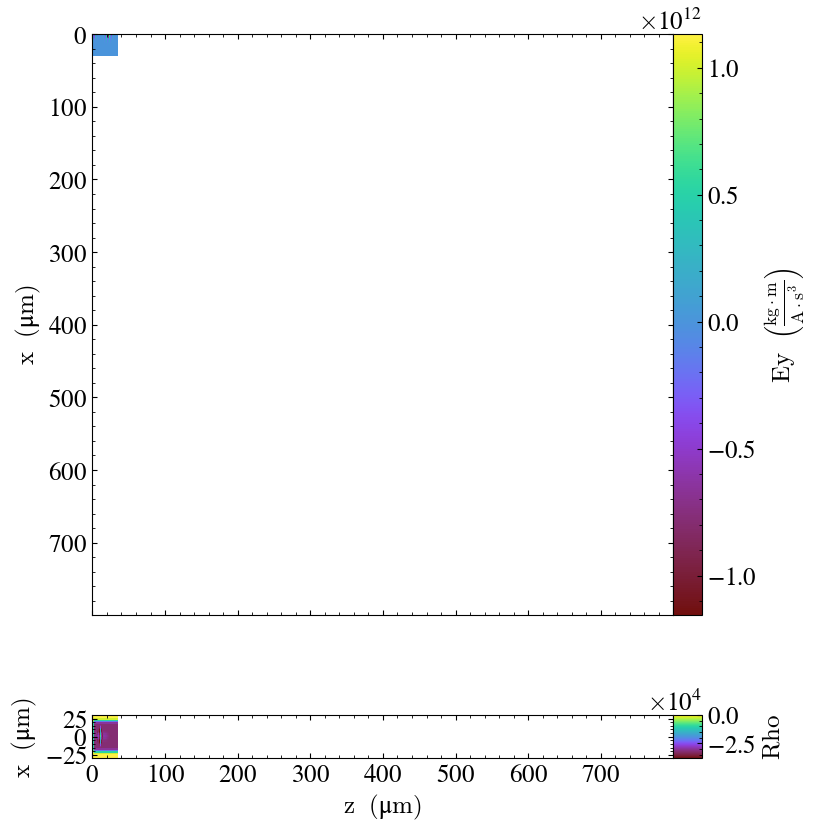

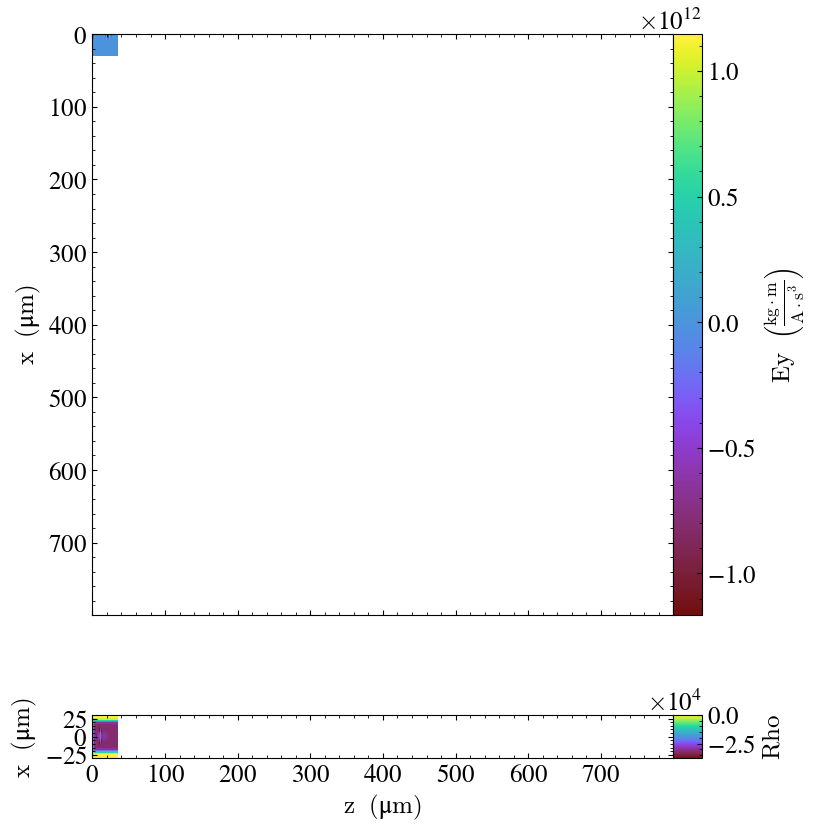

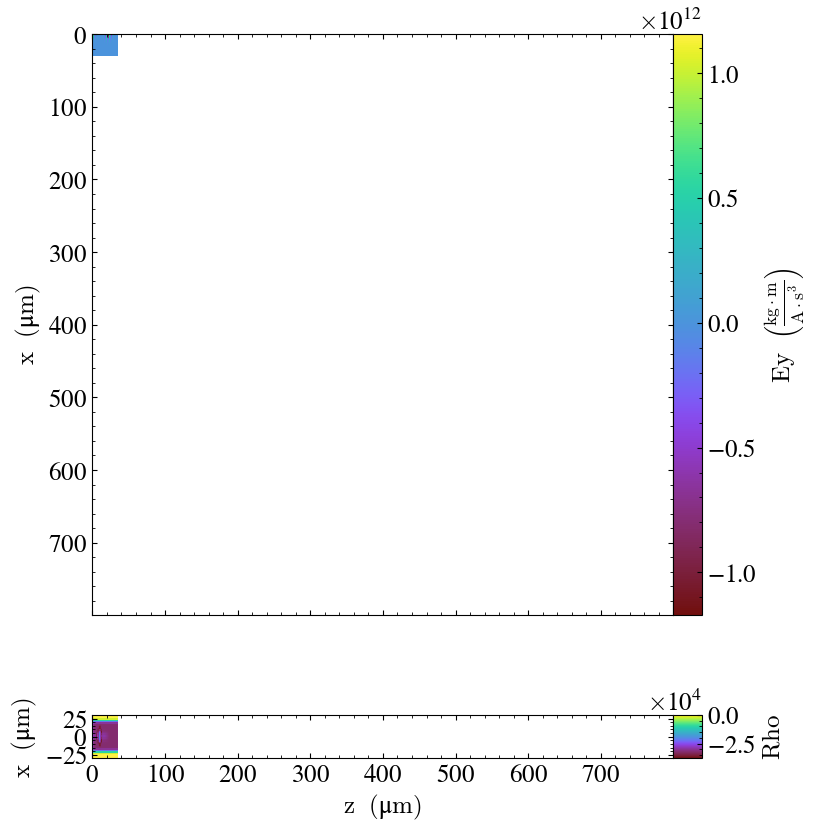

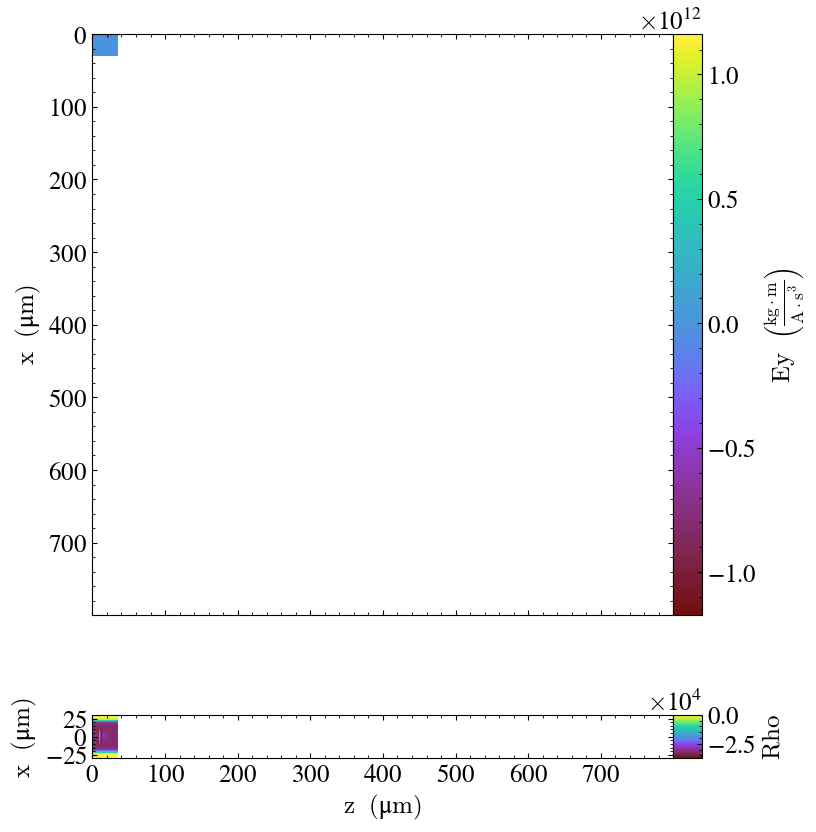

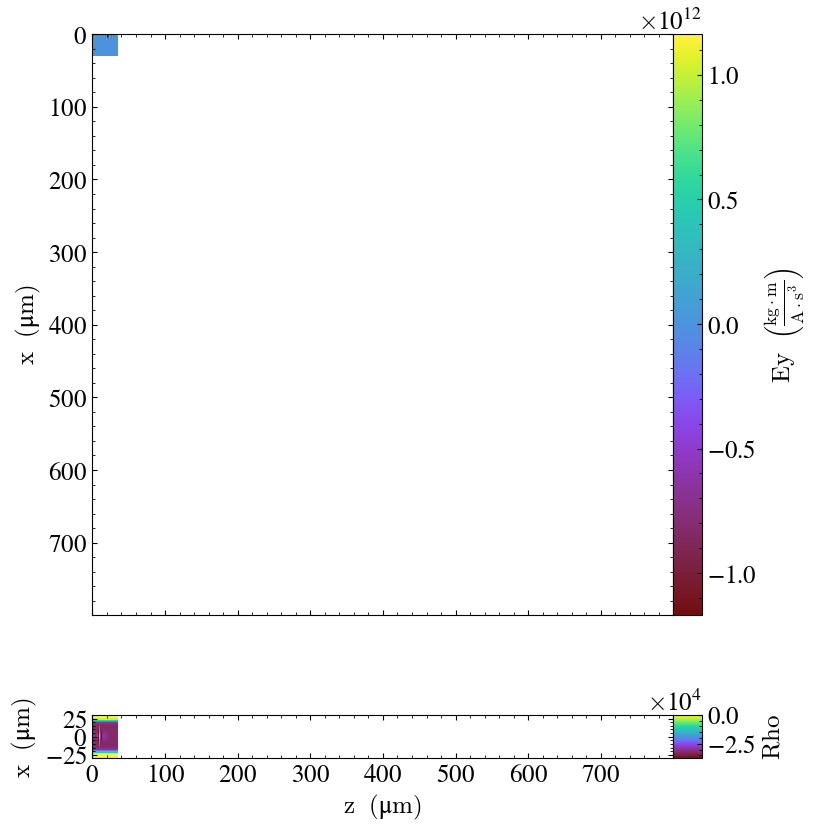

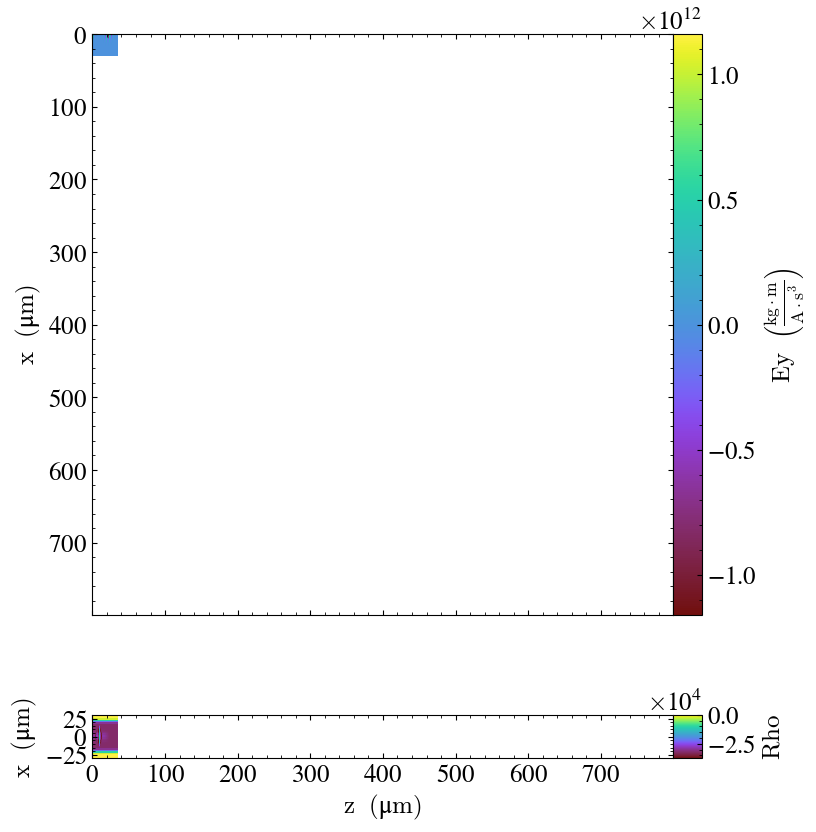

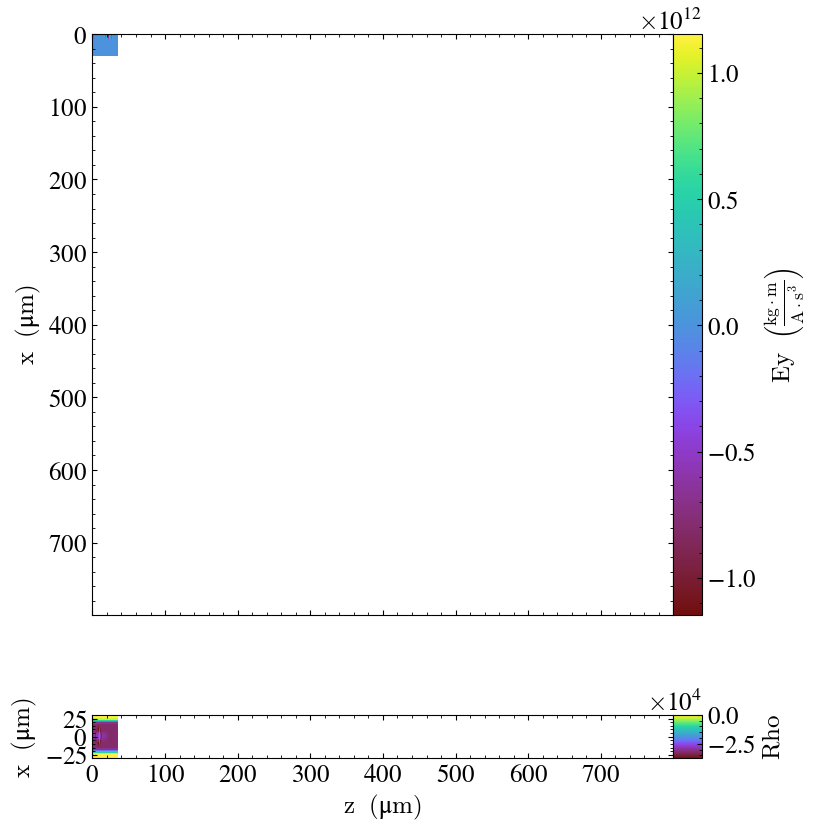

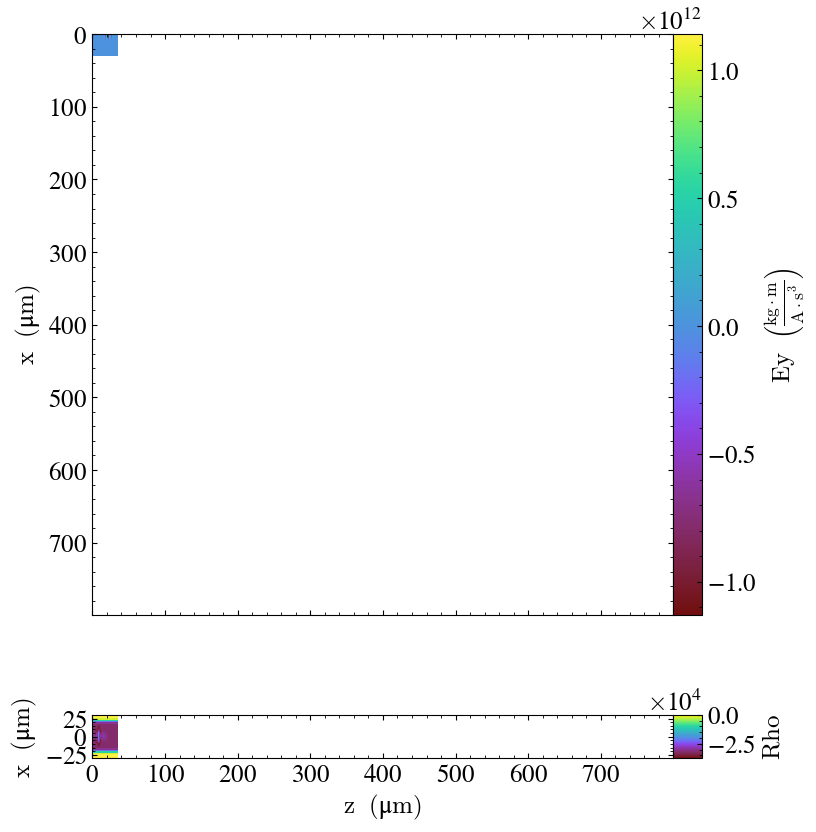

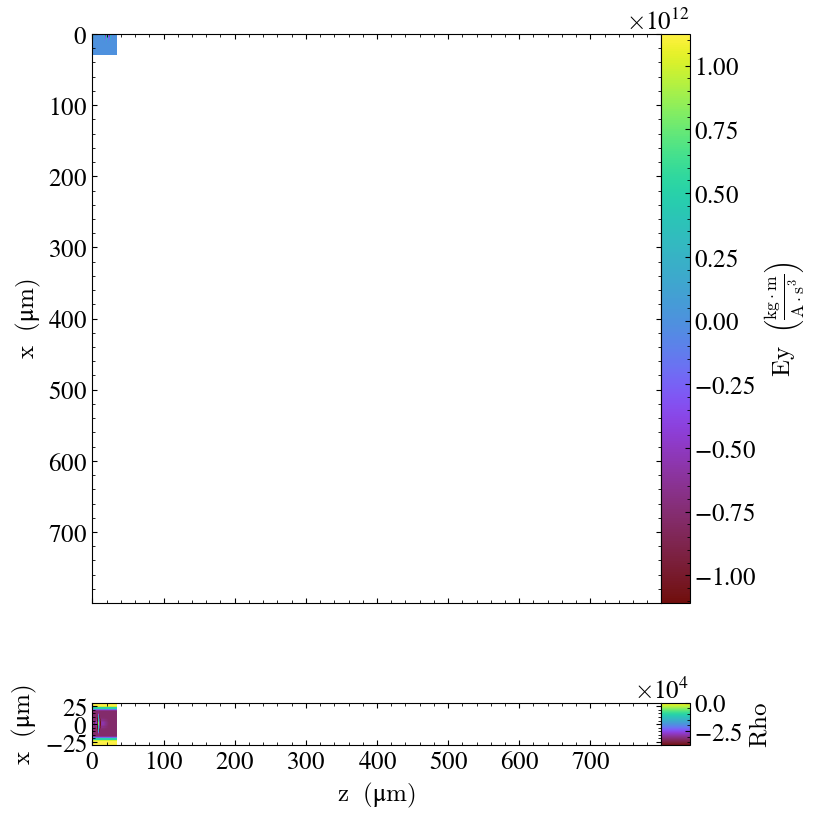

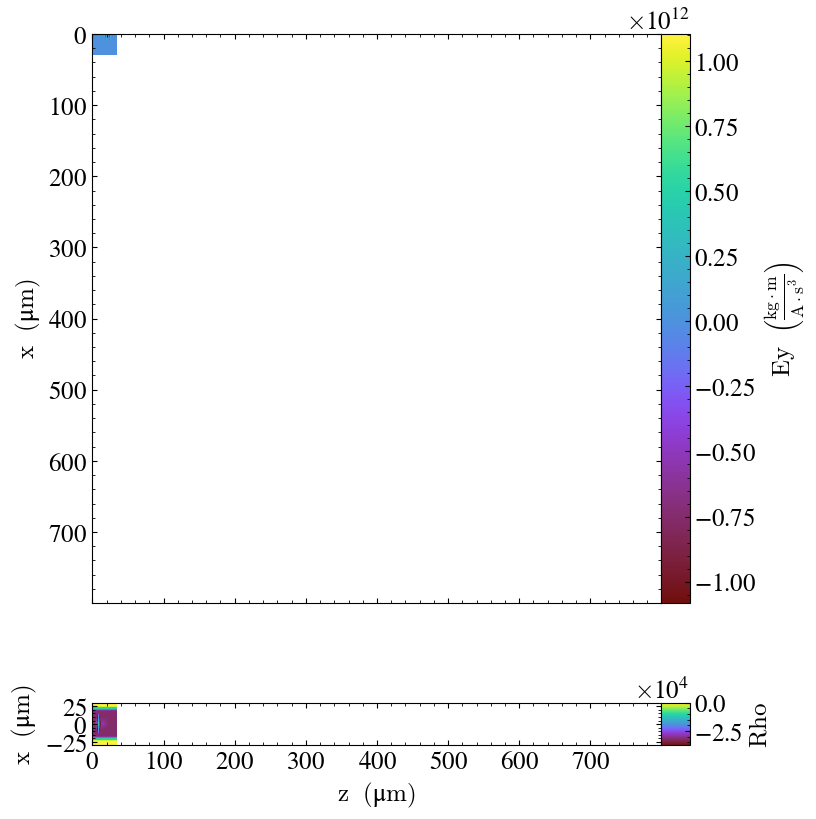

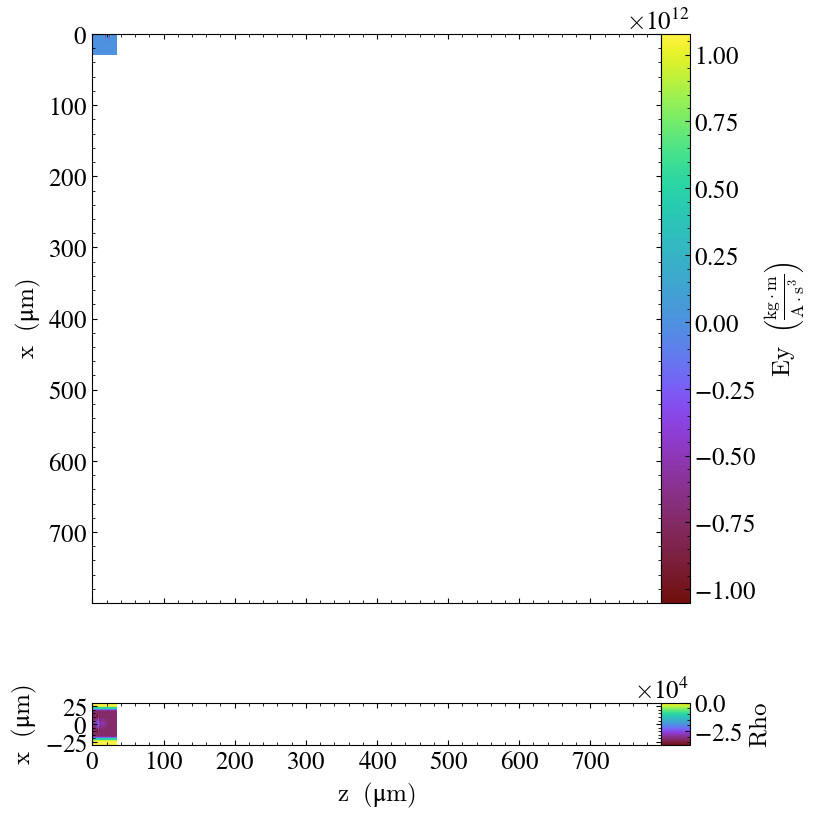

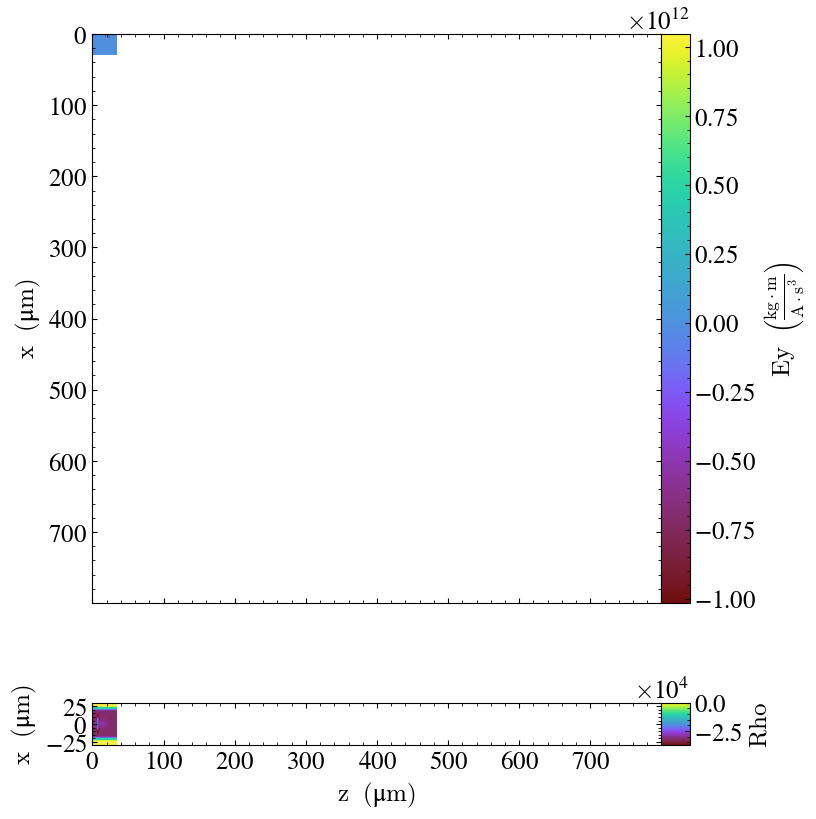

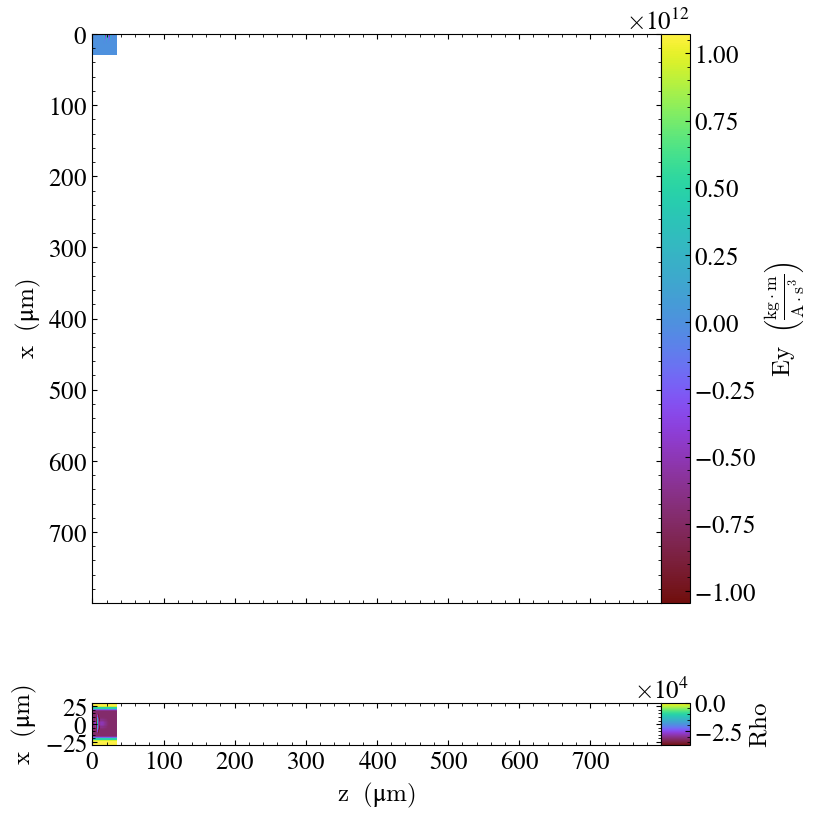

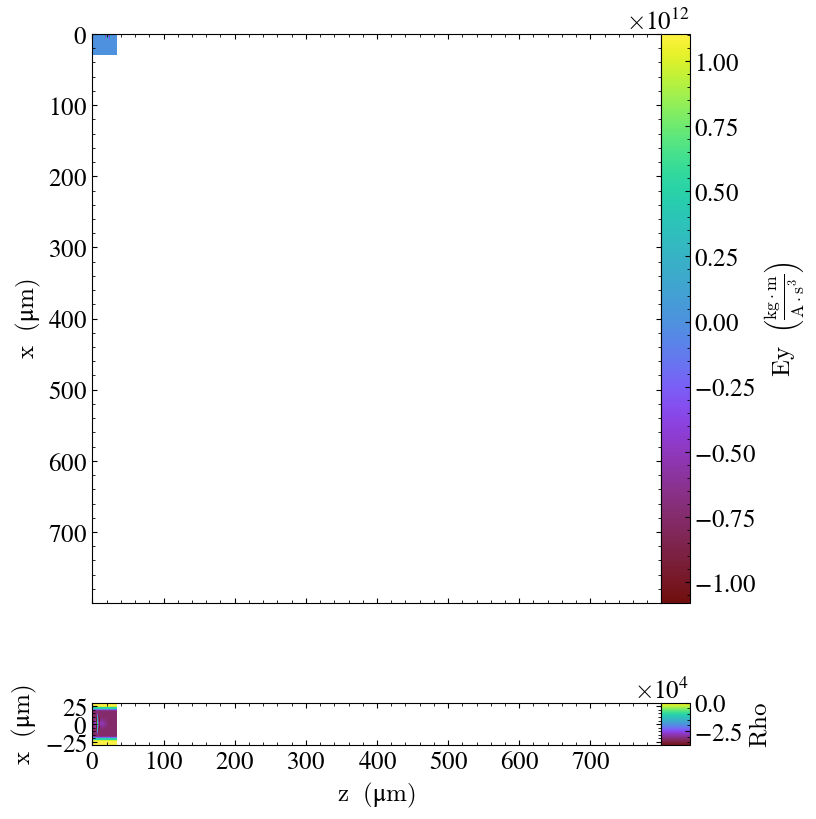

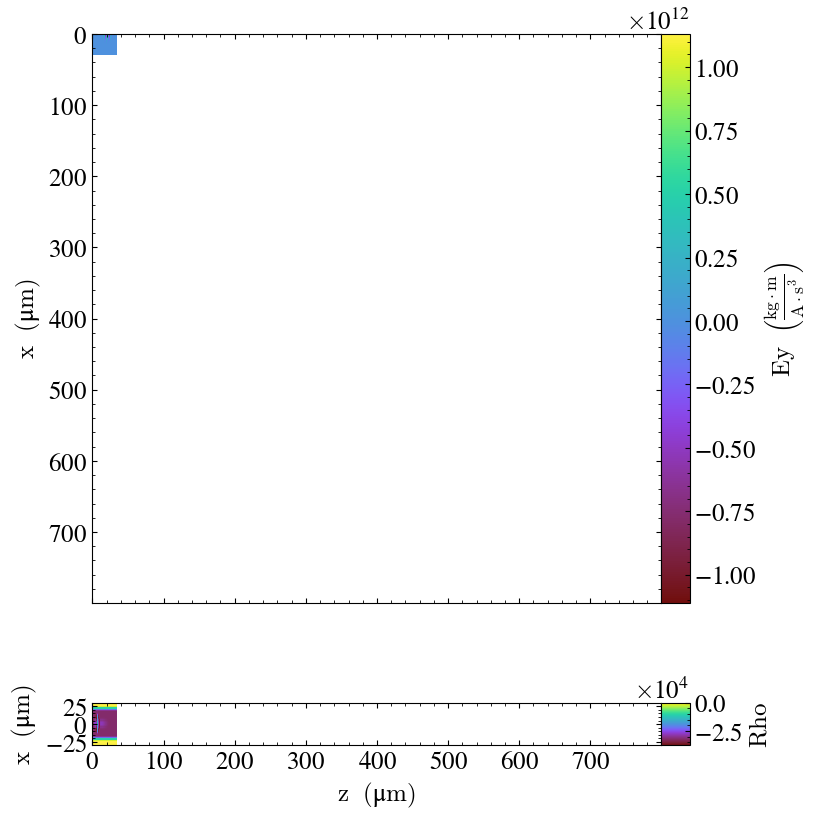

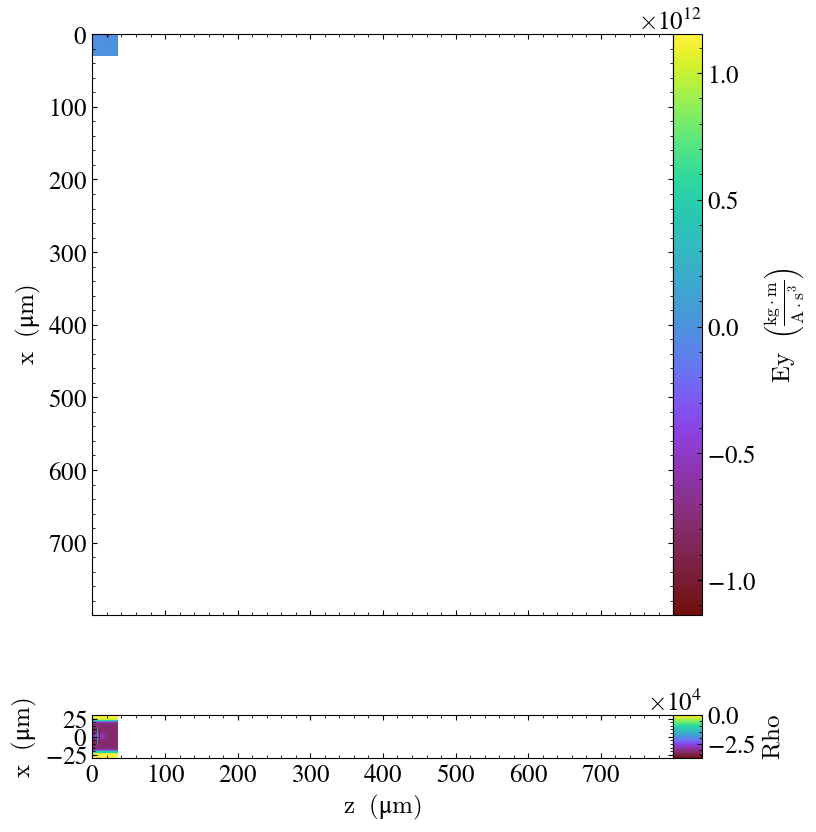

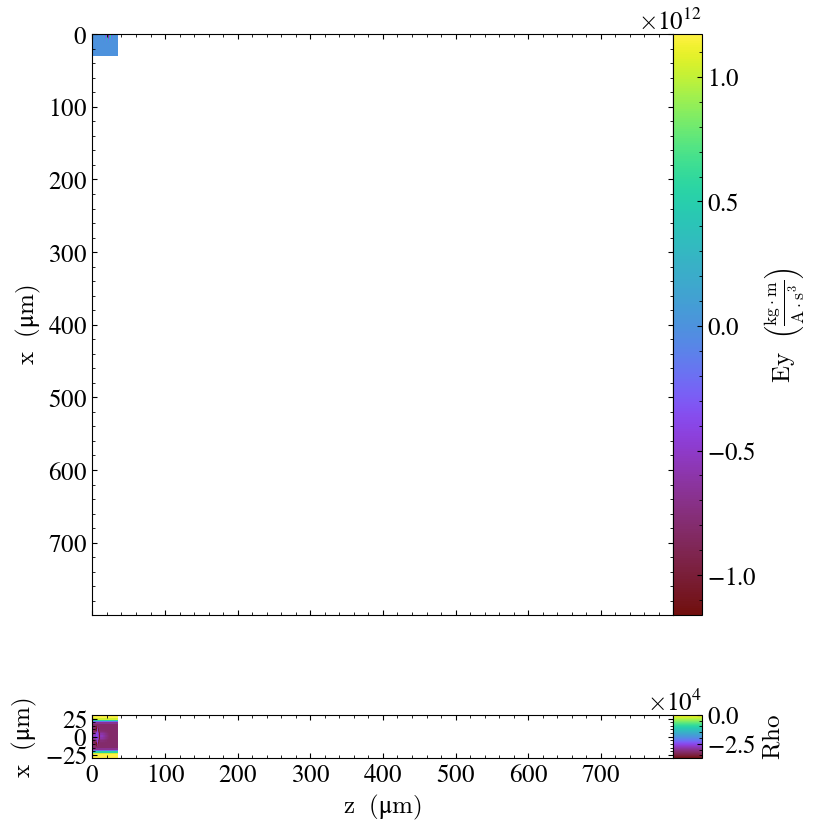

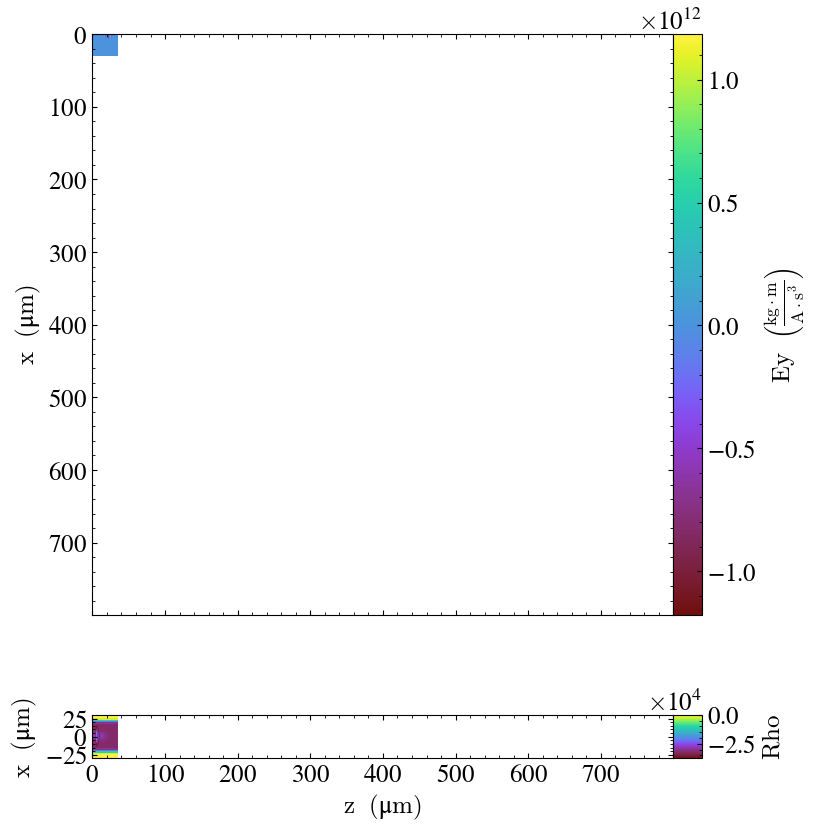

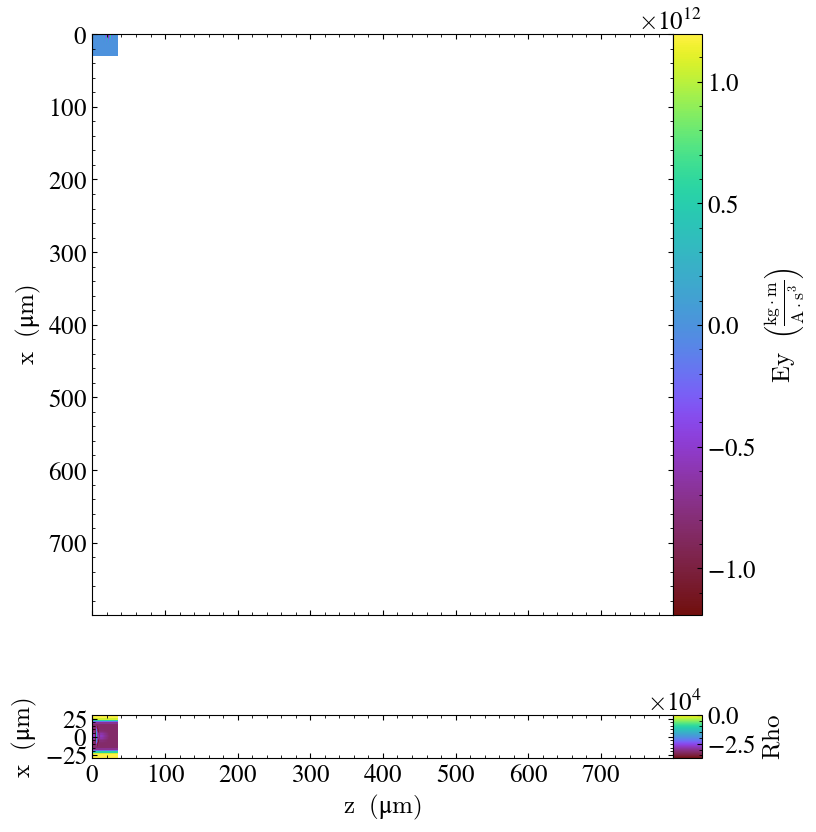

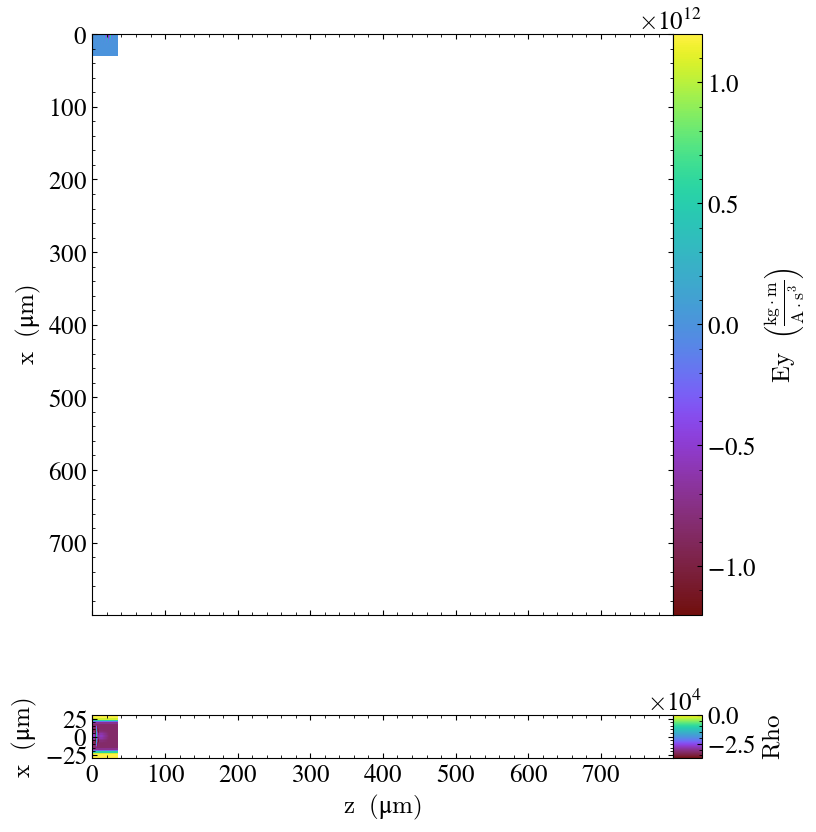

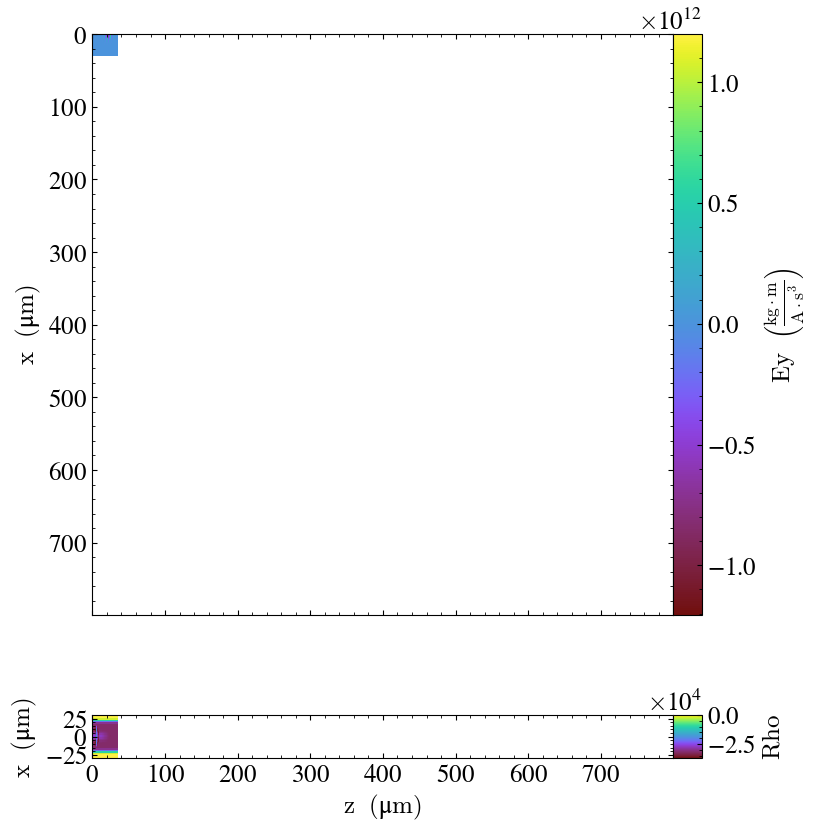

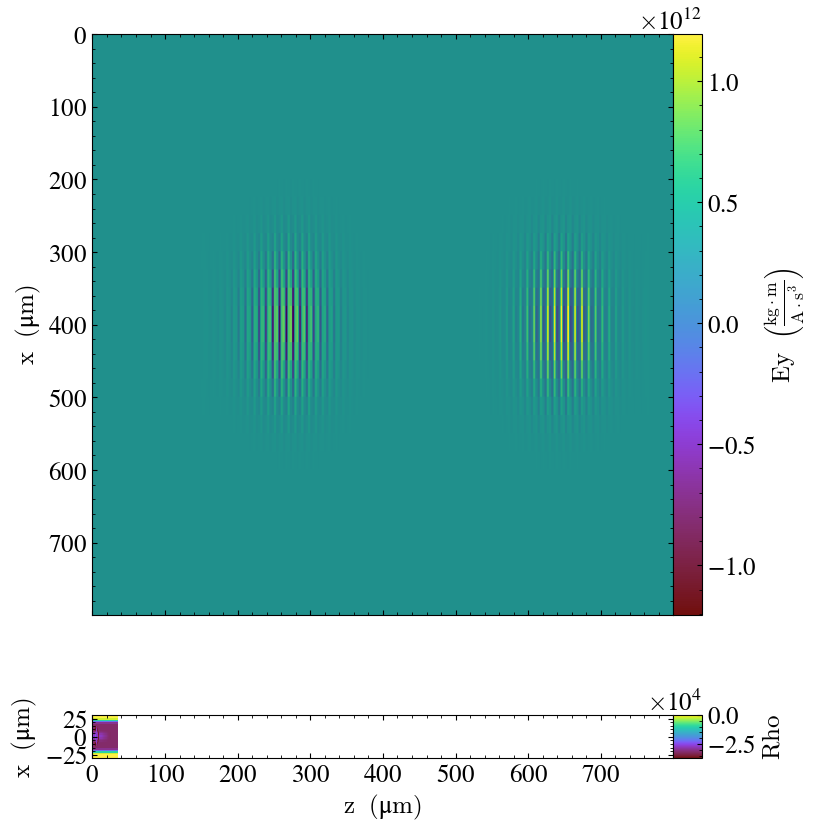

In [5]:
#!/usr/bin/env python3

# Copyright 2023 The WarpX Community
#
# This file is part of WarpX.
#
# Authors: Axel Huebl
# License: BSD-3-Clause-LBNL
#
# This is a script plots the wakefield of an LWFA simulation.

import sys
import os 
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
import yt

yt.funcs.mylog.setLevel(50)

# fig, ax = plt.subplots()  # plt.subplots() creates a new figure and ax is a variable set to it


def plot_lwfa(file_list):
    fig, ax = plt.subplots()  # plt.subplots() creates a new figure and ax is a variable set to it
    
    ims = []  # a list of lists in which each index is a frame of the animation
    file_index = 0
    #for file_index in range(len(file_list)):
    for file_index, fn in enumerate(file_list):
    
        # this will be the name of the plot file
        fn = file_list[file_index]  # give file name to variable 'fn' stands for 'file name'

        # Read the file
        ds = yt.load(fn)  # load the above file into variable ds

        # plot the laser field and absolute density
        fields = ["Ey", "rho"]  # a list of fields representing physical quantities. Here it is electric field and density
        normal = "y"  # this is the axis that is perpendicular to the 2D plane
        sl = yt.SlicePlot(ds, normal=normal, fields=fields)  # make this thing 2D
        for field in fields:  # go through the list of physical quantities
            sl.set_log(field, False)  # don't do any logarithmic scaling

        sl.set_figure_size((4, 8))  # sets the dimensions of the figure height of 4in width of 8in
        fig = sl.export_to_mpl_figure(nrows_ncols=(2, 1))  # converts sl SlicePlot object into a matplotlib figure. A matplotlib fig is like a canvas to display stuff on
        
        fig.tight_layout()
        
        ax = fig.axes[0]  # accessing the first subplot from the grid of subplots (top left?)
        
        # Get the image data from the subplot
        image_data = ax.images[0].get_array()  # Assuming there is one image in the subplot
        
        frame = ax.imshow(image_data)  # TODO: how do i give imshow a valid frame to create? fig is an obj so...
        ims.append([frame])  # add created frames to the list of lists
        
        print(f"FILE #{file_index}")
        # file_index += 1  # move to the next file in the list of file names
    
    print("Frame gathering complete!")    
    
    # iterates through the list of lists to create an animation object
    animate = animation.ArtistAnimation(fig, ims, interval = 50, blit = True, repeat_delay = 1000)
    
    animate.save("plasma_sim_2D.mp4")

    # plt.show()  # display the animation
    

#i = 0
i_increment = 1
frame_number = 101
file_list = []
for i in range(frame_number):
    if i < 10:
        file_list.append(f"Python_LaserAcceleration_plt00000{i}")
    elif i >= 10 and i < 100:
        file_list.append(f"Python_LaserAcceleration_plt0000{i}")
    elif i >= 100 and i < 1000:
        file_list.append(f"Python_LaserAcceleration_plt000{i}")
    #i += i_increment

plot_lwfa(file_list)



In [7]:
rm -r Pyth*